# Flatiron Health mCRC: Data Wrangling Training Set

**OBJECTIVE: Identify a training cohort and create a dataframe of relevant variables which can be used to build machine learning survival models.**

**BACKGROUND: There are three sections to this notebook. First, the final cohort will be split 80-20 into a train and test set. The split will ensure the distribution of diagnosis years is the same in the train and test set given increased missingness of in earlier diagnosis years and changes in treatment practices with time.**

**The second section of this notebook involves preparing the data so that each row corresponds to a unique patient from the training set and each column is a relevant variable for mortality prognositication. There are 12 CSV files from Flatiron that will be used. The eligibility window for collecting variables is typically -90 days and +30 days from index date, which is time of metastatic diagnosis. Plus 30 was selected as the upper bound of the eligibility window given that median time to start of first line treatment is about 30 days from metastatic diagnosis.**

**The last section involves merging these datatables into a master which will be used for building machine learning survival models.** 

**Details on missing data is discuessed in the machine learning building notebook.** 

**OUTLINE:**
1. **Creating train and test cohort**
2. **File cleaning for patients in training set**
3. **Merge files to create master training dataframe**

## Part 1: Creating training and test cohort 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

### Splitting into training and test set

**Patients will be split into a train and test set (80/20) stratified by metastatic diagnosis year.**

In [3]:
enhanced_met = pd.read_csv('Enhanced_MetastaticCRC.csv')

In [4]:
row_ID(enhanced_met)

(34315, 34315)

In [5]:
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

In [6]:
enhanced_met = enhanced_met.rename(columns = {'MetDiagnosisDate': 'met_date'})

In [7]:
enhanced_met['met_date'].dt.year.value_counts()/len(enhanced_met)

2015    0.113274
2018    0.113099
2016    0.112546
2019    0.112342
2017    0.111904
2014    0.105785
2020    0.101005
2013    0.097042
2021    0.093953
2022    0.039050
Name: met_date, dtype: float64

In [8]:
enhanced_met['met_date'].dt.year.describe()

count    34315.000000
mean      2017.167245
std          2.644546
min       2013.000000
25%       2015.000000
50%       2017.000000
75%       2019.000000
max       2022.000000
Name: met_date, dtype: float64

<AxesSubplot:xlabel='met_date'>

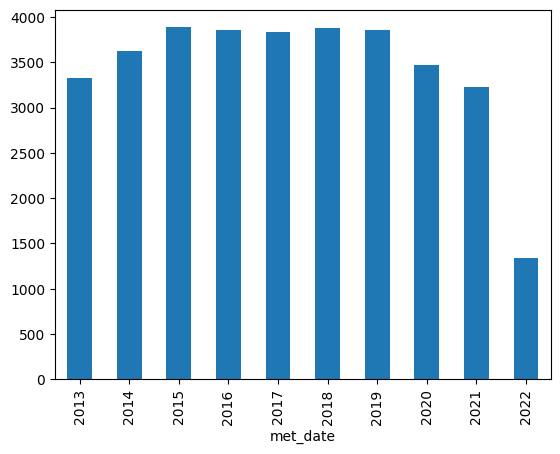

In [9]:
enhanced_met.groupby([enhanced_met['met_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='met_date'>

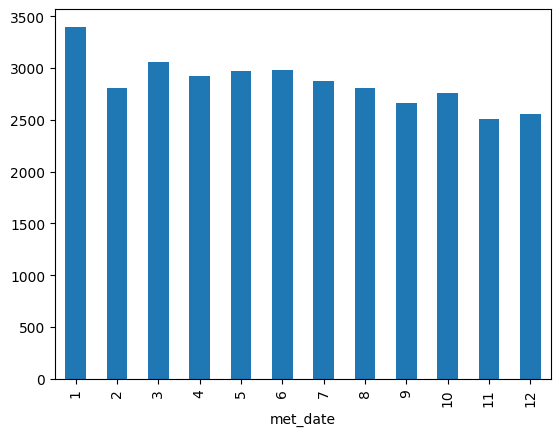

In [10]:
enhanced_met.groupby([enhanced_met['met_date'].dt.month])['PatientID'].count().plot(kind = 'bar')

In [11]:
enhanced_met['met_year_cat'] = pd.cut(enhanced_met['met_date'].dt.year,
                                      bins = [2012, 2014, 2016, 2018, 2020, 2022],
                                      labels = ['13-14', '15-16', '17-18', '19-20', '21-22'])

In [12]:
enhanced_met['met_year_cat'].value_counts(normalize = True, dropna = False)

15-16    0.225820
17-18    0.225004
19-20    0.213347
13-14    0.202827
21-22    0.133003
Name: met_year_cat, dtype: float64

<AxesSubplot:xlabel='met_year_cat'>

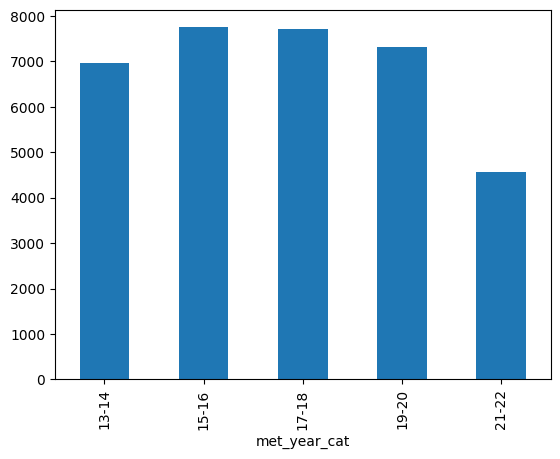

In [13]:
enhanced_met.groupby([enhanced_met['met_year_cat']])['PatientID'].count().plot(kind = 'bar')

In [14]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in sss.split(enhanced_met, enhanced_met['met_year_cat']):
    train_set = enhanced_met.iloc[train_index]
    test_set = enhanced_met.iloc[test_index]

In [15]:
train_set['met_year_cat'].value_counts()/len(train_set)

15-16    0.225812
17-18    0.225011
19-20    0.213354
13-14    0.202827
21-22    0.132996
Name: met_year_cat, dtype: float64

In [16]:
test_set['met_year_cat'].value_counts()/len(test_set)

15-16    0.225849
17-18    0.224975
19-20    0.213318
13-14    0.202827
21-22    0.133032
Name: met_year_cat, dtype: float64

In [17]:
row_ID(train_set)

(27452, 27452)

In [18]:
row_ID(test_set)

(6863, 6863)

In [19]:
# Array of PatientIDs in training set.
train_IDs = train_set['PatientID'].to_numpy()

In [20]:
pd.DataFrame(train_IDs, columns = ['PatientID']).to_csv('train_IDs.csv', index = False, header = True)

In [21]:
# Array of PatientIDs in test set.
test_IDs = test_set['PatientID'].to_numpy()

In [22]:
pd.DataFrame(test_IDs, columns = ['PatientID']).to_csv('test_IDs.csv', index = False, header = True)

In [23]:
%whos DataFrame

Variable       Type         Data/Info
-------------------------------------
enhanced_met   DataFrame               PatientID Diag<...>n[34315 rows x 6 columns]
test_set       DataFrame               PatientID Diag<...>\n[6863 rows x 6 columns]
train_set      DataFrame               PatientID Diag<...>n[27452 rows x 6 columns]


In [24]:
# Keep enhanced_met
del test_set
del train_set

## Part 2: Data wrangling

**Relevant CSV files will be imported and processed. A file is considered processed when each row corresponds to a unique patient from the training set and each column is a relevant variable for mortality prognositication. The eligibility window for collecting variables is typically defined as -90 days and +30 days from index date. The index date is time of metastatic diagnosis. Plus 30 was selected as the upper bound of the eligibility window given that median time to start of first line treatment is about 30 days from metastatic diagnosis.** 

**The following 12 CSV files from Flatiron will be cleaned:**
1. **Demographics**
2. **Practice**
3. **Enhanced_MetastaticCRC**
4. **Enhanced_Mortality_V2**
5. **MedicationAdministration**
6. **Enhanced_MetCRCBiomarkers**
7. **Insurance**
8. **ECOG**
9. **Vitals**
10. **Labs**
11. **Diagnosis**
12. **SocialDeeterminantsOfHealth**

### 1. Demographics

In [25]:
demographics = pd.read_csv('Demographics.csv')

In [26]:
demographics = demographics[demographics['PatientID'].isin(train_IDs)]

In [27]:
demographics.sample(5)

,PatientID,BirthYear,Gender,Race,Ethnicity,State
951,F6D264B7A62C6,1955,F,NaN,NaN,FL
1062,FFCD1A8710C2E,1984,F,White,Not Hispanic or Latino,CA
24383,F7F6D17825887,1970,F,White,Not Hispanic or Latino,KY
19966,F9B8AB8082C62,1970,M,White,Not Hispanic or Latino,NM
4548,FDF83188B0F4F,1946,M,White,NaN,ME


In [28]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27452 entries, 0 to 34314
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PatientID  27452 non-null  object
 1   BirthYear  27452 non-null  int64 
 2   Gender     27449 non-null  object
 3   Race       24629 non-null  object
 4   Ethnicity  22218 non-null  object
 5   State      22716 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


In [29]:
row_ID(demographics)

(27452, 27452)

#### Race and Ethnicity

In [30]:
demographics['Race'].value_counts(normalize = True, dropna = False)*100

White                        63.328719
Other Race                   12.250474
Black or African American    10.990092
NaN                          10.283404
Asian                         2.844966
Hispanic or Latino            0.302346
Name: Race, dtype: float64

In [31]:
demographics['Ethnicity'].value_counts(normalize = True, dropna = False)*100

Not Hispanic or Latino    72.719656
NaN                       19.066006
Hispanic or Latino         8.214338
Name: Ethnicity, dtype: float64

In [32]:
demographics.query('Ethnicity == "Hispanic or Latino"').sample(5)

,PatientID,BirthYear,Gender,Race,Ethnicity,State
13213,FA91428BA2A1A,1941,F,White,Hispanic or Latino,PR
9688,F7B1A9510E996,1964,F,Black or African American,Hispanic or Latino,PR
28524,F8DA7CFF0C5ED,1959,F,White,Hispanic or Latino,PR
12712,FC760784E7716,1939,F,Other Race,Hispanic or Latino,TX
15126,FFD0D6466B9D3,1937,M,White,Hispanic or Latino,PR


In [33]:
(
    demographics
    .query('Race == "Hispanic or Latino"')
    .query('Ethnicity != "Hispanic or Latino"')
)    

,PatientID,BirthYear,Gender,Race,Ethnicity,State
1702,F18CABC48B425,1961,F,Hispanic or Latino,Not Hispanic or Latino,CA
2108,F5E456FCA7263,1949,M,Hispanic or Latino,Not Hispanic or Latino,AZ
7183,F6C184F182A6A,1962,F,Hispanic or Latino,NaN,TN
9710,F5D2F664AE7D3,1963,M,Hispanic or Latino,NaN,TN
11832,FCBD7E4814E07,1954,F,Hispanic or Latino,NaN,CA
13582,F47163A7C8626,1952,F,Hispanic or Latino,NaN,CA
17400,FC6542E01FD6D,1953,M,Hispanic or Latino,NaN,TN
25049,F5F4157B9044A,1953,F,Hispanic or Latino,NaN,CA
29623,F3EF86A1D755E,1968,M,Hispanic or Latino,NaN,CA
29678,FCB8A5AC717D4,1956,M,Hispanic or Latino,NaN,AZ


**There are unexpected values where “Hispanic or Latino” appears as a race rather than ethnicity. Ethnicity will be recoded to align with the FDA standards for collecting race and ethnicity variables for clinical trials. Patients with a race value of “Hispanic or Latino” will have their race recoded as "Unknown" and ethnicity as “Hispanic or Latino.” Of note, ethnicity and race information is likely to be poorly captured since EHR platforms typically do not require documentation of race or ethnicity.**  

In [34]:
# If race value is 'Hispanic or Latino', code as unknown, otherwise value unchanged.
demographics['race'] = (
    np.where(demographics['Race'] == 'Hispanic or Latino', 'unknown', demographics['Race'])
)

In [35]:
# Missing race value will be recoded as Unknown
demographics['race'] = demographics['race'].fillna('unknown')

In [36]:
demographics['race'].value_counts().sum()

27452

In [37]:
demographics['race'].value_counts(normalize = True, dropna = False)*100

White                        63.328719
Other Race                   12.250474
Black or African American    10.990092
unknown                      10.585750
Asian                         2.844966
Name: race, dtype: float64

In [38]:
# If race value is equal to 'Hispanic or Latino', code ethnicity as 'Hispanic or Latino', otherwise unchanged. 
demographics['ethnicity'] = (
    np.where(demographics['Race'] == 'Hispanic or Latino', 'hispanic_latino', demographics['Ethnicity'])
)

In [39]:
demographics['ethnicity'] = demographics['ethnicity'].fillna('unknown')

In [40]:
demographics['ethnicity'] = demographics['ethnicity'].replace({'Hispanic or Latino': 'hispanic_latino'})

In [41]:
demographics['ethnicity'].value_counts(normalize = True, dropna = False)*100

Not Hispanic or Latino    72.712371
unknown                   19.029579
hispanic_latino            8.258050
Name: ethnicity, dtype: float64

In [42]:
(
    demographics
    .groupby(['ethnicity', 'race'])['PatientID'].count()
    .divide(len(demographics))
    .sort_values(ascending = False)
)

ethnicity               race                     
Not Hispanic or Latino  White                        0.536573
                        Black or African American    0.093217
unknown                 unknown                      0.072126
                        White                        0.066188
Not Hispanic or Latino  Other Race                   0.051836
hispanic_latino         Other Race                   0.037229
unknown                 Other Race                   0.033440
hispanic_latino         White                        0.030526
Not Hispanic or Latino  Asian                        0.023131
                        unknown                      0.022366
unknown                 Black or African American    0.013660
hispanic_latino         unknown                      0.011365
unknown                 Asian                        0.004881
hispanic_latino         Black or African American    0.003023
                        Asian                        0.000437
Name: PatientID, dty

In [43]:
demographics = demographics.drop(columns = ['Race', 'Ethnicity'])

#### BirthYear

In [44]:
demographics['BirthYear'].describe()

count    27452.000000
mean      1953.498434
std         12.559265
min       1937.000000
25%       1943.000000
50%       1952.000000
75%       1962.000000
max       2002.000000
Name: BirthYear, dtype: float64

array([[<AxesSubplot:title={'center':'BirthYear'}>]], dtype=object)

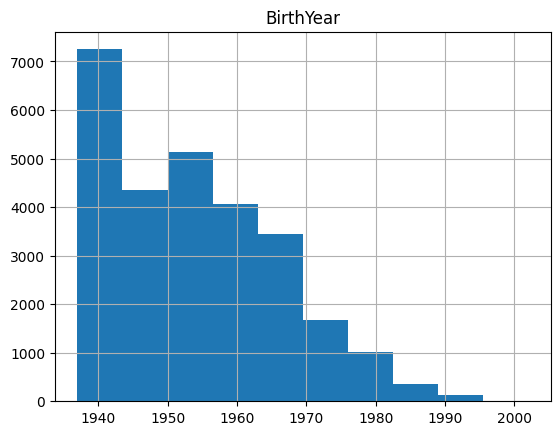

In [45]:
demographics.hist(column = 'BirthYear')

In [46]:
# Top 10 birth years.
demographics['BirthYear'].value_counts(normalize = True, dropna = False).head(10)

1937    0.139006
1947    0.029797
1948    0.028559
1946    0.028085
1957    0.028013
1956    0.027612
1950    0.027284
1952    0.026956
1949    0.026810
1953    0.026592
Name: BirthYear, dtype: float64

**Dispraportionate number of patients aged 85. Flatiron aggregates patients 85 and older into a single category of 85 years of age to limit potential for re-identification of older patients.**

In [47]:
demographics = pd.merge(demographics, enhanced_met[['PatientID', 'met_date']], on = 'PatientID')

In [48]:
demographics.loc[:, 'age'] = demographics['met_date'].dt.year - demographics['BirthYear']

In [49]:
demographics = demographics.drop(columns = ['BirthYear', 'met_date'])

#### PracticeType

In [50]:
practice = pd.read_csv('Practice.csv')

In [51]:
practice.sample(5)

,PatientID,PracticeID,PracticeType,PrimaryPhysicianID
32456,FF36F82D677EA,S291CF564BD92,COMMUNITY,T2B0912C0BD04
1028,FA9DF7C55D776,SB875B0336958,ACADEMIC,NaN
3278,F04ABB0135AF1,S3A7162E98AAC,COMMUNITY,T41B09A31AAE4
29391,F18838D70EFC1,S14DD2B48D72C,COMMUNITY,T8B3C9FDCC0BE
30936,FC6A088A77F2D,S291CF564BD92,COMMUNITY,TFEA982F311F0


In [52]:
practice = practice[practice['PatientID'].isin(train_IDs)]

In [53]:
row_ID(practice)

(28051, 27452)

In [54]:
practice_unique_count = (
    practice.groupby('PatientID')['PracticeType'].agg('nunique')
    .to_frame()
    .reset_index()
    .rename(columns = {'PracticeType': 'n_type'})
)

In [55]:
practice_n = pd.merge(practice, practice_unique_count, on = 'PatientID')

In [56]:
practice_n['p_type'] = (
    np.where(practice_n['n_type'] == 1, practice_n['PracticeType'], 'BOTH')
)

In [57]:
practice_n = (
    practice_n.drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'p_type'])
)

In [58]:
demographics = pd.merge(demographics, practice_n, on = 'PatientID')

In [59]:
demographics['p_type'].value_counts(normalize=True, dropna=False)*100

COMMUNITY    85.246977
ACADEMIC     13.813201
BOTH          0.939822
Name: p_type, dtype: float64

#### Gender

In [60]:
demographics['Gender'].value_counts(normalize = True, dropna = False)*100

M      55.088882
F      44.900189
NaN     0.010928
Name: Gender, dtype: float64

In [61]:
# Impute M as unknown given most common gender. 
demographics['Gender'] = demographics['Gender'].fillna('M')

In [62]:
demographics = demographics.rename(columns = {'Gender': 'gender'})

#### State

In [63]:
demographics['State'].isna().sum()

4736

In [64]:
demographics['State'].value_counts(normalize = True, dropna = False).head(20)

NaN    0.172519
TN     0.071507
CA     0.068847
FL     0.057846
AZ     0.057519
AL     0.051727
NY     0.046080
PA     0.043640
TX     0.041782
MI     0.039924
NJ     0.039378
VA     0.034788
PR     0.027211
OH     0.023423
MS     0.023386
OK     0.022148
IL     0.021638
GA     0.017922
WA     0.017776
IN     0.017121
Name: State, dtype: float64

**For de-identification reasons, State is nulled out for a few low-population states (e.g., AK, MT, ND, SD, VT, and WY). New variable will be created to group states into Census-Bureau regions for simplicity.** 

In [65]:
# Group states into Census-Bureau regions  
state_dict = { 
    'ME': 'northeast', 
    'NH': 'northeast',
    'VT': 'northeast', 
    'MA': 'northeast',
    'CT': 'northeast',
    'RI': 'northeast',  
    'NY': 'northeast', 
    'NJ': 'northeast', 
    'PA': 'northeast', 
    'IL': 'midwest', 
    'IN': 'midwest', 
    'MI': 'midwest', 
    'OH': 'midwest', 
    'WI': 'midwest',
    'IA': 'midwest',
    'KS': 'midwest',
    'MN': 'midwest',
    'MO': 'midwest', 
    'NE': 'midwest',
    'ND': 'midwest',
    'SD': 'midwest',
    'DE': 'south',
    'FL': 'south',
    'GA': 'south',
    'MD': 'south',
    'NC': 'south', 
    'SC': 'south',
    'VA': 'south',
    'DC': 'south',
    'WV': 'south',
    'AL': 'south',
    'KY': 'south',
    'MS': 'south',
    'TN': 'south',
    'AR': 'south',
    'LA': 'south',
    'OK': 'south',
    'TX': 'south',
    'AZ': 'west',
    'CO': 'west',
    'ID': 'west',
    'MT': 'west',
    'NV': 'west',
    'NM': 'west',
    'UT': 'west',
    'WY': 'west',
    'AK': 'west',
    'CA': 'west',
    'HI': 'west',
    'OR': 'west',
    'WA': 'west',
    'PR': 'unknown'
}

demographics['region'] = demographics['State'].map(state_dict)

In [66]:
demographics['region'] = demographics['region'].fillna('unknown')

In [67]:
demographics['region'].value_counts(normalize = True, dropna = False)

south        0.377277
unknown      0.199730
west         0.161919
northeast    0.141593
midwest      0.119481
Name: region, dtype: float64

In [68]:
demographics['region'].value_counts(dropna = False).sum()

27452

<AxesSubplot:xlabel='region'>

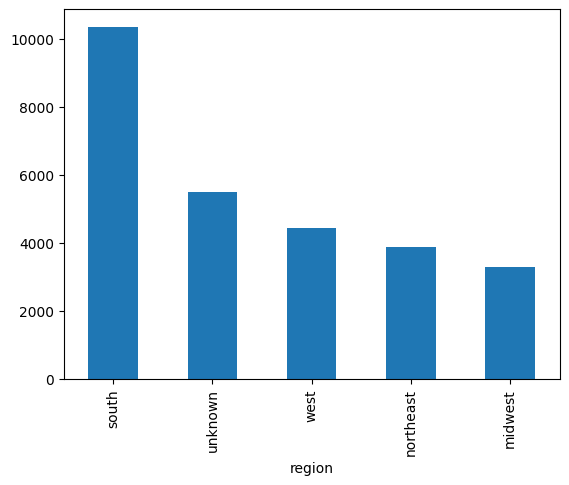

In [69]:
demographics.groupby('region')['PatientID'].count().sort_values(ascending = False).plot(kind = 'bar')

<AxesSubplot:xlabel='p_type,region'>

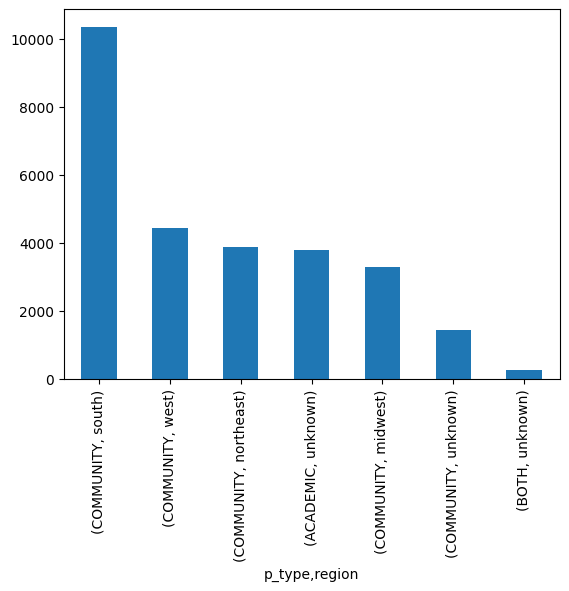

In [70]:
demographics.groupby(['p_type', 'region'])['PatientID'].count().sort_values(ascending = False).plot(kind = 'bar')

**Most patients come from community programs in the south. Interestingly, all academic patients are from an unknown region, likely for de-identification purposes.**

In [71]:
demographics = demographics.drop(columns = ['State'])

In [72]:
# Final training demographics table.
demographics.sample(5)

,PatientID,gender,race,ethnicity,age,p_type,region
23003,F7BCB27AF792D,M,Other Race,Not Hispanic or Latino,61,COMMUNITY,south
4119,F5978BC269E31,M,White,Not Hispanic or Latino,65,COMMUNITY,west
15102,F2FEB4B5D70B1,M,White,hispanic_latino,66,COMMUNITY,south
2135,F2D0069010DA1,M,White,Not Hispanic or Latino,54,COMMUNITY,south
2538,F0EC6DF16211B,F,White,Not Hispanic or Latino,79,COMMUNITY,northeast


In [73]:
%whos DataFrame

Variable                Type         Data/Info
----------------------------------------------
demographics            DataFrame               PatientID gend<...>n[27452 rows x 7 columns]
enhanced_met            DataFrame               PatientID Diag<...>n[34315 rows x 6 columns]
practice                DataFrame               PatientID     <...>n[28051 rows x 4 columns]
practice_n              DataFrame               PatientID     <...>n[27452 rows x 2 columns]
practice_unique_count   DataFrame               PatientID  n_t<...>n[27452 rows x 2 columns]


In [74]:
# Keep demographics and enhanced_met
del practice
del practice_n
del practice_unique_count

### 2. Enhanced_MetastaticCRC

In [75]:
enhanced_met.sample(5)

,PatientID,DiagnosisDate,met_date,GroupStage,CrcSite,met_year_cat
31822,F2700BA4CFCE1,2017-10-06,2017-10-06,IVA,Colon,17-18
4624,F2BF85D001C86,2009-11-25,2013-04-19,Unknown,Colon,13-14
26594,F9C894183D0FD,2013-11-20,2013-11-20,IVA,Colon,13-14
28861,F9F38AC64A69B,2016-10-23,2016-10-23,IVA,Colon,15-16
7420,FC0A0200EA2EE,2001-01-01,2018-03-27,Unknown,Colon,17-18


In [76]:
enhanced_met.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34315 entries, 0 to 34314
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PatientID      34315 non-null  object        
 1   DiagnosisDate  34277 non-null  object        
 2   met_date       34315 non-null  datetime64[ns]
 3   GroupStage     34315 non-null  object        
 4   CrcSite        34315 non-null  object        
 5   met_year_cat   34315 non-null  category      
dtypes: category(1), datetime64[ns](1), object(4)
memory usage: 1.3+ MB


In [77]:
enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(train_IDs)]

In [78]:
row_ID(enhanced_met)

(27452, 27452)

#### GroupStage 

In [79]:
enhanced_met.GroupStage.value_counts(dropna = False, normalize = True)

IV         0.211970
IVA        0.210586
IIIB       0.135400
IVB        0.120028
IIA        0.074275
IIIC       0.066625
Unknown    0.043239
III        0.030635
IVC        0.026883
I          0.026883
IIB        0.016028
IIIA       0.014498
II         0.014207
IIC        0.008633
0          0.000109
Name: GroupStage, dtype: float64

In [80]:
# Dictionary for regrouping stages
stage_dict = { 
    '0': '0',
    'I': 'I',
    'II': 'II',
    'IIA': 'II',
    'IIB': 'II',
    'IIC': 'II',
    'III': 'III',
    'IIIA': 'III',
    'IIIB': 'III',
    'IIIC': 'III',
    'IV': 'IV',
    'IVA': 'IV',
    'IVB': 'IV'
}

enhanced_met['stage'] = enhanced_met['GroupStage'].map(stage_dict)

In [81]:
enhanced_met['stage'] = enhanced_met['stage'].fillna('unknown')

In [82]:
enhanced_met['stage'].value_counts(normalize = True, dropna = False)

IV         0.542583
III        0.247159
II         0.113143
unknown    0.070122
I          0.026883
0          0.000109
Name: stage, dtype: float64

In [83]:
enhanced_met = enhanced_met.drop(columns = ['GroupStage'])

#### CRCSite

**Refer to Diagnosis section for further cleaning of variable.**

In [84]:
enhanced_met.CrcSite.value_counts(dropna = False, normalize = True)

Colon             0.734846
Rectum            0.240930
Colorectal NOS    0.024224
Name: CrcSite, dtype: float64

#### MetDiagnosisDate

In [85]:
enhanced_met['met_date'].min()

Timestamp('2013-01-01 00:00:00')

In [86]:
enhanced_met['met_date'].max()

Timestamp('2022-08-26 00:00:00')

In [87]:
enhanced_met['met_date'].dt.year.describe()

count    27452.000000
mean      2017.167310
std          2.643765
min       2013.000000
25%       2015.000000
50%       2017.000000
75%       2019.000000
max       2022.000000
Name: met_date, dtype: float64

In [88]:
enhanced_met.loc[:, 'met_year'] = enhanced_met['met_date'].dt.year

#### DiagnosisDate

In [89]:
enhanced_met['DiagnosisDate'].isna().sum()

35

In [90]:
enhanced_met = enhanced_met.rename(columns = {'DiagnosisDate': 'diagnosis_date'})

In [91]:
# Missing diagnosis_date will be replaced with met_date; other dates will be left untouched. 
enhanced_met['diagnosis_date'] = (
    np.where(enhanced_met['diagnosis_date'].isna(), enhanced_met['met_date'], enhanced_met['diagnosis_date'])
)

In [92]:
enhanced_met['diagnosis_date'] = pd.to_datetime(enhanced_met['diagnosis_date'])

In [93]:
enhanced_met['diagnosis_date'].min()

Timestamp('1980-01-01 00:00:00')

In [94]:
enhanced_met['diagnosis_date'].max()

Timestamp('2022-08-16 00:00:00')

In [95]:
enhanced_met['diagnosis_date'].dt.year.describe()

count    27452.000000
mean      2016.097334
std          3.461292
min       1980.000000
25%       2014.000000
50%       2016.000000
75%       2019.000000
max       2022.000000
Name: diagnosis_date, dtype: float64

<AxesSubplot:xlabel='diagnosis_date'>

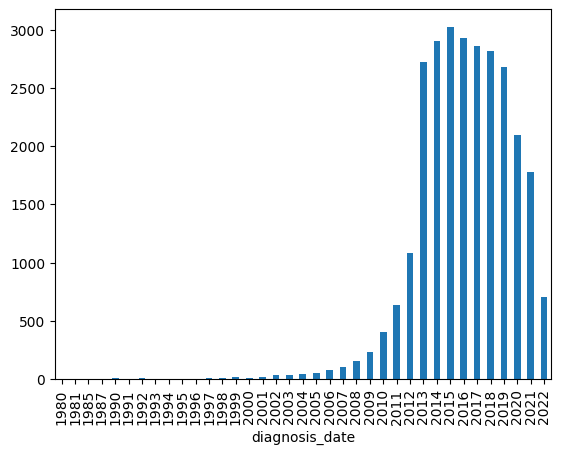

In [96]:
# Bar plot of number of new CRC diagnoses per year.
enhanced_met.groupby([enhanced_met['diagnosis_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

**The range of dates for diagnosis is 1/1979 to 6/2022 with a median year of 2016.** 

In [97]:
# Percent of patients diagnosed prior to metastatic diagnosis. 
(
    enhanced_met
    .query('diagnosis_date < met_date')
    .shape[0]/(len(enhanced_met))
)

0.428857642430424

#### Time from diagnosis date to metastatic date

In [98]:
enhanced_met.loc[:, 'delta_met_diagnosis'] = (enhanced_met['met_date'] - enhanced_met['diagnosis_date']).dt.days

In [99]:
# Brief summary statistics on time between diagnosis date and metastatic diagnosis.
(
    enhanced_met
    .query('delta_met_diagnosis > 0')
    .describe()
)

,met_year,delta_met_diagnosis
count,11773.000000,11773.000000
mean,2017.124777,913.645970
std,2.613865,1026.107497
min,2013.000000,2.000000
25%,2015.000000,336.000000
50%,2017.000000,615.000000
75%,2019.000000,1117.000000
max,2022.000000,14057.000000


In [100]:
# Final enhanced_met dataframe
enhanced_met.sample(5)

,PatientID,diagnosis_date,met_date,CrcSite,met_year_cat,stage,met_year,delta_met_diagnosis
2758,F221382226B57,2015-09-15,2016-08-09,Rectum,15-16,unknown,2016,329
15135,F7495C7797A90,2016-07-29,2016-07-29,Colon,15-16,IV,2016,0
32677,F0F547D2BE58D,2017-07-17,2017-07-17,Colon,17-18,IV,2017,0
28942,F8033BFED285D,2012-07-16,2015-12-31,Colon,15-16,III,2015,1263
4281,F899496C68A94,2015-02-13,2015-02-13,Colon,15-16,IV,2015,0


In [101]:
%whos DataFrame

Variable       Type         Data/Info
-------------------------------------
demographics   DataFrame               PatientID gend<...>n[27452 rows x 7 columns]
enhanced_met   DataFrame               PatientID diag<...>n[27452 rows x 8 columns]


### 3. Enhanced_Mortality_V2

In [102]:
mortality = pd.read_csv('Enhanced_Mortality_V2.csv')

In [103]:
mortality = mortality[mortality['PatientID'].isin(train_IDs)]

In [104]:
mortality.sample(5)

,PatientID,DateOfDeath
5036,F800BB85F9A6B,2018-09
3059,F7AF1F63AA852,2019-04
11556,F84942D2F5998,2014-04
3711,F50955B519010,2020-09
15288,F98F10872F7D1,2019-05


In [105]:
mortality.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17108 entries, 0 to 21343
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PatientID    17108 non-null  object
 1   DateOfDeath  17108 non-null  object
dtypes: object(2)
memory usage: 401.0+ KB


In [106]:
row_ID(mortality)

(17108, 17108)

In [107]:
mortality = mortality.rename(columns = {'DateOfDeath': 'death_date'})

In [108]:
# Patients with year granularity.
mortality[mortality['death_date'].str.len() == 4]

,PatientID,death_date
4494,F0E9F0C51319F,2016
5099,F1704047F2297,2017
7781,F18AA97EBDF4B,2016
7944,F657BDE880A95,2019
12667,F431DD050D99A,2015
13246,F598BB2B18B53,2019
13322,FAF05136D6590,2020
14324,F9E47279AD5E3,2019
15690,F3C0311B52E1D,2018
17855,F81889706D8F5,2018


**The date of death is generalized to the month for de-identification purposes, however, a small number of patients have just the year for date of death. For analyses requiring a day of death, Flatiron Health recommends imputing the 15th of the month since this approach best approximates the results generated from using the exact date of death. For those with a date of death with year granularity, Flatiron recommends imputing the middle of the year and conducting a sensitivty analysis to evaluate assumption.**

In [109]:
# For patients with year granularity, impute middle of the year (ie., July 1)
mortality['death_date'] = (
    np.where(mortality['death_date'].str.len() == 4, mortality['death_date'] + '-07-01', mortality['death_date'])
)

In [110]:
# For patients with month granularity, impute 15th of the month.
mortality['death_date'] = (
    np.where(mortality['death_date'].str.len() == 7, mortality['death_date'] + '-15', mortality['death_date'])
)

In [111]:
mortality['death_date'] = pd.to_datetime(mortality['death_date'])

In [112]:
# Percent of patients with death date.  
len(mortality)/len(train_IDs)

0.6231968526883287

<AxesSubplot:xlabel='death_date'>

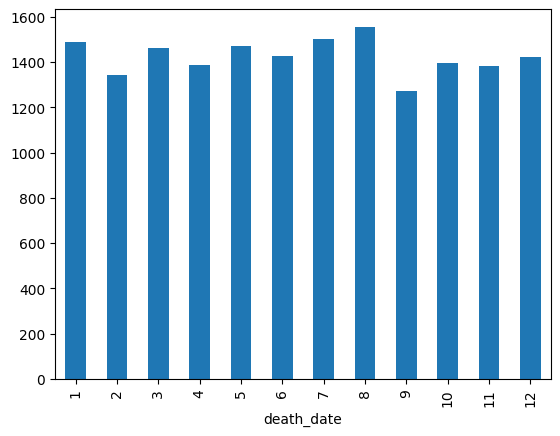

In [113]:
# Bar plot of monthly mortality for aNSCLC. 
mortality.groupby([mortality['death_date'].dt.month])['PatientID'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='death_date'>

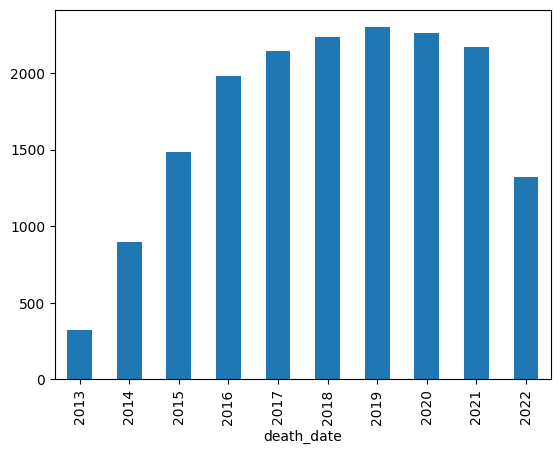

In [114]:
# Bar plot of yearly mortality for aNSCLC. 
mortality.groupby([mortality['death_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

#### Censoring

**For patients for whom a date of death is not known, the censor date can be defined either as the data cutoff date or as the last confirmed activity date. The last confirmed activity date is broadly defined as the last date at which there is evidence in the EHR that a patient is alive. Evidence of a record in at least one of the items listed below qualifies as patient-level confirmed activity:**
* **Visit: VisitDate**
* **Enhanced_MetCRC_Orals: StartDate or EndDate**
* **Enhanced_MetCRCBiomarkers: SpecimenCollectedDate**

In [115]:
visit = pd.read_csv('Visit.csv')
telemedicine = pd.read_csv('Telemedicine.csv')
orals = pd.read_csv('Enhanced_MetCRC_Orals.csv')
biomarkers = pd.read_csv('Enhanced_MetCRCBiomarkers.csv')

##### Visit and Telemedicine

In [116]:
visit.sample(5)

,PatientID,PracticeID,VisitDate,VisitType,IsVitalsVisit,IsTreatmentVisit,IsLabVisit
437534,F5C8D277612A0,S19210F786354,2020-04-09,Treatment,True,True,False
658524,F6C9059A7E4D3,S023BB12B855C,2014-02-10,Vitals,True,False,True
1596223,F40BD3D0AD5C7,S692FE6446C80,2015-12-01,Treatment,True,True,False
1679220,F4D7CAE9471AF,S291CF564BD92,2018-05-29,Vitals,True,False,True
779873,F38175C0F11E2,S3A7162E98AAC,2019-08-02,Treatment,False,True,False


In [117]:
visit.shape

(2010098, 7)

In [118]:
telemedicine.sample(5)

,PatientID,PracticeID,VisitDate
11399,F402464152D29,S044262E32626,2022-08-23
18055,F5749BE5050C2,S260DA7B3CE37,2022-04-21
19136,F561F850FD917,S291CF564BD92,2020-09-11
7390,FB0A18E14BB64,S87C279DB0C8A,2020-04-16
2037,FE93587D6E1FA,S0015D5ED587A,2020-10-20


In [119]:
telemedicine.shape

(23327, 3)

In [120]:
visit_tele = (
    visit
    .drop(columns = ['VisitType', 'IsVitalsVisit', 'IsTreatmentVisit', 'IsLabVisit'])
    .append(telemedicine)
) 

In [121]:
visit_tele.shape

(2033425, 3)

In [122]:
visit_tele.loc[:,'VisitDate'] = pd.to_datetime(visit_tele['VisitDate'])

In [123]:
visit_tele.sample(5)

,PatientID,PracticeID,VisitDate
541585,F8A4B5C08B0C2,S43F1EC350316,2022-02-28
395410,F35A7B36AFAC0,S19210F786354,2020-09-30
48572,F0A3B8A5ADF88,SBBCA1E6D01BA,2018-11-01
1586273,F315E026DB06E,S9580C013889E,2021-09-07
400237,FB91350CF28A4,S19210F786354,2018-09-18


In [124]:
# Select max VisitDate from combined Visit and Telemedicine table.
visit_tele_max = (
    visit_tele
    [visit_tele['PatientID'].isin(train_IDs)]
    .groupby('PatientID')['VisitDate'].max()
    .to_frame(name = 'visit_max')
    .reset_index()
)

In [125]:
row_ID(visit_tele_max)

(27452, 27452)

##### Orals

In [126]:
orals = orals[orals['PatientID'].isin(train_IDs)]

In [127]:
orals.loc[:, 'StartDate'] = pd.to_datetime(orals['StartDate'])

In [128]:
orals.loc[:, 'EndDate'] = pd.to_datetime(orals['EndDate'])

In [129]:
orals_max = (
    orals
    .assign(max_date = orals[['StartDate', 'EndDate']].max(axis = 1))
    .groupby('PatientID')['max_date'].max()
    .to_frame(name = 'orals_max')
    .reset_index()
)

##### Biomarkers

In [130]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(train_IDs)]

In [131]:
biomarkers.loc[:, 'SpecimenCollectedDate'] = pd.to_datetime(biomarkers['SpecimenCollectedDate'])

In [132]:
biomarkers_max = (
    biomarkers
    .groupby('PatientID')['SpecimenCollectedDate'].max()
    .to_frame(name = 'biomarkers_max')
    .reset_index()
)

##### Max date merge

In [133]:
last_activity = pd.merge(visit_tele_max, orals_max, on = 'PatientID', how = 'outer')

In [134]:
last_activity = pd.merge(last_activity, biomarkers_max, on = 'PatientID', how = 'outer')

In [135]:
row_ID(last_activity)

(27452, 27452)

In [136]:
last_activity.sample(5)

,PatientID,visit_max,orals_max,biomarkers_max
906,F089A98389423,2020-01-08,2020-01-08,NaT
10868,F64E3B9090B3C,2015-12-29,NaT,2015-03-04
12100,F7026900919A1,2017-09-06,2013-01-01,2013-06-20
23257,FD8C8D2BB639A,2022-08-26,NaT,NaT
24965,FE926E762BCA5,2020-10-14,2020-10-09,2020-04-22


In [137]:
# Find max of each row. 
last_activity = (
    last_activity
    .assign(last_activity = last_activity[['visit_max', 'orals_max', 'biomarkers_max']].max(axis = 1))
    .filter(items = ['PatientID', 'last_activity'])
)

In [138]:
# Append missing training IDs.
mortality = (
    mortality
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(mortality['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False
    )
)

In [139]:
row_ID(mortality)

(27452, 27452)

In [140]:
mortality = pd.merge(mortality, enhanced_met[['PatientID', 'met_date']], on = 'PatientID')

In [141]:
mortality = pd.merge(mortality, last_activity, on = 'PatientID')

In [142]:
row_ID(mortality)

(27452, 27452)

In [143]:
mortality.loc[:, 'death_status'] = np.where(mortality['death_date'].isna(), 0, 1)

In [144]:
# timerisk_activity is time from advanced disease diagnosis to death or last activity if no death date.
mortality.loc[:, 'timerisk_activity'] = (
    np.where(mortality['death_date'].isna(),
             (mortality['last_activity'] - mortality['met_date']).dt.days,
             (mortality['death_date'] - mortality['met_date']).dt.days)
)

In [145]:
# If timerisk_activity is less than 0, set to 0 otherwise remains unchanged. 
mortality['timerisk_activity'] = np.where(mortality['timerisk_activity'] < 0, 0, mortality['timerisk_activity'])

In [146]:
mortality.sample(5)

,PatientID,death_date,met_date,last_activity,death_status,timerisk_activity
17211,F0D66647D2CAB,NaT,2018-06-20,2018-06-27,0,7.0
12151,F012E441A7FF9,2021-11-15,2021-07-29,2021-11-09,1,109.0
347,FFD3DA232A1F8,2018-07-15,2017-09-05,2018-03-20,1,313.0
9804,F4375A5000D30,2016-07-15,2013-02-22,2016-06-08,1,1239.0
6614,F4EB2F04A5662,2019-03-15,2013-06-01,2015-04-15,1,2113.0


In [147]:
mortality.timerisk_activity.describe()

count    27452.000000
mean       687.089174
std        633.698793
min          0.000000
25%        213.000000
50%        503.000000
75%        962.000000
max       3529.000000
Name: timerisk_activity, dtype: float64

In [148]:
# Percent of patients censored overall. 
(mortality.shape[0] - mortality['death_status'].sum())/mortality.shape[0]

0.3768031473116713

In [149]:
# Percent of patients dying within 365 days. 
((mortality['death_status'] == 1) & (mortality['timerisk_activity'] <= 365)).sum()/mortality.shape[0]

0.24653941425032785

In [150]:
# Percent of patients dying within 720 days. 
((mortality['death_status'] == 1) & (mortality['timerisk_activity'] <= 720)).sum()/mortality.shape[0]

0.4139589100976249

Median survival in days: 744.0


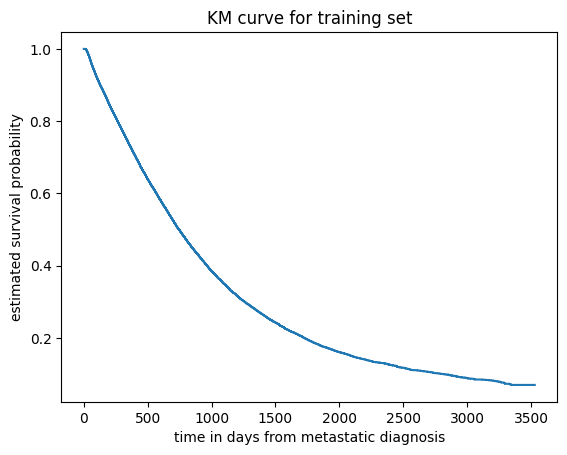

In [151]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

%matplotlib inline

time, survival_prob = kaplan_meier_estimator(mortality['death_status'].astype('bool'), mortality['timerisk_activity'])
plt.step(time, survival_prob, where = 'post')

plt.title('KM curve for training set')
plt.ylabel('estimated survival probability')
plt.xlabel('time in days from metastatic diagnosis')
print('Median survival in days:', time[np.where(survival_prob <0.5)][0])

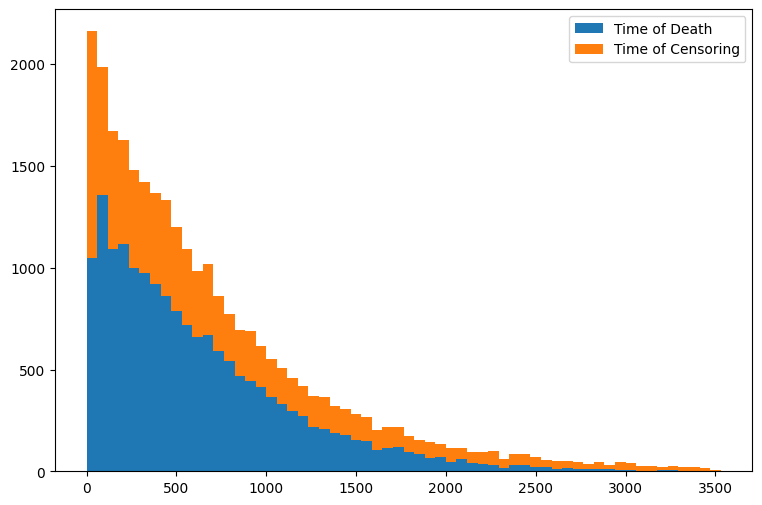

In [152]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((mortality['timerisk_activity'][mortality['death_status'].astype('bool')],
                               mortality['timerisk_activity'][~mortality['death_status'].astype('bool')]),
                              bins = 60, stacked = True)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

In [153]:
mortality = pd.merge(mortality, enhanced_met[['PatientID', 'diagnosis_date']], on = 'PatientID', how = 'outer')

In [154]:
# timerisk_activity_first is time from first diagnosis (metastatic or not) to death or last activity if no death date.
mortality.loc[:, 'timerisk_activity_first'] = (
    np.where(mortality['death_date'].isna(),
             (mortality['last_activity'] - mortality['diagnosis_date']).dt.days,
             (mortality['death_date'] - mortality['diagnosis_date']).dt.days)
)

In [155]:
# If timerisk_activity is less than 0, set to 0 otherwise remains unchanged. 
mortality['timerisk_activity_first'] = np.where(
    mortality['timerisk_activity_first'] < 0, 0, mortality['timerisk_activity_first'])

In [156]:
mortality.to_csv('mortality_cleaned_tr.csv', index = False, header = True)

In [157]:
mortality = mortality.filter(items = ['PatientID', 'death_status', 'timerisk_activity'])

In [158]:
mortality.sample(5)

,PatientID,death_status,timerisk_activity
17024,FD4D3DB6A9752,1,458.0
20327,F24ACFCC34214,0,3163.0
2288,F9E13F22B0B53,1,261.0
16996,FECA9421DEB9E,1,1475.0
14116,FD59BFDA0CE82,1,1265.0


In [159]:
%whos DataFrame

Variable         Type         Data/Info
---------------------------------------
biomarkers       DataFrame                PatientID Bio<...>[97310 rows x 15 columns]
biomarkers_max   DataFrame               PatientID biom<...>n[23476 rows x 2 columns]
demographics     DataFrame               PatientID gend<...>n[27452 rows x 7 columns]
enhanced_met     DataFrame               PatientID diag<...>n[27452 rows x 8 columns]
last_activity    DataFrame               PatientID last<...>n[27452 rows x 2 columns]
mortality        DataFrame               PatientID  dea<...>n[27452 rows x 3 columns]
orals            DataFrame               PatientID     <...>n[17979 rows x 5 columns]
orals_max        DataFrame               PatientID  ora<...>n[11949 rows x 2 columns]
telemedicine     DataFrame               PatientID     <...>n[23327 rows x 3 columns]
visit            DataFrame                 PatientID   <...>2010098 rows x 7 columns]
visit_tele       DataFrame               PatientID     <...>

In [160]:
# Keep demographics, enhanced_met, and mortality
del biomarkers
del biomarkers_max
del last_activity
del orals
del orals_max
del visit_tele
del visit_tele_max

### 4. MedicationAdministration

In [161]:
med_admin = pd.read_csv('MedicationAdministration.csv')

In [162]:
med_admin = med_admin[med_admin['PatientID'].isin(train_IDs)]

In [163]:
row_ID(med_admin)

(3465754, 22434)

In [164]:
med_admin.sample(5)

,PatientID,PracticeID,OrderID,DrugName,CommonDrugName,Route,DrugCategory,DetailedDrugCategory,AdministeredDate,AdministeredAmount,AdministeredUnits
728989,F377DC5ED487A,S507DCE5DD8C6,M512149D04803E4DF7C0C067D83FAF1A2,irinotecan hcl,irinotecan,Intravenous,antineoplastic,chemotherapy,2016-05-03,120.0,mg
844758,F332A952B6BB8,S507DCE5DD8C6,M88EE7B96D86D744877CD1461ACAA92BF,fluorouracil,fluorouracil,Intravenous,antineoplastic,chemotherapy,2016-06-29,700.0,mg
444659,F9E3AF21F7D77,SCC8EE4FB66C3,M42C40077191CAEDE126A4FBFE6E4F668,dexamethasone,dexamethasone,Oral,steroid,glucocorticoid,2022-06-29,12.0,mg
2893925,F3841072AB91E,SBA2549C29E0D,M1B6EF1E8BE263C5ED64CD4B767F40143,fluorouracil,fluorouracil,Intravenous,antineoplastic,chemotherapy,2017-07-03,680.0,mg
727428,F602C93885546,S507DCE5DD8C6,M2DE38A58BC2557D222B8EE83DA41AC8A,dexamethasone sodium phosphate,dexamethasone,Intravenous,steroid,glucocorticoid,2013-02-12,8.0,mg


**An indicator variable will be created for key medications (ie., steroids, opioids, other pain meds, antibiotics, anticoagulation, diabetic medicaitons, etc.) around time of metastatic diagnosis. The elgibility window is -90 days from metastatic diagnosis to first line of therapy or +30, whichever comes first. First line of therapy is included as an upper bound because steroids are frequently administered as part of treatment for chemotherapy induced-nausea, so steroids might inadvertently capture chemotherapy treatment if upper bound is set after first line of therapy.** 

In [165]:
med_admin.shape

(3465754, 11)

In [166]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [167]:
line_therapy = line_therapy[line_therapy['PatientID'].isin(med_admin['PatientID'])]

In [168]:
line_therapy_1 = (
    line_therapy 
    .query('LineNumber == 1 and IsMaintenanceTherapy == False')
)

In [169]:
# If patients have 2 first line therapies, select earliest
line_therapy_1 = line_therapy_1.drop_duplicates(subset = ['PatientID'], keep = 'first')

In [170]:
med_admin = pd.merge(med_admin, line_therapy_1[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [171]:
med_admin = pd.merge(med_admin, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [172]:
med_admin.loc[:, 'AdministeredDate'] = pd.to_datetime(med_admin['AdministeredDate'])

In [173]:
med_admin.loc[:, 'StartDate'] = pd.to_datetime(med_admin['StartDate'])

In [174]:
med_admin['AdministeredDate'].isna().sum()

0

In [175]:
# Median days from metastatic date to start of first line of therapy. 
(
    med_admin
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .assign(start_met_diff = lambda x: (x.StartDate - x.met_date).dt.days)
    .start_met_diff
    .median()
)

39.0

In [176]:
# New variable upper_bound which defines upper bound
# If no StartDate (ie., no treatment received), then upper bound +30 from metastatic diagnosis 
# If StartDate is greater than 30 days from metastatic diagnosis, then upper bound +30 from metastatic diagnosis
# If StartDate is less than or equal 30 from metastatic diagnosis, then upper bound is one day before StartDate
conditions = [
    (med_admin['StartDate'].isna()) | ((med_admin['StartDate'] - med_admin['met_date']).dt.days > 30),
    ((med_admin['StartDate'] - med_admin['met_date']).dt.days <= 30)]    

choices = [30, (med_admin['StartDate'] - med_admin['met_date']).dt.days - 1]
    
med_admin.loc[:, 'upper_bound'] = np.select(conditions, choices)

In [177]:
med_admin.loc[:, 'upper_bound_date'] = (
    np.where(med_admin['upper_bound'] != 30, 
             med_admin['StartDate'] - pd.DateOffset(days = 1), 
             med_admin['met_date'] + pd.DateOffset(days = 30))
)

In [178]:
# Select window of -90 days and from metastatic diagnosis and remove clinical study drug. 
med_admin_win = (
    med_admin
    [((med_admin['AdministeredDate'] - med_admin['met_date']).dt.days >= -90) &
    (med_admin['AdministeredDate'] <= med_admin['upper_bound_date']) &
    (med_admin['CommonDrugName'] != 'Clinical study drug')]
)

In [179]:
row_ID(med_admin_win)

(95685, 3829)

In [180]:
med_admin_win.DrugCategory.value_counts()

pain agent                      19159
solution-fluid                  16408
hematological agent             11300
antineoplastic                  10383
anti-infective                   9060
antiemetic                       7814
anesthetic                       6968
steroid                          4562
proton pump inhibitor            3564
antihyperglycemic                2127
antidepressant                   1522
cytoprotective                    986
hormone                           795
anticholinergic                   259
gout and hyperurecemia agent      183
bone therapy agent (bta)          172
antidote and reversal agent       118
hyperglycemic                     113
sedative agent                     96
immunosuppressive                  55
calcimimetic                       25
antithyroid agent                   9
endocrine                           5
targeted therapy                    2
Name: DrugCategory, dtype: int64

#### Antineoplastic 

In [181]:
# Select window before upper bound (ie., < 30 or day before first LOT). 
med_admin_win_chemo = (
    med_admin
    [med_admin['AdministeredDate'] < med_admin['met_date']]
)

In [182]:
(
    med_admin_win_chemo.query('DrugCategory == "antineoplastic"').DrugName.value_counts().head(20)
)

fluorouracil              66369
oxaliplatin               27871
leucovorin calcium        25136
levoleucovorin calcium     9486
bevacizumab                2614
irinotecan hcl             2089
Clinical study drug         985
bortezomib                  641
azacitidine                 494
rituximab                   489
cetuximab                   477
cyclophosphamide            429
leuprolide acetate          428
paclitaxel                  417
carboplatin                 320
levoleucovorin              290
capecitabine                286
trastuzumab                 269
carfilzomib                 222
panitumumab                 214
Name: DrugName, dtype: int64

In [183]:
(
    med_admin_win_chemo
    [(med_admin_win_chemo['DrugName'] == 'fluorouracil') |  
     (med_admin_win_chemo['DrugName'] == 'oxaliplatin') |
     (med_admin_win_chemo['DrugName'] == 'capecitabine')]
    .groupby(['DrugName'])['PatientID'].count()
    .sort_values(ascending = False)
)

DrugName
fluorouracil    66369
oxaliplatin     27871
capecitabine      286
Name: PatientID, dtype: int64

In [184]:
med_admin_win_chemo.loc[:, 'adjuv'] = (
    np.where((med_admin_win_chemo['DrugName'] == 'fluorouracil') | 
             (med_admin_win_chemo['DrugName'] == 'oxaliplatin') | 
             (med_admin_win_chemo['DrugName'] == 'capecitabine'), 1, 0)
)

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [185]:
(
    med_admin_win_chemo.query('adjuv == 1')
    .assign(delta = lambda x: (x.met_date - x.AdministeredDate).dt.days)
    .groupby('PatientID')['delta'].mean().describe() 
)

count    4118.000000
mean      535.808762
std       527.980047
min         1.000000
25%       188.503571
50%       382.083333
75%       705.913182
max      6040.714286
Name: delta, dtype: float64

In [186]:
med_admin_win_chemo.query('adjuv == 1').PatientID.nunique()

4118

In [187]:
enhanced_met[enhanced_met['PatientID'].isin(med_admin_win_chemo.query('adjuv == 1').PatientID)].stage.value_counts(normalize = True)

III        0.761778
II         0.168528
unknown    0.044682
I          0.020155
IV         0.004857
Name: stage, dtype: float64

In [188]:
# Among those that were diagnosed prior to metastatic disease, the percentage of patients that were flagged as having receiving adjuvant therapy...
med_admin_win_chemo.query('adjuv == 1').PatientID.nunique()/len(enhanced_met.query('stage != "IV"'))

0.3279445727482679

In [189]:
med_admin_adjuv = (
    med_admin_win_chemo
    .query('adjuv == 1')
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'adjuv']]
)

#### Antiemetic

In [190]:
(
    med_admin_win
    .query('DrugCategory == "antiemetic"')
    .CommonDrugName
    .value_counts(normalize = True)
    .head(20)
)

ondansetron                   0.453673
palonosetron                  0.243409
granisetron                   0.060788
fosaprepitant                 0.058613
metoclopramide                0.047735
prochlorperazine              0.038777
aprepitant                    0.034297
olanzapine                    0.016637
dronabinol                    0.012030
scopolamine                   0.011774
promethazine                  0.009854
dimenhydrinate                0.004095
netupitant/palonosetron       0.003967
fosnetupitant/palonosetron    0.002943
meclizine                     0.000768
rolapitant                    0.000640
Name: CommonDrugName, dtype: float64

#### Solution-fluid

In [191]:
(
    med_admin_win
    .query('DrugCategory == "solution-fluid"')
    .CommonDrugName
    .value_counts(normalize = True)
)

sodium/saline preparations                     0.653096
electrolyte maintenance                        0.212701
iv solutions: dextrose-saline                  0.050341
iv solutions: dextrose-water                   0.050280
sodium chloride irrigating solution            0.022428
iv solutions: dextrose and lactated ringers    0.006887
water for irrigation, sterile                  0.004266
Name: CommonDrugName, dtype: float64

#### Steroid

In [192]:
(
    med_admin_win
    .query('DrugCategory == "steroid"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName               Route         
dexamethasone                Intravenous       3122
                             Oral               528
methylprednisolone           Intravenous        187
prednisone                   Oral               165
hydrocortisone               Intravenous        141
budesonide                   Inhalation          57
fludrocortisone              Oral                52
dexamethasone                Intrajejunal        42
betamethasone                Topical             41
mometasone furoate           Inhalation          37
hydrocortisone               Oral                26
prednisolone                 Ophthalmic          25
hydrocortisone               Topical             23
triamcinolone                Topical             17
clobetasol                   Topical             13
hydrocortisone               Rectal               7
budesonide                   Oral                 6
difluprednate                Ophthalmic           4
beclomethasone      

**Clinically relevant so will create glucocorticoid indicator variable. Hopefully by setting an upper bound of first line we are minimizing capturing those that received steroids for chemotherapy induced nausea.** 

In [193]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'steroid') & 
     ((med_admin_win['Route'] == 'Intravenous') | 
     (med_admin_win['Route'] == 'Oral') | 
     (med_admin_win['Route'] == 'Intrajejunal'))]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName      Route       
dexamethasone       Intravenous     3122
                    Oral             528
methylprednisolone  Intravenous      187
prednisone          Oral             165
hydrocortisone      Intravenous      141
fludrocortisone     Oral              52
dexamethasone       Intrajejunal      42
hydrocortisone      Oral              26
budesonide          Oral               6
methylprednisolone  Oral               1
Name: PatientID, dtype: int64

In [194]:
med_admin_win.loc[:, 'steroid_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'steroid') & 
             ((med_admin_win['Route'] == 'Intravenous') | 
              (med_admin_win['Route'] == 'Oral') | 
              (med_admin_win['Route'] == 'Intrajejunal')), 1, 0)
)

#### Pain

In [195]:
(
    med_admin_win
    .query('DrugCategory == "pain agent"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending=False)
    .head(20)
)

CommonDrugName                                 Route       
hydromorphone                                  Intravenous     2818
oxycodone                                      Oral            2583
acetaminophen                                  Oral            2071
morphine                                       Intravenous     1845
gabapentin                                     Oral             941
acetaminophen                                  Intravenous      841
ketorolac                                      Intravenous      728
lidocaine                                      Transdermal      703
morphine                                       Oral             551
lidocaine                                      Intravenous      446
hydromorphone                                  Oral             409
tramadol                                       Oral             409
bupivacaine/fentanyl/sodium replacement 0.9 %  Epidural         391
acetaminophen/oxycodone                        Oral     

**Three indicator variables from 'pain agent' category will be created:
- **opioid PO: patient recieved oral opioid (fentanyl patch included)**
- **non-opioid PO: patient received non-opioid orally**
- **pain IV: patient received pain medciation intravenously**

##### Opioid PO

In [196]:
# List of avialable opioids in the US. 
opioid_list = [
    'buprenorphine',
    'codeine',
    'fentanyl',
    'hydrocodone',
    'hydromorphone',
    'methadone',
    'morphine',
    'oxycodone',
    'oxymorphone',
    'tapentadol',
    'tramadol'
]

In [197]:
(
    med_admin_win
    [((med_admin_win['Route'] == 'Oral') | 
      (med_admin_win['Route'] == 'Transdermal') | 
      (med_admin_win['Route'] == 'Sublingual')) &
     (med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list)))]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName             Route      
oxycodone                  Oral           2583
morphine                   Oral            551
hydromorphone              Oral            409
tramadol                   Oral            409
acetaminophen/oxycodone    Oral            363
acetaminophen/hydrocodone  Oral            105
fentanyl                   Transdermal      92
methadone                  Oral             71
acetaminophen/codeine      Oral             63
fentanyl                   Sublingual        7
tapentadol                 Oral              3
Name: PatientID, dtype: int64

In [198]:
med_admin_win.loc[:, 'opioid_PO_diag'] = (
    np.where(((med_admin_win['Route'] == 'Oral') | 
              (med_admin_win['Route'] == 'Transdermal') | 
              (med_admin_win['Route'] == 'Sublingual')) &
             (med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list))), 1, 0)
)

##### Nonopioid PO

In [199]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'pain agent') & 
     (med_admin_win['Route'] == 'Oral') & 
     (~med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list)))]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName                     Route
acetaminophen                      Oral     2071
gabapentin                         Oral      941
ibuprofen                          Oral      287
pregabalin                         Oral      160
alvimopan                          Oral      148
salicylates                        Oral      147
baclofen                           Oral       72
celecoxib                          Oral       68
cyclobenzaprine                    Oral       64
clonidine                          Oral       53
benzocaine/menthol                 Oral       52
phenol                             Oral       40
methocarbamol                      Oral       32
naproxen                           Oral       18
lidocaine                          Oral       15
naloxegol                          Oral       14
tizanidine                         Oral        9
indomethacin                       Oral        7
benzocaine                         Oral        6
nabumetone                  

In [200]:
med_admin_win.loc[:, 'nonopioid_PO_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'pain agent') & 
             (med_admin_win['Route'] == 'Oral') & 
             (~med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list))), 1, 0)
)

##### Pain IV

In [201]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'pain agent') & (med_admin_win['Route'] == 'Intravenous')]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName         Route      
hydromorphone          Intravenous    2818
morphine               Intravenous    1845
acetaminophen          Intravenous     841
ketorolac              Intravenous     728
lidocaine              Intravenous     446
fentanyl               Intravenous     256
methocarbamol          Intravenous      94
meperidine             Intravenous      23
nalbuphine             Intravenous      10
belimumab              Intravenous       4
alfentanil             Intravenous       3
droperidol             Intravenous       2
methadone              Intravenous       2
epinephrine/lidocaine  Intravenous       1
Name: PatientID, dtype: int64

In [202]:
med_admin_win.loc[:, 'pain_IV_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'pain agent') & 
             (med_admin_win['Route'] == 'Intravenous'), 1, 0)
)

#### Hematologic agent

In [203]:
(
    med_admin_win
    [med_admin_win['DrugCategory'] == 'hematological agent']
    .CommonDrugName
    .value_counts()
    .head(20)
)

heparin (porcine)       5926
enoxaparin              1906
aspirin                  808
pegfilgrastim            431
albumin human            284
epoetin alfa             216
dalteparin,porcine       187
clopidogrel              181
alteplase                179
filgrastim-sndz          169
filgrastim               159
apixaban                 157
darbepoetin alfa         113
warfarin                  99
rivaroxaban               85
ticagrelor                59
epoetin alfa-epbx         40
aspirin/dipyridamole      38
tbo-filgrastim            31
pegfilgrastim-cbqv        30
Name: CommonDrugName, dtype: int64

**A therapeutic anticoagulation indicator variable will be created from the hematological agent category and will consist of:** 
* **Heparin: patients on a heparin gtt or other pareneral agents (eg., bivilrudin or argatroban)**
* **Enoxaparin: patients administered greater than prophylactic dosing of enoxaparin or other subcutaneous agents (eg., dalteparin or fondaparinux)**
* **DOAC: patients administered any dose of apxiaban, rivaroxabn, edoxaban, or dabigatran**
* **Warfarin: patients administered any dose of warfarin.**  

##### Heparin and other parenteral agents

In [204]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('heparin')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(20)
)

5000.0    0.612072
500.0     0.140664
5.0       0.068126
7500.0    0.020120
30.0      0.020120
60.0      0.017296
18.0      0.012001
16.0      0.007236
100.0     0.007060
12.0      0.006001
15.0      0.005648
1000.0    0.004765
20.0      0.004589
22.0      0.004236
17.0      0.004059
2500.0    0.003706
19.0      0.003353
10.0      0.003000
3.0       0.003000
14.0      0.003000
Name: AdministeredAmount, dtype: float64

**About 75% of administered doses of heparin are either 5000 or 500 units, likely reflecting prophylacitc dosing and catheter lock therapy, respectively. Doses in the teens likely indicate heparin gtt doses.** 

In [205]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('heparin')) & (med_admin_win['AdministeredAmount'] == 5000)]
    .Route
    .value_counts(normalize = True)
)

Subcutaneous           0.994515
Intravenous            0.004908
Other/Miscellaneous    0.000577
Name: Route, dtype: float64

In [206]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('heparin')) & (med_admin_win['AdministeredAmount'] == 500)]
    .Route
    .value_counts(normalize = True)
)

Intravenous            0.615287
Intrajejunal           0.378344
Other/Miscellaneous    0.006369
Name: Route, dtype: float64

In [207]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('heparin')) & (med_admin_win['AdministeredUnits'] == 'unit/kg/hr')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(10)
)

18.0    0.175258
16.0    0.105670
12.0    0.087629
15.0    0.082474
20.0    0.067010
22.0    0.061856
17.0    0.059278
19.0    0.048969
14.0    0.043814
24.0    0.041237
Name: AdministeredAmount, dtype: float64

In [208]:
# Total number of instances of a patient receiving heparin, bivalrudin, or argatroban drip
(
    med_admin_win
    [((med_admin_win['CommonDrugName'].str.contains('heparin')) & 
      (med_admin_win['AdministeredUnits'] == 'unit/kg/hr')) | 
     (med_admin_win['CommonDrugName'].str.contains('bivalirudin')) | 
     (med_admin_win['CommonDrugName'].str.contains('argatroban'))]
    .groupby(['CommonDrugName', 'AdministeredUnits'])['PatientID'].count()
    .sort_values(ascending = False)
 )

CommonDrugName     AdministeredUnits
heparin (porcine)  unit/kg/hr           393
bivalirudin        mg/kg/hr              17
argatroban         mcg/kg/min             1
Name: PatientID, dtype: int64

In [209]:
med_admin_win.loc[:, 'heparin_diag'] = (
    np.where(((med_admin_win['CommonDrugName'].str.contains('heparin')) & 
              (med_admin_win['AdministeredUnits'] == 'unit/kg/hr')) | 
             (med_admin_win['CommonDrugName'].str.contains('bivalirudin')) | 
             (med_admin_win['CommonDrugName'].str.contains('argatroban')), 1, 0)
)

###### Enoxaparin and other subcutaneous agents 

In [210]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('enoxaparin')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(10)
)

40.0     0.543548
30.0     0.198925
80.0     0.069355
120.0    0.041935
100.0    0.037097
60.0     0.034409
70.0     0.018817
50.0     0.013978
75.0     0.013978
150.0    0.010753
Name: AdministeredAmount, dtype: float64

**Doses of 40 or 30 likley reflect prophylactic VTE dosing and are less clinically relevant than higher doses.** 

In [211]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('dalteparin')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(10)
)

5000.0    0.962567
2500.0    0.037433
Name: AdministeredAmount, dtype: float64

**Dose of 5,000 or less likley reflects prophylactic VTE dosing and is less clinically relevant than higher doses.** 

In [212]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('fondaparinux')]
    .AdministeredAmount
    .value_counts(normalize = True)
)

7.5     0.653846
2.5     0.230769
10.0    0.115385
Name: AdministeredAmount, dtype: float64

**Dose of 2.5 likley reflects prophylactic VTE dosing and is less clinically relevant than higher doses.** 

In [213]:
(
    med_admin_win
    [((med_admin_win['CommonDrugName'].str.contains('enoxaparin')) & 
      (med_admin_win['AdministeredAmount'] > 40)) | 
     ((med_admin_win['CommonDrugName'].str.contains('dalteparin')) & 
      (med_admin_win['AdministeredAmount'] > 5000)) | 
     ((med_admin_win['CommonDrugName'].str.contains('fondaparinux')) & 
      (med_admin_win['AdministeredAmount'] > 2.5))]
    .groupby(['CommonDrugName', 'AdministeredAmount'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName  AdministeredAmount
enoxaparin      80.0                  129
                120.0                  78
                100.0                  69
                60.0                   64
                70.0                   35
                50.0                   26
                75.0                   26
                150.0                  20
                90.0                   17
fondaparinux    7.5                    17
enoxaparin      160.0                   7
                140.0                   6
fondaparinux    10.0                    3
enoxaparin      45.0                    1
                130.0                   1
Name: PatientID, dtype: int64

In [214]:
med_admin_win.loc[:, 'enoxaparin_diag'] = (
    np.where(((med_admin_win['CommonDrugName'].str.contains('enoxaparin')) & 
              (med_admin_win['AdministeredAmount'] > 40)) | 
             ((med_admin_win['CommonDrugName'].str.contains('dalteparin')) & 
              (med_admin_win['AdministeredAmount'] > 5000)) | 
             ((med_admin_win['CommonDrugName'].str.contains('fondaparinux')) & 
              (med_admin_win['AdministeredAmount'] > 2.5)), 1, 0)
)

##### DOAC

In [215]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('apixaban')) | 
     (med_admin_win['CommonDrugName'].str.contains('rivaroxaban')) | 
     (med_admin_win['CommonDrugName'].str.contains('dabigatran')) | 
     (med_admin_win['CommonDrugName'].str.contains('edoxaban'))]
    .CommonDrugName
    .value_counts()
)

apixaban                157
rivaroxaban              85
dabigatran etexilate      6
Name: CommonDrugName, dtype: int64

In [216]:
med_admin_win.loc[:, 'doac_diag'] = (
    np.where((med_admin_win['CommonDrugName'].str.contains('apixaban')) | 
             (med_admin_win['CommonDrugName'].str.contains('rivaroxaban')) | 
             (med_admin_win['CommonDrugName'].str.contains('dabigatran')) | 
             (med_admin_win['CommonDrugName'].str.contains('edoxaban')), 1, 0)
)

##### Warfarin

In [217]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('warfarin'))]
    .AdministeredAmount
    .value_counts()
)

5.0     42
2.5     29
2.0     10
10.0     6
4.0      5
1.0      2
3.0      2
15.0     1
Name: AdministeredAmount, dtype: int64

In [218]:
med_admin_win.loc[:, 'warfarin_diag'] = np.where((med_admin_win['CommonDrugName'].str.contains('warfarin')), 1, 0)

##### Anticoagulation merge 

In [219]:
# Combine heparin, enoxparin, DOAC, and warfarin columns into a single anticoagulation indicator variable. 
med_admin_win['ac_diag'] = (
    med_admin_win['heparin_diag'] + med_admin_win['enoxaparin_diag'] + med_admin_win['doac_diag'] + med_admin_win['warfarin_diag']
)

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [220]:
# Drop heparin, enoxaparin, DOAC, and warfarin columns. 
med_admin_win = med_admin_win.drop(columns = ['heparin_diag', 'enoxaparin_diag', 'doac_diag', 'warfarin_diag'])

##### DAPT

In [221]:
# Create dataframe containing patients who received aspirin or clopidogrel. 
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('aspirin')) | 
     (med_admin_win['CommonDrugName'].str.contains('clopidogrel')) | 
     (med_admin_win['CommonDrugName'].str.contains('ticagrelor')) | 
     (med_admin_win['CommonDrugName'].str.contains('prasugrel'))]
    .drop_duplicates(subset = ['PatientID', 'CommonDrugName'], keep = 'first')
    .groupby('PatientID')['PatientID'].count()
    .to_frame(name = 'dapt')
    .query('dapt == 2')
    .count()
)

dapt    17
dtype: int64

**Considering such a small number of patients are receiving DAPT, no variable created.** 

##### GCSF

In [222]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('filgrastim')]
    .CommonDrugName
    .value_counts()
)

pegfilgrastim         431
filgrastim-sndz       169
filgrastim            159
tbo-filgrastim         31
pegfilgrastim-cbqv     30
pegfilgrastim-jmdb     13
pegfilgrastim-bmez     10
filgrastim-aafi         8
pegfilgrastim-apgf      2
Name: CommonDrugName, dtype: int64

##### Epoetin

In [223]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('epoetin')]
    .CommonDrugName
    .value_counts()
)

epoetin alfa         216
darbepoetin alfa     113
epoetin alfa-epbx     40
Name: CommonDrugName, dtype: int64

**Both GCSF and epotein likely reflec chemotherapy toxicity and so will not be coded.** 

##### tPA

In [224]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('alteplase')]
    .groupby(['AdministeredAmount', 'Route'])['PatientID'].count()
    .sort_values (ascending = False)
)

AdministeredAmount  Route              
2.0                 Intravenous            82
                    Other/Miscellaneous    48
1.0                 Intravenous            11
                    Other/Miscellaneous    10
2.2                 Intravenous             4
4.0                 Intravenous             2
2.0                 Intrajejunal            1
4.0                 Intrajejunal            1
6.0                 Intrajejunal            1
Name: PatientID, dtype: int64

**No indicator variable created since doses received are for catheter clearance rather than for acute ischemic stroke or pulmonary embolism.** 

In [225]:
med_admin_win.DrugCategory.value_counts()

pain agent                      19159
solution-fluid                  16408
hematological agent             11300
antineoplastic                  10383
anti-infective                   9060
antiemetic                       7814
anesthetic                       6968
steroid                          4562
proton pump inhibitor            3564
antihyperglycemic                2127
antidepressant                   1522
cytoprotective                    986
hormone                           795
anticholinergic                   259
gout and hyperurecemia agent      183
bone therapy agent (bta)          172
antidote and reversal agent       118
hyperglycemic                     113
sedative agent                     96
immunosuppressive                  55
calcimimetic                       25
antithyroid agent                   9
endocrine                           5
targeted therapy                    2
Name: DrugCategory, dtype: int64

#### Anti-infective 

In [226]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'anti-infective')] 
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName                                 Route      
metronidazole                                  Intravenous    1258
cefazolin                                      Intravenous    1178
piperacillin/tazobactam                        Intravenous     790
ceftriaxone                                    Intravenous     719
vancomycin                                     Intravenous     637
dextrose, iso-osmotic/piperacillin/tazobactam  Intravenous     348
metronidazole                                  Oral            296
nystatin                                       Topical         285
cefepime                                       Intravenous     258
ampicillin/sulbactam                           Intravenous     212
ciprofloxacin                                  Intravenous     204
nystatin                                       Oral            175
amoxicillin/clavulanic acid                    Oral            137
ciprofloxacin                                  Oral            136
van

**Clinically relevant; two separate indicator variables from the anti-infective drug category will be created:** 
* **antiinfective IV group** 
* **antiinfective PO group**

##### Anti-infective IV

In [227]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'anti-infective') & 
     (med_admin_win['Route'] == 'Intravenous')]
    .CommonDrugName
    .value_counts(normalize = True)
    .head(20)
)

metronidazole                                    0.195281
cefazolin                                        0.182862
piperacillin/tazobactam                          0.122633
ceftriaxone                                      0.111611
vancomycin                                       0.098882
dextrose, iso-osmotic/piperacillin/tazobactam    0.054020
cefepime                                         0.040050
ampicillin/sulbactam                             0.032909
ciprofloxacin                                    0.031667
levofloxacin                                     0.016765
ceftazidime                                      0.016144
meropenem                                        0.014747
cefoxitin                                        0.014747
fluconazole                                      0.013039
clindamycin                                      0.007762
ertapenem                                        0.006520
cefuroxime                                       0.006054
caspofungin   

**This group consists mainly of antibacterials. Antifungals and antivirals are also included.** 

In [228]:
med_admin_win.loc[:, 'antiinfective_IV_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'anti-infective') & 
             (med_admin_win['Route'] == 'Intravenous'), 1, 0)
)

##### Anti-infective PO

In [229]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'anti-infective') & 
     (med_admin_win['Route'] == 'Oral')]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName                 Route
metronidazole                  Oral     296
nystatin                       Oral     175
amoxicillin/clavulanic acid    Oral     137
ciprofloxacin                  Oral     136
vancomycin                     Oral     122
fluconazole                    Oral     100
acyclovir                      Oral      88
sulfamethoxazole/trimethoprim  Oral      70
levofloxacin                   Oral      70
doxycycline                    Oral      66
amoxicillin                    Oral      42
neomycin                       Oral      39
erythromycin base              Oral      37
cephalexin                     Oral      35
clarithromycin                 Oral      32
cefuroxime                     Oral      30
dapsone                        Oral      15
clindamycin                    Oral      15
moxifloxacin                   Oral      15
oseltamivir                    Oral      14
Name: PatientID, dtype: int64

In [230]:
med_admin_win.loc[:, 'antiinfective_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'anti-infective') & 
             (med_admin_win['Route'] == 'Oral'), 1, 0)
)

#### Anesthetic

In [231]:
(
    med_admin_win
    .query('DrugCategory == "anesthetic"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName       Route        
fentanyl             Intravenous      2665
propofol             Intravenous      2385
midazolam            Intravenous      1450
ketamine             Intravenous       139
remifentanil         Intravenous       112
etomidate            Intravenous        26
fentanyl             Buccal             17
sufentanil           Epidural           14
                     Intravenous        13
fentanyl             Sublingual          4
midazolam            Intramuscular       4
                     Oral                2
droperidol/fentanyl  Intravenous         1
fentanyl             Epidural            1
Name: PatientID, dtype: int64

**Most likely capturing patients undergoing biopsy for new advanced diagnosis. Unclear prognostic value so no indicator variable created.** 

#### Cytoprotective

In [232]:
(
    med_admin_win
    .query('DrugCategory == "cytoprotective"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName            Route        
folic acid                Oral             390
vitamin b12 preparations  Intramuscular    313
                          Oral             106
                          Subcutaneous      88
folic acid                Intravenous       37
                          enteral           12
urate oxidase             Intravenous        6
folic acid                Nasogastric        5
                          Subcutaneous       5
vitamin b12 preparations  Intrajejunal       4
Name: PatientID, dtype: int64

#### Antihyperglycemic

In [233]:
(
    med_admin_win
    .query('DrugCategory == "antihyperglycemic"')
    .CommonDrugName
    .value_counts(normalize = True)
)

insulin lispro                            0.406206
insulin regular                           0.357781
insulin glargine                          0.125059
metformin                                 0.034791
insulin isophane (nph)                    0.023507
glipizide                                 0.018336
linagliptin                               0.014104
sitagliptin                               0.013164
insulin detemir                           0.002821
insulin aspart                            0.001881
dapagliflozin                             0.000940
insulin isophane (nph)/insulin regular    0.000470
pioglitazone                              0.000470
glyburide                                 0.000470
Name: CommonDrugName, dtype: float64

In [234]:
med_admin_win.loc[:, 'antihyperglycemic_diag'] = np.where(med_admin_win['DrugCategory'] == 'antihyperglycemic', 1, 0)

#### Proton pump inhibitor

In [235]:
(
    med_admin_win
    .query('DrugCategory == "proton pump inhibitor"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName  Route           
pantoprazole    Intravenous         1104
                Oral                1071
lansoprazole    Oral                 860
omeprazole      Oral                 383
lansoprazole    Nasogastric           25
                enteral               12
esomeprazole    Intravenous           11
omeprazole      enteral                7
lansoprazole    Intrajejunal           6
                Gastrostomy Tube       2
Name: PatientID, dtype: int64

In [236]:
med_admin_win.loc[:, 'ppi_diag'] = np.where(med_admin_win['DrugCategory'] == 'proton pump inhibitor', 1, 0)

#### Antidepressant

In [237]:
(
    med_admin_win
    .query('DrugCategory == "antidepressant"')
    .CommonDrugName
    .value_counts()
)

mirtazapine       280
trazodone         273
sertraline        248
escitalopram      236
duloxetine        132
paroxetine         67
bupropion          66
fluoxetine         60
citalopram         54
amitriptyline      31
venlafaxine        26
nortriptyline      16
doxepin            12
clomipramine        8
vortioxetine        7
desvenlafaxine      6
Name: CommonDrugName, dtype: int64

In [238]:
med_admin_win.loc[:, 'antidepressant_diag'] = np.where(med_admin_win['DrugCategory'] == 'antidepressant', 1, 0)

#### Bone therapy agent

In [239]:
(
    med_admin_win
    .query('DrugCategory == "bone therapy agent (bta)"')
    .CommonDrugName
    .value_counts()
)

denosumab          87
zoledronic acid    79
pamidronic acid     5
alendronic acid     1
Name: CommonDrugName, dtype: int64

In [240]:
med_admin_win.loc[:, 'bta_diag'] = np.where(med_admin_win['DrugCategory'] == 'bone therapy agent (bta)', 1, 0)

#### Hormone

In [241]:
(
    med_admin_win
    .query('DrugCategory == "hormone"')
    .CommonDrugName
    .value_counts()
)

levothyroxine    568
octreotide       109
vasopressin       77
testosterone      27
desmopressin       5
lanreotide         4
thyroid            2
estradiol          2
liothyronine       1
Name: CommonDrugName, dtype: int64

**Hypothyroidism might linked to higher all-cause mortality, so i ndicator variable will be created for patients receiving levothyroxine.** 

In [242]:
med_admin_win.loc[:, 'thyroid_diag'] = np.where(med_admin_win['CommonDrugName'] == 'levothyroxine', 1, 0)

#### Gout and hyperurecemia agent 

In [243]:
(
    med_admin_win
    .query('DrugCategory == "gout and hyperurecemia agent"')
    .CommonDrugName
    .value_counts()
)

allopurinol    138
colchicine      23
febuxostat      22
Name: CommonDrugName, dtype: int64

#### 4.16 Immunosuppressive 

In [244]:
(
    med_admin_win
    .query('DrugCategory == "immunosuppressive"')
    .CommonDrugName
    .value_counts()
)

tacrolimus      49
azathioprine     6
Name: CommonDrugName, dtype: int64

In [245]:
med_admin_win.loc[:, 'is_diag'] = np.where(med_admin_win['DrugCategory'] == 'immunosuppressive', 1, 0)

#### Sedative agent

In [246]:
(
    med_admin_win
    .query('DrugCategory == "sedative agent"')
    .CommonDrugName
    .value_counts()
)

zolpidem    96
Name: CommonDrugName, dtype: int64

#### Endocrine

In [247]:
(
    med_admin_win
    .query('DrugCategory == "endocrine"')
    .CommonDrugName
    .value_counts()
)

oxytocin    5
Name: CommonDrugName, dtype: int64

#### Antidote and reversal agent

In [248]:
(
    med_admin_win
    .query('DrugCategory == "antidote and reversal agent"')
    .CommonDrugName
    .value_counts()
)

naloxone          56
naltrexone        34
acetylcysteine    13
methylene blue     9
flumazenil         4
protamine          1
physostigmine      1
Name: CommonDrugName, dtype: int64

#### Hyperglycemic

In [249]:
(
    med_admin_win
    .query('DrugCategory == "hyperglycemic"')
    .CommonDrugName
    .value_counts()
)

glucagon         65
carbohydrates    48
Name: CommonDrugName, dtype: int64

#### Antithyroid agent

In [250]:
(
    med_admin_win
    .query('DrugCategory == "antithyroid agent"')
    .CommonDrugName
    .value_counts()
)

methimazole    9
Name: CommonDrugName, dtype: int64

#### Anticholinergic

In [251]:
(
    med_admin_win
    .query('DrugCategory == "anticholinergic"')
    .CommonDrugName
    .value_counts()
)

atropine    259
Name: CommonDrugName, dtype: int64

#### Calciumimetic

In [252]:
(
    med_admin_win
    .query('DrugCategory == "calcimimetic"')
    .CommonDrugName
    .value_counts()
)

cinacalcet    25
Name: CommonDrugName, dtype: int64

#### Targeted therapy

In [253]:
(
    med_admin_win
    .query('DrugCategory == "targeted therapy"')
    .CommonDrugName
    .value_counts()
)

infliximab    2
Name: CommonDrugName, dtype: int64

#### Route

In [254]:
(
    med_admin_win['Route']
    .value_counts(normalize = True)
    .head(10)
)

Intravenous            0.601721
Oral                   0.204788
Subcutaneous           0.103159
Other/Miscellaneous    0.039582
Intrajejunal           0.011569
Transdermal            0.009648
Topical                0.008357
Epidural               0.006154
Intramuscular          0.005275
Intradermal            0.002008
Name: Route, dtype: float64

In [255]:
(
    med_admin_win
    .query('Route == "Intrajejunal"')
    .CommonDrugName
    .value_counts()
    .head(10)
)

sodium/saline preparations    665
heparin (porcine)             300
dexamethasone                  42
leucovorin                      9
acetaminophen                   8
filgrastim                      6
lansoprazole                    6
atropine                        5
vitamin b12 preparations        4
ceftriaxone                     4
Name: CommonDrugName, dtype: int64

#### Condensing

In [256]:
# Select columns with indicator variables and PatientID, then collapse rows by PatientID and sum columns. 
med_admin_wide = (
    med_admin_win
    [med_admin_win.columns[med_admin_win.columns.str.contains('diag|PatientID')]]
    .groupby('PatientID').sum()
)

In [257]:
# Replace numbers greater than 1 with 1; 0 remains unchanged. 
med_admin_wide = (
    med_admin_wide.mask(med_admin_wide > 1, 1)
    .reset_index()
)

In [258]:
row_ID(med_admin_wide)

(3829, 3829)

In [259]:
# Append missing training IDs.
med_admin_wide = (
    med_admin_wide.append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(med_admin_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False
    )
    .fillna(0)
)

In [260]:
row_ID(med_admin_wide)

(27452, 27452)

In [261]:
med_admin_wide.shape

(27452, 14)

In [262]:
med_admin_wide.sample(5)

,PatientID,steroid_diag,opioid_PO_diag,nonopioid_PO_diag,pain_IV_diag,ac_diag,antiinfective_IV_diag,antiinfective_diag,antihyperglycemic_diag,ppi_diag,antidepressant_diag,bta_diag,thyroid_diag,is_diag
8285,FFC0D07627CAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10752,FC510716899C7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1191,FDCC66A4C34FA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25490,FBFD300DC688C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16209,F295A5623420B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
med_admin_wide = pd.merge(med_admin_wide, med_admin_adjuv, on = 'PatientID', how = 'left').fillna(0)

In [264]:
# Percent of patients receiving relevant medications at time of metastatic diagnosis. 
(med_admin_wide.iloc[:, 1:].sum()/len(med_admin_wide)).sort_values(ascending = False)

adjuv                     0.150007
steroid_diag              0.047610
pain_IV_diag              0.040434
antiinfective_IV_diag     0.036864
opioid_PO_diag            0.026373
nonopioid_PO_diag         0.024188
ppi_diag                  0.016101
antiinfective_diag        0.010345
antihyperglycemic_diag    0.007030
antidepressant_diag       0.006921
ac_diag                   0.005573
bta_diag                  0.003971
thyroid_diag              0.002951
is_diag                   0.000182
dtype: float64

In [265]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
demographics          DataFrame               PatientID gend<...>n[27452 rows x 7 columns]
enhanced_met          DataFrame               PatientID diag<...>n[27452 rows x 8 columns]
line_therapy          DataFrame               PatientID     <...>n[48722 rows x 9 columns]
line_therapy_1        DataFrame               PatientID     <...>n[20377 rows x 9 columns]
med_admin             DataFrame                 PatientID   <...>465754 rows x 15 columns]
med_admin_adjuv       DataFrame                 PatientID  a<...>\n[4118 rows x 2 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[27452 rows x 15 columns]
med_admin_win         DataFrame                 PatientID   <...>[95685 rows x 28 columns]
med_admin_win_chemo   DataFrame                 PatientID   <...>404548 rows x 16 columns]
mortality             DataFrame               PatientID  dea<...>n[27452 rows x 3 columns]


In [266]:
# Keep demographics, enhanced_met, med_admin_wide, and mortality
del line_therapy
del line_therapy_1
del med_admin
del med_admin_adjuv
del med_admin_win
del med_admin_win_chemo

### 5. Enhanced_MetCRCBiomarkers

In [267]:
biomarkers = pd.read_csv('Enhanced_MetCRCBiomarkers.csv')

In [268]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(train_IDs)]

In [269]:
biomarkers.shape

(97310, 15)

In [270]:
biomarkers.sample(5)

,PatientID,BiomarkerName,SpecimenCollectedDate,SpecimenReceivedDate,ResultDate,BiomarkerStatus,BiomarkerDetail,SampleType,TissueCollectionSite,TestType,LabName,MLH1Result,MSH2Result,MSH6Result,PMS2Result
34450,F9EE2E4D0C89A,MMR/MSI,2009-03-16,NaN,2009-03-23,Normal MMR protein expression (No loss of nucl...,NaN,Tissue,Primary site,IHC,Other,Normal expression,Normal expression,Normal expression,Normal expression
112439,F7B9C01FE146E,MMR/MSI,2018-06-25,2018-06-25,2018-07-06,Normal MMR protein expression (No loss of nucl...,NaN,Tissue,Primary site,IHC,In-house pathology lab,Normal expression,Normal expression,Normal expression,Normal expression
112466,F74E26B448FC2,NRAS,2015-08-05,2015-12-04,2015-12-12,Mutation negative,NaN,Tissue,NaN,NGS,Foundation Medicine,NaN,NaN,NaN,NaN
90551,F8E1B83405CEE,BRAF,2021-01-04,2021-01-05,2021-01-09,Mutation negative,NaN,Blood,NaN,NGS,Guardant,NaN,NaN,NaN,NaN
29360,F1681F76E29E1,NRAS,2016-12-30,NaN,NaN,Mutation negative,NaN,Tissue,NaN,NGS,Foundation Medicine,NaN,NaN,NaN,NaN


In [271]:
biomarkers.groupby('BiomarkerName')['BiomarkerStatus'].value_counts(normalize = True, dropna = False)

BiomarkerName  BiomarkerStatus                                                             
BRAF           Mutation negative                                                               0.848573
               Mutation positive                                                               0.097479
               Unsuccessful/indeterminate test                                                 0.031906
               Results pending                                                                 0.014846
               Unknown                                                                         0.007196
KRAS           Mutation negative                                                               0.513574
               Mutation positive                                                               0.437047
               Unsuccessful/indeterminate test                                                 0.029928
               Results pending                                              

In [272]:
(
    biomarkers
    .query('BiomarkerName == "BRAF"')
    .query('BiomarkerStatus == "Mutation positive"')
    .BiomarkerDetail.value_counts(normalize = True)
)

V600E BRAF mutation      0.760971
Other mutation type      0.159009
Unknown mutation type    0.076923
V600K BRAF mutation      0.003098
Name: BiomarkerDetail, dtype: float64

**The Biomarkers dataframe is in a long format. The goal is to build a single-row-per-patient dataframe with columns reflecting a patient's biomarker status within a predefined elgibility window. For this project, the elgibility window is defined as negative infinity to +30 days from time of diagnosis of metastatic disease (ie., index date).** 

**Regarding biomarker date information, result date is the date the biomarker result was first reported, and so represents the date on which the clinician would be expected to have information about the patient’s biomarker status to inform the course of treatment. Flatiron recommends using result date as the relevant biomarker test date and using specimen received date as the proxy when result date is not available. The gaps between collected date and either received or result date are substantially more variable.**

**We'll begin by imputing specimen received date when result date is missing. Then, we'll select all biomarkers that fall within the elbility window.**

In [273]:
biomarkers['SpecimenCollectedDate'].isna().sum()/biomarkers.shape[0]

0.037303463158976466

In [274]:
biomarkers['SpecimenReceivedDate'].isna().sum()/biomarkers.shape[0]

0.1716267598396876

In [275]:
biomarkers['ResultDate'].isna().sum()/biomarkers.shape[0]

0.06675572911314356

In [276]:
biomarkers.loc[:, 'ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [277]:
biomarkers.loc[:, 'SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [278]:
# Percenage of missing 'ResultDate' that can be replaced by 'SpecimenReceivedDate'. 
(
    len(biomarkers[(biomarkers['ResultDate'].isna()) & (biomarkers['SpecimenReceivedDate'].notna())])
    /len(biomarkers[biomarkers['ResultDate'].isna()])
)

0.11129926108374384

In [279]:
# Replace missing result date with specimen received date. 
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [280]:
# Final percent of biomarkers without a result date and thus will not be included. 
biomarkers['result_date'].isna().sum()/biomarkers.shape[0]

0.059325865789744116

In [281]:
biomarkers = pd.merge(biomarkers, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [282]:
# Create new variable that captures difference in days between result date and metastatic diagnosis. 
biomarkers.loc[:, 'bio_date_diff'] = (biomarkers['result_date'] - biomarkers['met_date']).dt.days

In [283]:
# Select all patients with biomarkers < +30 from metastatic diagnosis. 
biomarker_win = biomarkers[biomarkers['bio_date_diff'] <= 30]

**The next step is defining positive and negative staus for each biomarker. Patients with at least one confirmed positive test result for the biomarker of interest within the eligibility window will be considered “ever-positive”. This will include patients who may have confirmed negative results before and/or after a positive result within the eligibility window. A patient with an "ever-positive" biomarker during the elgibility window will have that biomarker labeled as positive.**

**In contrast, patients with at least one confirmed negative test result for the biomarker of interest, and no confirmed positive test results for the same biomarker within the eligibility window may be considered “only-negative”. A patient with an "only-negative" biomarker during the elgibility window will have that biomarker labeled as negative.**

**Lastly, if the biomarker is neither positive or negative, then it will be labeled as unknown.**

In [284]:
# Create indicator variable where where 2 if positive, 1 if negative, and 0 if unknown or missing. 
conditions = [
    (biomarker_win['BiomarkerStatus'] == 'Mutation positive') | 
    (biomarker_win['BiomarkerStatus'] == 'Loss of MMR protein expression (MMR protein deficiency found)') | 
    (biomarker_win['BiomarkerStatus'] == 'MSI-H'), 
    (biomarker_win['BiomarkerStatus'] == 'Mutation negative') | 
    (biomarker_win['BiomarkerStatus'] == 'Normal MMR protein expression (No loss of nuclear expression of MMR protein)') |
    (biomarker_win['BiomarkerStatus'] == 'MSS') | 
    (biomarker_win['BiomarkerStatus'] == 'MSI-L') |
    (biomarker_win['BiomarkerStatus'] == 'MSS-Ambiguous') |
    (biomarker_win['BiomarkerStatus'] == 'Equivocal')
]

choices = [2,1]
biomarker_win.loc[:, 'bio_status'] = np.select(conditions, choices, default = 0)

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [285]:
# Select highest number biomarker status among duplicates then pivot. 
biomarker_wide = (
    biomarker_win
    .sort_values(by = ['PatientID', 'BiomarkerName', 'bio_status'], ascending = False)
    .drop_duplicates(subset = ['PatientID', 'BiomarkerName'], keep = 'first')
    .pivot(index = 'PatientID', columns = 'BiomarkerName', values = 'bio_status')
    .reset_index()
)
biomarker_wide.columns.name = None
biomarker_wide = biomarker_wide.rename(columns = {'MMR/MSI': 'dMMR_MSIh'})

In [286]:
row_ID(biomarker_wide)

(15024, 15024)

In [287]:
biomarker_wide = (
    biomarker_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(biomarker_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [288]:
row_ID(biomarker_wide)

(27452, 27452)

In [289]:
biomarker_wide['BRAF'] = (
    biomarker_wide['BRAF'].replace({
        2: 'mutated',
        1: 'wild-type',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [290]:
biomarker_wide['KRAS'] = (
    biomarker_wide['KRAS'].replace({
        2: 'mutated',
        1: 'wild-type',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [291]:
biomarker_wide['dMMR_MSIh'] = (
    biomarker_wide['dMMR_MSIh'].replace({
        2: 'yes',
        1: 'no',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [292]:
biomarker_wide['NRAS'] = (
    biomarker_wide['NRAS'].replace({
        2: 'mutated',
        1: 'wild-type',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [293]:
# IDs of patients with mutation positive BRAF that is V600E. 
v600e_id = (
    biomarker_win
    .query('BiomarkerName == "BRAF"')
    .query('BiomarkerStatus == "Mutation positive"')
    .query('BiomarkerDetail == "V600E BRAF mutation"')
    .PatientID
)

In [294]:
# Identify patients with V600E mutated BRAF vs. other. 
conditions = [
    (biomarker_wide['PatientID'].isin(v600e_id)),
    (~biomarker_wide['PatientID'].isin(v600e_id)) & (biomarker_wide['BRAF'] == 'mutated')
]

choices = ['mutated V600E', 'mutated other']
biomarker_wide.loc[:, 'BRAF_n'] = np.select(conditions, choices, default = biomarker_wide['BRAF'])

In [295]:
biomarker_wide = (
    biomarker_wide
    .drop(columns = ['BRAF'])
    .rename(columns = {'BRAF_n': 'BRAF'}))

In [296]:
biomarker_wide.sample(5)

,PatientID,KRAS,dMMR_MSIh,NRAS,BRAF
1548,F1A4D0BFE344B,mutated,yes,unknown,unknown
11531,FC50E1F1D6773,unknown,no,unknown,unknown
4506,F4C4B054A6413,unknown,no,unknown,unknown
3602,F3D2F683AE79F,unknown,no,unknown,unknown
14557,FF7E37F71638F,mutated,no,unknown,unknown


In [297]:
biomarker_wide[['BRAF']].value_counts(normalize = True, dropna = False)

BRAF         
unknown          0.799104
wild-type        0.176308
mutated V600E    0.020290
mutated other    0.004298
dtype: float64

In [298]:
biomarker_wide[['KRAS']].value_counts(normalize = True, dropna = False)

KRAS     
unknown      0.706433
wild-type    0.158276
mutated      0.135291
dtype: float64

In [299]:
biomarker_wide[['dMMR_MSIh']].value_counts(normalize = True, dropna = False)

dMMR_MSIh
unknown      0.566188
no           0.402812
yes          0.031000
dtype: float64

In [300]:
biomarker_wide[['NRAS']].value_counts(normalize = True, dropna = False)

NRAS     
unknown      0.822017
wild-type    0.169459
mutated      0.008524
dtype: float64

In [301]:
%whos DataFrame

Variable         Type         Data/Info
---------------------------------------
biomarker_wide   DataFrame               PatientID     <...>n[27452 rows x 5 columns]
biomarker_win    DataFrame               PatientID Biom<...>[36045 rows x 19 columns]
biomarkers       DataFrame               PatientID Biom<...>[97310 rows x 18 columns]
demographics     DataFrame               PatientID gend<...>n[27452 rows x 7 columns]
enhanced_met     DataFrame               PatientID diag<...>n[27452 rows x 8 columns]
med_admin_wide   DataFrame               PatientID  ste<...>[27452 rows x 15 columns]
mortality        DataFrame               PatientID  dea<...>n[27452 rows x 3 columns]
telemedicine     DataFrame               PatientID     <...>n[23327 rows x 3 columns]
visit            DataFrame                 PatientID   <...>2010098 rows x 7 columns]


In [302]:
# Keep biomarker_wide, demographics, enhanced_met, med_admin_wide, and mortality
del biomarker_win
del biomarkers

### 6. Insurance

In [303]:
insurance = pd.read_csv('Insurance.csv')

In [304]:
insurance = insurance[insurance['PatientID'].isin(train_IDs)]

In [305]:
row_ID(insurance)

(91831, 26109)

In [306]:
insurance.sample(5)

,PatientID,PracticeID,PayerCategory,StartDate,EndDate,IsMedicareAdv,IsMedicareSupp,IsPartAOnly,IsPartBOnly,IsPartAandPartB,IsPartDOnly,IsManagedGovtPlan,IsManagedMedicaid,IsMedicareMedicaid
33883,F69712B075720,SCC8EE4FB66C3,Medicaid,2019-11-27,NaN,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown
49555,FCA3170D5D998,S87C279DB0C8A,Self Pay,2000-01-01,2000-01-01,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown
11749,F50AEDA732148,SCC8EE4FB66C3,Patient Assistance Program,2020-02-25,NaN,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown
5978,F0E24C03A1E5F,S0015D5ED587A,Commercial Health Plan,2012-08-27,NaN,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown
113780,F069709BE4E99,SEEACF5001C16,Medicare,2017-09-01,2021-12-31,No/Unknown,No/Unknown,No/Unknown,Yes,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown


In [307]:
insurance.PayerCategory.value_counts()

Commercial Health Plan        46776
Medicare                      17879
Other Payer - Type Unknown     8521
Patient Assistance Program     7336
Medicaid                       5874
Other Government Program       3088
Self Pay                       2327
Workers Compensation             30
Name: PayerCategory, dtype: int64

In [308]:
# Percent missing start date. 
insurance['StartDate'].isna().sum()/len(insurance)

0.12401041042785116

In [309]:
# Percent missing end date. 
insurance['EndDate'].isna().sum()/len(insurance)

0.7070270387995339

In [310]:
# Brief statistics on number of insurances listed for each patient. 
(
    insurance
    .groupby('PatientID')['PatientID'].count()
    .describe()
)

count    26109.000000
mean         3.517216
std          7.303106
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        231.000000
Name: PatientID, dtype: float64

**The insurance table contains patient insurance/payer information. Patients may have multiple payer categories concurrently. Start date is populated roughly 80% of the time, while end date is populated about 20% of the time. This mutiple-row-per-patient table will be transformed into a single-row-per-patient table. Indicator variables for each payer category active at time of metastatic diagnosis will be made as columns. Insurance will be considered active if start date is less than 30 days from advanced diagnosis regardless of end date.** 

In [311]:
insurance.loc[:, 'StartDate'] = pd.to_datetime(insurance['StartDate'])

In [312]:
insurance = pd.merge(insurance, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [313]:
(insurance['StartDate']).dt.year.describe()

count    80443.000000
mean      2016.285581
std          5.893250
min       1771.000000
25%       2015.000000
50%       2018.000000
75%       2020.000000
max       2022.000000
Name: StartDate, dtype: float64

In [314]:
# Remove years with start dates less than 1900 which is likely a coding error. 
insurance = insurance[(insurance['StartDate']).dt.year >= 1900]

In [315]:
insurance.loc[:, 'insurance_date_diff'] = (insurance['StartDate'] - insurance['met_date']).dt.days

In [316]:
insurance_win = insurance[insurance['insurance_date_diff'] <= 30]

In [317]:
row_ID(insurance)

(80442, 24221)

In [318]:
# Recode payer category 
conditions = [
    (insurance_win['IsMedicareAdv'] == 'Yes') | 
    (insurance_win['IsPartAOnly'] == 'Yes') | 
    (insurance_win['IsPartBOnly'] == 'Yes') |
    (insurance_win['IsPartAandPartB'] == 'Yes') |
    (insurance_win['IsPartDOnly'] == 'Yes'),
    (insurance_win['IsManagedGovtPlan'] == 'Yes'),
    (insurance_win['IsManagedMedicaid'] == 'Yes'),
    (insurance_win['IsMedicareMedicaid'] == 'Yes')]

choices = ['Medicare', 'Other Government Program', 'Medicaid', 'medicare_medicaid']

insurance_win.loc[:, 'payer_category'] = np.select(conditions, choices, insurance_win['PayerCategory'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [319]:
insurance_win.payer_category.value_counts(normalize = True)

Commercial Health Plan        0.384453
Medicare                      0.337873
Other Payer - Type Unknown    0.085295
Medicaid                      0.074859
Patient Assistance Program    0.044773
Other Government Program      0.034286
medicare_medicaid             0.019905
Self Pay                      0.017970
Workers Compensation          0.000585
Name: payer_category, dtype: float64

In [320]:
insurance_win.PayerCategory.value_counts(normalize = True)

Commercial Health Plan        0.528470
Medicare                      0.231171
Other Payer - Type Unknown    0.089953
Medicaid                      0.054955
Patient Assistance Program    0.044773
Other Government Program      0.032123
Self Pay                      0.017970
Workers Compensation          0.000585
Name: PayerCategory, dtype: float64

#### Medicare

In [321]:
insurance_win.loc[:, 'medicare'] = np.where(insurance_win['payer_category'] == 'Medicare', 1, 0)

#### Medicaid

In [322]:
insurance_win.loc[:, 'medicaid'] = np.where(insurance_win['payer_category'] == 'Medicaid', 1, 0)

#### Medicare/Medicaid 

In [323]:
insurance_win.loc[:, 'medicare_medicaid'] = np.where(insurance_win['payer_category'] == 'medicare_medicaid', 1, 0)

#### Commercial 

In [324]:
insurance_win.loc[:, 'commercial'] = np.where(insurance_win['payer_category'] == 'Commercial Health Plan', 1, 0)

#### Patient Assistance Programs 

In [325]:
insurance_win.loc[:, 'patient_assistance'] = np.where(insurance_win['payer_category'] == 'Patient Assistance Program', 1, 0)

#### Other Government Program 

In [326]:
insurance_win.loc[:, 'other_govt'] = np.where(insurance_win['payer_category'] == 'Other Government Program', 1, 0)

#### Self Pay 

In [327]:
insurance_win.loc[:, 'self_pay'] = np.where(insurance_win['payer_category'] == 'Self Pay', 1, 0)

#### Other Payer

In [328]:
insurance_win.loc[:, 'other'] = np.where(insurance_win['payer_category'] == 'Other Payer - Type Unknown', 1, 0)

#### Condense 

In [329]:
# After dropping 'insurance_date_diff', add columns by PatientID.
insurance_wide = (
    insurance_win
    .drop(columns = ['insurance_date_diff'])
    .groupby('PatientID').sum()
)

In [330]:
# Set any value greater than 1 to 1; leave 0 unchanged. 
insurance_wide = (
    insurance_wide
    .mask(insurance_wide > 1, 1)
    .reset_index()
)

In [331]:
row_ID(insurance_wide)

(20059, 20059)

In [332]:
# Append missing training IDs.
insurance_wide = (
    insurance_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(insurance_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [333]:
row_ID(insurance_wide)

(27452, 27452)

In [334]:
insurance_wide = insurance_wide.fillna(0)

In [335]:
# Percent of patients with at least one insurance documented with start date prior to 30 days from metastatic diagnosis.
insurance_wide.eq(1).any(1).sum()/insurance_wide.shape[0]

0.7305478653650007

In [336]:
# Percentage breakdown of insurance by type at time of advanced diagnosis.
(insurance_wide.iloc[:, 1:9].sum()/insurance_wide.shape[0]).sort_values(ascending = False)

commercial            0.404087
medicare              0.360666
other                 0.105967
medicaid              0.081488
patient_assistance    0.045862
other_govt            0.036646
medicare_medicaid     0.027393
self_pay              0.022221
dtype: float64

In [337]:
insurance_wide.sample(5)

,PatientID,medicare,medicaid,medicare_medicaid,commercial,patient_assistance,other_govt,self_pay,other
5418,F44FA1AEF8ECE,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5990,F57634952E220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11967,F97B809F6D640,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3034,F7E95AA3137B6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18176,FE864C911545B,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [338]:
%whos DataFrame

Variable         Type         Data/Info
---------------------------------------
biomarker_wide   DataFrame               PatientID     <...>n[27452 rows x 5 columns]
demographics     DataFrame               PatientID gend<...>n[27452 rows x 7 columns]
enhanced_met     DataFrame               PatientID diag<...>n[27452 rows x 8 columns]
insurance        DataFrame               PatientID     <...>[80442 rows x 16 columns]
insurance_wide   DataFrame               PatientID  med<...>n[27452 rows x 9 columns]
insurance_win    DataFrame               PatientID     <...>[39287 rows x 25 columns]
med_admin_wide   DataFrame               PatientID  ste<...>[27452 rows x 15 columns]
mortality        DataFrame               PatientID  dea<...>n[27452 rows x 3 columns]
telemedicine     DataFrame               PatientID     <...>n[23327 rows x 3 columns]
visit            DataFrame                 PatientID   <...>2010098 rows x 7 columns]


In [339]:
# Keep biomarker_wide, demographics, enhanced_met, insurance_wide, med_admin_wide, and mortality
del insurance
del insurance_win

### 7. ECOG

In [340]:
ecog = pd.read_csv('ECOG.csv')

In [341]:
ecog = ecog[ecog['PatientID'].isin(train_IDs)]

In [342]:
row_ID(ecog)

(552791, 20978)

In [343]:
ecog.sample(5)

,PatientID,PracticeID,EcogDate,EcogValue
342895,F3BFCECEACB95,S0F55D97F6A38,2020-01-16,0
178391,FED7A15CF9240,SED111F614AF6,2014-05-19,0
473073,F2645F509E30B,S260DA7B3CE37,2019-11-26,2
202337,F2B276CC1B6A5,S86765B35DD91,2020-12-03,0
642148,F2454AFDCD604,S6DCB6AF0A70F,2018-08-13,1


In [344]:
ecog.EcogValue.value_counts(dropna = False, normalize = True)

1    0.468803
0    0.399419
2    0.106579
3    0.023374
4    0.001825
Name: EcogValue, dtype: float64

**The ECOG table is a longitudinal record of structured ECOG scores captured in the EHR for each patient. Many patients have multiple ECOG scores reported. A new dataframe will be built where one ECOG score will be assigned to each patient. The index date will be date of advanced diagnosis with an elgible window period of +30 days to -90 days from advanced diagnosis. The ECOG score closest to index date will be assigned to the patient. In the case of two ECOG scores on the same day or equidistant but on opposite sides of the index date, the higher ECOG score (worse performance) will be selected.** 

**BaselineECOG is a composite table that selects one ECOG score within +7 days and -30 days of a line of therapy. Patients might have two baseline ECOG values for line number 1 due to maintenance therapy. BaselineECOG will not be used for creating baseline models.** 

In [345]:
ecog = pd.merge(ecog, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [346]:
ecog.loc[:, 'EcogDate'] = pd.to_datetime(ecog['EcogDate'])      

In [347]:
ecog.loc[:, 'ecog_date_diff'] = (ecog['EcogDate'] - ecog['met_date']).dt.days

In [348]:
ecog_win = ecog[(ecog['ecog_date_diff'] >= -90) & (ecog['ecog_date_diff'] <= 30)]

In [349]:
row_ID(ecog_win)

(33864, 12641)

In [350]:
# Time from metastatic diagnosis to ECOG date will be converted to an absolute value. 
ecog_win.loc[:, 'ecog_date_diff'] = ecog_win['ecog_date_diff'].abs()

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [351]:
# Sort values with ECOG nearest to time of diagnosis as top row (and largest ECOG if multiple ECOGs that day) then select top row.   ECOG date nearest to day of diagnosis as top row and largest ES
ecog_diagnosis_wide = (
    ecog_win
    .sort_values(by = ['PatientID', 'ecog_date_diff', 'EcogValue'], ascending = [True, True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first' )
    .filter(items = ['PatientID', 'EcogValue'])
    .rename(columns = {'EcogValue': 'ecog_diagnosis'})
)

In [352]:
row_ID(ecog_diagnosis_wide)

(12641, 12641)

In [353]:
# Append missing training IDs. 
ecog_diagnosis_wide = (
    ecog_diagnosis_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(ecog_diagnosis_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .fillna('unknown')
)

In [354]:
row_ID(ecog_diagnosis_wide)

(27452, 27452)

In [355]:
ecog_diagnosis_wide.sample(5)

,PatientID,ecog_diagnosis
11778,FA69DBF76CDF8,unknown
7453,FD3DE1815836F,unknown
13992,FDEE7A5B2524C,unknown
62574,FE0125710F1D9,0.0
5144,F02653ABE20A4,unknown


In [356]:
ecog_diagnosis_wide['ecog_diagnosis'].value_counts(normalize = True, dropna = False)

unknown    0.539524
0.0        0.210221
1.0        0.181808
2.0        0.053293
3.0        0.013842
4.0        0.001311
Name: ecog_diagnosis, dtype: float64

In [357]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID     <...>n[27452 rows x 5 columns]
demographics          DataFrame               PatientID gend<...>n[27452 rows x 7 columns]
ecog                  DataFrame                PatientID    <...>[552791 rows x 6 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[27452 rows x 2 columns]
ecog_win              DataFrame                PatientID    <...>n[33864 rows x 6 columns]
enhanced_met          DataFrame               PatientID diag<...>n[27452 rows x 8 columns]
insurance_wide        DataFrame               PatientID  med<...>n[27452 rows x 9 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[27452 rows x 15 columns]
mortality             DataFrame               PatientID  dea<...>n[27452 rows x 3 columns]
telemedicine          DataFrame               PatientID     <...>n[23327 rows x 3 columns]


In [358]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_met, insurance_wide, med_admin_wide, and mortality
del ecog
del ecog_win

### 8. Vitals

In [359]:
vitals = pd.read_csv('Vitals.csv')

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [360]:
vitals = vitals[vitals['PatientID'].isin(train_IDs)]

In [361]:
row_ID(vitals)

(8499724, 27399)

In [362]:
vitals.sample(5)

,PatientID,PracticeID,TestDate,LOINC,Test,LabComponent,TestBaseName,TestUnits,TestUnitsCleaned,ResultDate,TestResult,TestResultCleaned,MinNorm,MinNormCleaned,MaxNorm,MaxNormCleaned
9877558,FEDFA0AF381C7,S291CF564BD92,2019-06-19,8310-5,body temperature,Body temperature,body temperature,degree Fahrenheit,NaN,NaN,97.6,NaN,NaN,NaN,NaN,NaN
2644948,F3EB2BA9D188C,SEEACF5001C16,2018-11-21,8867-4,heart rate,Heart rate,heart rate,NaN,NaN,NaN,82,NaN,NaN,NaN,NaN,NaN
10114626,FF325E34D0781,SF7927B6DF28E,2019-06-03,29463-7,body weight,Body Weight,body weight,lb,kg,NaN,158,71.667536,NaN,NaN,NaN,NaN
8931977,FD67A32F2A86B,S507DCE5DD8C6,2022-02-01,59408-5,oxygen saturation in arterial blood by pulse o...,Oxygen saturation in Arterial blood by Pulse o...,oxygen saturation,NaN,NaN,NaN,97,NaN,NaN,NaN,NaN,NaN
3114042,F49D113E6B7E3,S507DCE5DD8C6,2021-06-16,8310-5,body temperature,Body temperature,body temperature,NaN,NaN,NaN,97.5,NaN,NaN,NaN,NaN,NaN


In [363]:
vitals['Test'].value_counts(normalize = True, dropna = False).head(10)

heart rate                                                       0.183483
body temperature                                                 0.159231
systolic blood pressure                                          0.133737
diastolic blood pressure                                         0.132995
body weight                                                      0.128404
body height                                                      0.115369
oxygen saturation in arterial blood by pulse oximetry            0.090021
respiratory rate                                                 0.035026
pain severity - 0-10 verbal numeric rating [score] - reported    0.016627
body surface area                                                0.003342
Name: Test, dtype: float64

**The Vitals table is a longitudinal record of vitals captured in the EHR for each patient. A weight and BMI variable at time of advanced diagnosis will be created. The elgibility window will be -90 days to +30 days from advanced diagnosis. Average height from all visits will be used to calculate BMI. In the case of two weights on the same day or equidistant but on opposite sides of the index date, the lowest weight will be selected. Percent change in weight and weight slope 3 months within advanced diagnosis will be calculated as in the LCPI model. Patients must have at least two weight recordings to calculate percent change in weight or weight slope.** 

#### Weight and BMI

In [364]:
# Create weight dataframe; remove weight values that are empty or equal to zero.
weight = (
    vitals
    .query('Test == "body weight"')
    .filter(items = ['PatientID', 'TestDate', 'TestResultCleaned'])
    .rename(columns = {'TestResultCleaned': 'weight'})
    .dropna(subset = ['weight'])
    .query('weight != 0')
)

In [365]:
weight.loc[:, 'TestDate'] = pd.to_datetime(weight['TestDate'])

In [366]:
weight = pd.merge(weight, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [367]:
# Weight elgibliity window is -90 and +30 from metastatic diagnosis diagnosis. 
weight_win_bmi = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['met_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 30')
)

In [368]:
weight_win_bmi.loc[:, 'weight_date_diff'] = weight_win_bmi['weight_date_diff'].abs()

In [369]:
# Select weight closest to date of metastatic diagnosis; lowest weight selected in the event of two weights on same day or equidistant. 
weight_bmi_wide = (
    weight_win_bmi
    .sort_values(by = ['PatientID', 'weight_date_diff', 'weight'], ascending = [True, True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'weight'])
    .rename(columns = {'weight': 'weight_diag'})
)

In [370]:
# Dataframe of average height for each patient. 
height_avg = (
    vitals
    .query('Test == "body height"')
    .filter(items = ['PatientID', 'TestResultCleaned'])
    .groupby('PatientID')['TestResultCleaned'].mean()
    .to_frame()
    .reset_index()
    .rename(columns = {'TestResultCleaned': 'height_avg'})
)

In [371]:
weight_bmi_wide = pd.merge(weight_bmi_wide, height_avg, on = 'PatientID', how = 'left')

In [372]:
# Create BMI column. 
weight_bmi_wide = (
    weight_bmi_wide
    .assign(bmi_diag = lambda x: (x['weight_diag']/(x['height_avg']*x['height_avg']))*10000)
    .drop(columns = ['height_avg'])
)

In [373]:
# Append excluded IDs from training set and create a missing variable for those without BMI at diagnosis. 
weight_bmi_wide = (
    weight_bmi_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(weight_bmi_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [374]:
row_ID(weight_bmi_wide)

(27452, 27452)

In [375]:
weight_bmi_wide.loc[:, 'bmi_diag_na'] = np.where(weight_bmi_wide['bmi_diag'].isna(), 1, 0)

In [376]:
weight_bmi_wide.sample(5)

,PatientID,weight_diag,bmi_diag,bmi_diag_na
13686,FAE2834CE95B9,96.887251,30.468738,0
17553,FDF51F0A18F54,73.844778,26.276316,0
15844,FC97D3EDA023D,95.254320,31.011235,0
3556,F2D30F9E6B0BF,102.511792,37.607952,0
12865,F7ADEB2F1119F,NaN,NaN,1


In [377]:
weight_bmi_wide.iloc[:, 0:3].describe()

,weight_diag,bmi_diag
count,20112.000000,20053.000000
mean,80.283382,27.862696
std,21.940968,6.756735
min,4.535920,1.607732
25%,65.000000,23.263313
50%,77.745669,26.965007
75%,92.351331,31.340548
max,625.000000,192.046745


#### Percent change 

In [378]:
# Select elgbility window of -90 to +90 days from advanced diagnosis.
weight_win_summary = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['met_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 90')
)

In [379]:
# Select patients with more than 1 weight recording within elgibility window.
weight_win_summary = weight_win_summary[weight_win_summary.duplicated(subset = ['PatientID'], keep = False)]

In [380]:
# Select weight from the earliest time within elgibility window. 
weight_tmin = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmin()]

In [381]:
# Select weight from the latest time within elgibility window. 
weight_tmax = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmax()]

In [382]:
# Combine above two dataframes and sort from earliest recorded weight to latest recorded weight for each patient. 
weight_tcomb = (
    pd.concat([weight_tmin, weight_tmax])
    .sort_values(by = ['PatientID', 'weight_date_diff'], ascending = True)
)

In [383]:
row_ID(weight_tcomb)

(43076, 21538)

In [384]:
weight_tcomb.loc[:, 'weight_pct_change'] = weight_tcomb.groupby('PatientID')['weight'].pct_change()

In [385]:
weight_tcomb.loc[:, 'diff_date_diff'] = weight_tcomb['weight_date_diff'].diff()

In [386]:
# Drop empty rows for weight_pct_change.
weight_pct_wide = (
    weight_tcomb
    .dropna(subset = ['weight_pct_change'])
    .filter(items = ['PatientID', 'weight_pct_change', 'diff_date_diff'])
)

In [387]:
row_ID(weight_pct_wide)

(21538, 21538)

In [388]:
weight_pct_wide.describe()

,weight_pct_change,diff_date_diff
count,21538.000000,21538.000000
mean,-0.025418,78.271427
std,0.168394,41.192619
min,-0.904288,0.000000
25%,-0.061224,52.000000
50%,-0.021609,73.000000
75%,0.008821,98.000000
max,19.180000,180.000000


In [389]:
# Append missing training IDs and create a missing variable for those without weight_pct_change. 
weight_pct_wide = (
    weight_pct_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(weight_pct_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .drop(columns = ['diff_date_diff'])
)

In [390]:
row_ID(weight_pct_wide)

(27452, 27452)

In [391]:
weight_pct_wide.loc[:, 'weight_pct_na'] = np.where(weight_pct_wide['weight_pct_change'].isna(), 1, 0)

In [392]:
weight_pct_wide.sample(5)

,PatientID,weight_pct_change,weight_pct_na
881703,FD1A556679585,0.025424,0
180075,F2B1FECDB0566,-0.007353,0
899003,FD58D1F3C73A7,-0.096301,0
968986,FE7A12B10FA6E,0.032298,0
873815,FCFB698006D5F,-0.100001,0


#### Weight slope

In [393]:
from scipy.stats import linregress 

In [394]:
weight_win_summary.loc[:, 'date_ordinal'] = weight_win_summary['TestDate'].map(dt.datetime.toordinal)

In [395]:
# Dataframe of slope for weight recordings within window period (kg/day).
weight_slope_wide = (
    weight_win_summary
    .groupby('PatientID')
    .apply(lambda x: pd.Series(linregress(x['date_ordinal'], x['weight'])))
    .rename(columns = {0: 'weight_slope'})
    .reset_index()
    .filter(items = ['PatientID', 'weight_slope']))   

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm


In [396]:
row_ID(weight_slope_wide)

(21538, 21538)

In [397]:
weight_slope_wide.describe()

,weight_slope
count,21481.000000
mean,-0.033547
std,0.158050
min,-5.805978
25%,-0.070719
50%,-0.024626
75%,0.009288
max,6.382687


In [398]:
# Append missing training IDs. 
weight_slope_wide = (
    weight_slope_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(weight_slope_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [399]:
row_ID(weight_slope_wide)

(27452, 27452)

In [400]:
weight_slope_wide.sample(5)

,PatientID,weight_slope
16838,FC872A4505CFC,-0.009500
17860,FD432A06552D2,0.000000
17143,FCBE0E7CE6EF6,-0.000211
3170,FC9E8C84D2796,NaN
4237,F3289CF371104,0.155153


#### Weight merge 

In [401]:
weight_wide = pd.merge(weight_bmi_wide, weight_pct_wide, on = 'PatientID')

In [402]:
weight_wide = pd.merge(weight_wide, weight_slope_wide, on = 'PatientID')

In [403]:
row_ID(weight_wide)

(27452, 27452)

In [404]:
weight_wide.sample(5)

,PatientID,weight_diag,bmi_diag,bmi_diag_na,weight_pct_change,weight_pct_na,weight_slope
2092,F1B0E4E2B5C60,90.264808,35.250877,0,0.000000,0,-0.003816
1119,F0E6C61DBCAE9,68.038800,23.493061,0,0.019481,0,-0.004060
19828,FFC6213842588,49.985838,16.755667,0,-0.098004,0,-0.109949
9876,F7D24543B2534,50.348712,20.973034,0,-0.094858,0,-0.037952
1804,F178C02453428,62.822492,20.483024,0,-0.122022,0,-0.107987


In [405]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID     <...>n[27452 rows x 5 columns]
demographics          DataFrame               PatientID gend<...>n[27452 rows x 7 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[27452 rows x 2 columns]
enhanced_met          DataFrame               PatientID diag<...>n[27452 rows x 8 columns]
height_avg            DataFrame               PatientID  hei<...>n[27246 rows x 2 columns]
insurance_wide        DataFrame               PatientID  med<...>n[27452 rows x 9 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[27452 rows x 15 columns]
mortality             DataFrame               PatientID  dea<...>n[27452 rows x 3 columns]
telemedicine          DataFrame               PatientID     <...>n[23327 rows x 3 columns]
visit                 DataFrame                 PatientID   <...>2010098 rows x 7 columns]


In [406]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_met, insurance_wide, med_admin_wide, mortality, 
# and weight_wide
del height_avg
del vitals
del weight
del weight_bmi_wide
del weight_pct_wide
del weight_slope_wide
del weight_tcomb
del weight_tmax
del weight_tmin
del weight_win_bmi
del weight_win_summary

### Labs

In [407]:
lab = pd.read_csv('Lab.csv')

In [408]:
lab = lab[lab['PatientID'].isin(train_IDs)]

In [409]:
row_ID(lab)

(24441858, 26385)

In [410]:
lab.sample(5)

,PatientID,PracticeID,TestDate,LOINC,Test,LabComponent,TestBaseName,LabSource,TestUnits,TestUnitsCleaned,ResultDate,TestResult,TestResultCleaned,MinNorm,MinNormCleaned,MaxNorm,MaxNormCleaned
21621749,FB53C27F40D78,S19210F786354,2018-04-30,704-7,basophils [#/volume] in blood by automated count,Basophil count (absolute count),basophils,source,10*3/uL,10*9/L,2018-04-30,0.0,0.0,0.0,0.0,0.1,0.1
2234415,F129EA86AE1C3,SCC8EE4FB66C3,2020-01-15,14979-9,aptt in platelet poor plasma by coagulation assay,Partial thromboplastin time (Coagulation surfa...,coagulation surface induced,source,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13525839,F6FFABB4E40A4,S0015D5ED587A,2015-03-26,2823-3,potassium [moles/volume] in serum or plasma,Potassium [Moles/?volume] in Serum or Plasma,potassium,source,mmol/L,mmol/L,2015-03-26,3.5,3.5,3.6,3.6,5.1,5.1
7852854,F40622CB85943,S19210F786354,2017-06-14,2345-7,glucose [mass/volume] in serum or plasma,Glucose,glucose,source,mg/dL,mg/dL,2017-06-14,475,475.0,70.0,70.0,105.0,105.0
20277237,FAA3383541872,SF7927B6DF28E,2018-02-28,26449-9,eosinophils [#/volume] in blood,Eosinophils [#/?volume] in Blood,eosinophils,source,10*3/uL,10*9/L,2018-02-28,0.1,0.1,0.0,0.0,0.4,0.4


**The Lab table is a longitudinal record of lab captured in the EHR with multiple-rows-per-patient. A single-patient-per-row table will be built focusing on the following NCCN recommended labs:** 
* **Creatinine -- (LOINC: 2160-0 and 38483-4)**
* **Hemoglobin -- (LOINC: 718-7 and 20509-6)**
* **White blood cell count -- (LOINC: 26464-8 and 6690-2)**
* **Neutrophil count -- (LOINC: 26499-4, 751-8, 30451-9, and 753-4)**
* **Albumin, serum -- (LOINC: 1751-7)**
* **Total bilirubin -- (LOINC: 42719-5 and 1975-2)**
* **Sodium — (LOINC: 2947-0 and 2951-2)**
* **Bicarb — (LOINC: 1963-8, 1959-6, 14627-4, 1960-4, and 2028-9)**
* **Calcium — (LOINC: 17861-6 and 49765-1)** 
* **AST — (LOINC: 1920-8)**
* **ALT — (LOINC: 1742-6, 1743-4, and 1744-2)**
* **Platelet -- (LOINC: 26515-7, 777-3, 778-1, and 49497-1)**
* **Potassium -- (LOINC: 6298-4 and 2823-3)**
* **Chloride -- (LOINC: 2075-0)**
* **BUN -- (LOINC: 3094-0)**
* **ALP -- (LOINC: 6768-6)**
* **CEA -- (LOINC: 2039-6)**

**The index date will be time of advanced diagnosis with an elgibility window of -90 days to +30 days. The lab value closest to the index date will be selected for each patient. The following summary statistics, using an elgibility window of negative infinity to +30 days from advanced diagnosis, will also be created for the above variables:** 
* **Max**
* **Min**
* **Mean**
* **Standard deviation** 
* **Slope**

#### 9.1 Baseline lab values

In [411]:
lab = pd.merge(lab, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [412]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate']) 

In [413]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "26464-8") |
    (lab['LOINC'] == "6690-2") |
    (lab['LOINC'] == "26499-4") |
    (lab['LOINC'] == "751-8") |
    (lab['LOINC'] == "30451-9") |
    (lab['LOINC'] == "753-4") |
    (lab['LOINC'] == "1751-7") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2") |
    (lab['LOINC'] == "2947-0") |
    (lab['LOINC'] == "2951-2") |
    (lab['LOINC'] == "1963-8") |
    (lab['LOINC'] == "1959-6") |
    (lab['LOINC'] == "14627-4") |
    (lab['LOINC'] == "1960-4") |
    (lab['LOINC'] == "2028-9") |
    (lab['LOINC'] == "17861-6") |
    (lab['LOINC'] == "49765-1") |
    (lab['LOINC'] == "1920-8") |
    (lab['LOINC'] == "1742-6") | 
    (lab['LOINC'] == "1743-4") |
    (lab['LOINC'] == "1744-2") |
    (lab['LOINC'] == "26515-7") | 
    (lab['LOINC'] == "777-3") |
    (lab['LOINC'] == "778-1") |
    (lab['LOINC'] == "49497-1") | 
    (lab['LOINC'] == "6298-4") |
    (lab['LOINC'] == "2823-3") |
    (lab['LOINC'] == "2075-0") | 
    (lab['LOINC'] == "3094-0") |
    (lab['LOINC'] == "6768-6") |
    (lab['LOINC'] == "2039-6")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'met_date'])
)

In [414]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '26464-8') | (lab_core['LOINC'] == '6690-2')), 
    ((lab_core['LOINC'] == '26499-4') | (lab_core['LOINC'] == '751-8') | (lab_core['LOINC'] == '30451-9') | (lab_core['LOINC'] == '753-4')),
    (lab_core['LOINC'] == '1751-7'),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2')),
    ((lab_core['LOINC'] == '2947-0') | (lab_core['LOINC'] == '2951-2')),
    ((lab_core['LOINC'] == '1963-8') | (lab_core['LOINC'] == '1959-6') | (lab_core['LOINC'] == '14627-4') | (lab_core['LOINC'] == '1960-4') | (lab_core['LOINC'] == '2028-9')),
    ((lab_core['LOINC'] == '17861-6') | (lab_core['LOINC'] == '49765-1')),
    (lab_core['LOINC'] == '1920-8'),
    ((lab_core['LOINC'] == '1742-6') | (lab_core['LOINC'] == '1743-4') | (lab_core['LOINC'] == '1744-2')),
    ((lab_core['LOINC'] == '26515-7') | (lab_core['LOINC'] == '777-3') | (lab_core['LOINC'] == '778-1') | (lab_core['LOINC'] == '49497-1')),
    ((lab_core['LOINC'] == '6298-4') | (lab_core['LOINC'] == '2823-3')),
    (lab_core['LOINC'] == '2075-0'), 
    (lab_core['LOINC'] == '3094-0'),
    (lab_core['LOINC'] == '6768-6'),
    (lab_core['LOINC'] == '2039-6')]

choices = ['creatinine', 
           'hemoglobin', 
           'wbc', 
           'neutrophil_count',  
           'albumin', 
           'total_bilirubin', 
           'sodium', 
           'bicarb',
           'calcium',
           'ast', 
           'alt',
           'platelet',
           'potassium', 
           'chloride',
           'bun',
           'alp',
           'cea']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [415]:
# Remove missing lab values. 
lab_core = lab_core.dropna(subset = ['TestResultCleaned'])

In [416]:
(
    lab_core
    .query('lab_name == "wbc" or lab_name == "neutrophil_count" or lab_name == "platelet"')
    .TestUnits.value_counts(normalize = True)
    .head(5)
)

10*3/uL     0.942860
10*3/mm3    0.039690
10*9/L      0.010848
cell/uL     0.005379
10*3/L      0.000527
Name: TestUnits, dtype: float64

In [417]:
(
    lab_core
    .query('lab_name == "wbc" or lab_name == "neutrophil_count" or lab_name == "platelet"')
    .query('TestUnits == "10*3/L"')
    .sample(5)
)

,PatientID,ResultDate,LOINC,LabComponent,TestUnits,TestUnitsCleaned,TestResult,TestResultCleaned,met_date,lab_name
16161255,FAA13D9FE8652,2016-01-26,26464-8,White Blood Cell Count,10*3/L,10*9/L,4.4,0.000004,2016-11-17,wbc
771702,F082B873CEC56,2015-11-23,26464-8,White Blood Cell Count,10*3/L,10*9/L,5.9,0.000006,2015-09-22,wbc
20238456,FD362CA2F2969,2016-05-31,26515-7,Platelet count,10*3/L,10*9/L,216,0.000216,2015-08-07,platelet
22483124,FEB71D2F00F65,2015-12-22,26464-8,White Blood Cell Count,10*3/L,10*9/L,5.3,0.000005,2015-08-04,wbc
17838450,FBB2729D9BF5A,2015-11-03,26499-4,Neutrophil count (absolute),10*3/L,10*9/L,2.9,0.000003,2015-01-26,neutrophil_count


In [418]:
(
    lab_core
    .query('lab_name == "hemoglobin"')
    .TestUnits.value_counts(normalize = True)
    .head(5)
)

g/dL     0.999919
g/uL     0.000078
mg/dL    0.000003
Name: TestUnits, dtype: float64

In [419]:
(
    lab_core
    .query('lab_name == "hemoglobin"')
    .query('TestUnits == "g/uL"')
    .sample(5)
)

,PatientID,ResultDate,LOINC,LabComponent,TestUnits,TestUnitsCleaned,TestResult,TestResultCleaned,met_date,lab_name
21328839,FDF17C0BAFBF7,2012-04-16,718-7,"Hemoglobin, whole blood",g/uL,g/dL,14.1,1410000.0,2014-01-15,hemoglobin
2527571,F1AC7FB01F38F,2013-03-06,718-7,"Hemoglobin, whole blood",g/uL,g/dL,15.5,1550000.0,2014-01-07,hemoglobin
21328351,FDF17C0BAFBF7,2010-04-13,718-7,"Hemoglobin, whole blood",g/uL,g/dL,14.7,1470000.0,2014-01-15,hemoglobin
21328735,FDF17C0BAFBF7,2012-03-05,718-7,"Hemoglobin, whole blood",g/uL,g/dL,13.2,1320000.0,2014-01-15,hemoglobin
20245985,FD3816FB84B6E,2012-10-08,718-7,"Hemoglobin, whole blood",g/uL,g/dL,13.7,1370000.0,2013-02-14,hemoglobin


In [420]:
conditions = [
    ((lab_core['lab_name'] == 'wbc') | (lab_core['lab_name'] == 'neutrophil_count') | (lab_core['lab_name'] == 'platelet')) & 
    (lab_core['TestUnits'] == '10*3/L'),
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] * 1000000,
           lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [421]:
# Elgibliity window is -90 and +30 from advanced diagnosis. 
lab_core_win = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['met_date']).dt.days)
    .query('lab_date_diff >= -90 and lab_date_diff <= 30')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [422]:
lab_core_win.loc[:, 'lab_date_diff'] = lab_core_win['lab_date_diff'].abs()

In [423]:
# Select lab closest to date of advanced diagnosis and pivot to a wide table. 
lab_diag_wide = (
    lab_core_win
    .loc[lab_core_win.groupby(['PatientID', 'lab_name'])['lab_date_diff'].idxmin()]
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_diag',
        'creatinine': 'creatinine_diag',
        'hemoglobin': 'hemoglobin_diag',
        'neutrophil_count': 'neutrophil_count_diag',
        'total_bilirubin': 'total_bilirubin_diag',
        'wbc': 'wbc_diag',
        'sodium': 'sodium_diag', 
        'bicarb': 'bicarb_diag',
        'calcium': 'calcium_diag',
        'ast': 'ast_diag', 
        'alt': 'alt_diag',
        'platelet': 'platelet_diag',
        'potassium': 'potassium_diag',
        'chloride': 'chloride_diag',
        'bun': 'bun_diag',
        'alp': 'alp_diag', 
        'cea': 'cea_diag'})
)

lab_diag_wide.columns.name = None

In [424]:
row_ID(lab_diag_wide)

(18048, 18048)

In [425]:
lab_diag_wide = (
    lab_diag_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(lab_diag_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [426]:
row_ID(lab_diag_wide)

(27452, 27452)

In [427]:
lab_diag_wide.describe()

,albumin_diag,alp_diag,alt_diag,ast_diag,bicarb_diag,bun_diag,calcium_diag,cea_diag,chloride_diag,creatinine_diag,hemoglobin_diag,neutrophil_count_diag,platelet_diag,potassium_diag,sodium_diag,total_bilirubin_diag,wbc_diag
count,15850.000000,16393.000000,16225.000000,16386.000000,13685.000000,16656.000000,16389.000000,14193.000000,13001.000000,16669.000000,17419.000000,12826.000000,15452.000000,14189.000000,14172.000000,15896.000000,16508.000000
mean,38.291497,163.664887,90.854324,35.133437,25.454023,15.893222,9.332157,480.221826,101.410307,0.963837,11.958353,12.975432,315.118116,4.265582,138.628091,0.686564,8.479534
std,5.621056,1818.042644,7850.560204,46.854540,3.345054,8.250960,6.908779,2551.527248,4.275244,0.548163,2.238758,396.527238,139.605276,1.250541,3.693248,1.334508,4.232697
min,0.029000,16.000000,0.000000,1.000000,3.800000,-2.000000,0.910000,0.200000,4.600000,0.071000,0.200000,0.000000,0.124000,2.000000,13.000000,0.000000,0.001500
25%,35.000000,75.000000,13.000000,17.000000,23.000000,11.000000,8.900000,4.500000,99.000000,0.710000,10.400000,3.800000,217.000000,4.000000,137.000000,0.300000,6.100000
50%,39.000000,97.000000,20.000000,23.000000,25.800000,14.000000,9.300000,16.900000,102.000000,0.880000,12.000000,5.100000,287.000000,4.200000,139.000000,0.500000,7.700000
75%,42.000000,148.000000,32.000000,35.000000,28.000000,19.000000,9.600000,106.000000,104.000000,1.060000,13.500000,7.000000,384.000000,4.600000,141.000000,0.700000,9.900000
max,60.000000,232000.000000,1000000.000000,1441.000000,104.000000,108.000000,890.000000,99473.000000,135.000000,15.630000,110.000000,42339.000000,1684.000000,141.000000,164.000000,30.600000,124.100000


In [428]:
# Percentage of patients missing lab at time of advanced diagnosis.
x = ((lab_diag_wide['albumin_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing albumin: {x:.2f}%')

x = ((lab_diag_wide['total_bilirubin_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing total_bilirubin: {x:.2f}%')

x = ((lab_diag_wide['creatinine_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing creatinine: {x:.2f}%')

x = ((lab_diag_wide['hemoglobin_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing hemoglobin: {x:.2f}%')

x = ((lab_diag_wide['neutrophil_count_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing neutrophil: {x:.2f}%')

x = ((lab_diag_wide['wbc_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing wbc: {x:.2f}%')

x = ((lab_diag_wide['sodium_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing sodium: {x:.2f}%')

x = ((lab_diag_wide['bicarb_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing bicarb: {x:.2f}%')

x = ((lab_diag_wide['calcium_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing calcium: {x:.2f}%')

x = ((lab_diag_wide['ast_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing ast: {x:.2f}%')

x = ((lab_diag_wide['alt_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing alt: {x:.2f}%')

x = ((lab_diag_wide['platelet_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing platelet: {x:.2f}%')

x = ((lab_diag_wide['potassium_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing potassium: {x:.2f}%')

x = ((lab_diag_wide['chloride_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing chloride: {x:.2f}%')

x = ((lab_diag_wide['bun_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing bun: {x:.2f}%')

x = ((lab_diag_wide['alp_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing alp: {x:.2f}%')

x = ((lab_diag_wide['cea_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing cea: {x:.2f}%')

Missing albumin: 42.26%
Missing total_bilirubin: 42.10%
Missing creatinine: 39.28%
Missing hemoglobin: 36.55%
Missing neutrophil: 53.28%
Missing wbc: 39.87%
Missing sodium: 48.38%
Missing bicarb: 50.15%
Missing calcium: 40.30%
Missing ast: 40.31%
Missing alt: 40.90%
Missing platelet: 43.71%
Missing potassium: 48.31%
Missing chloride: 52.64%
Missing bun: 39.33%
Missing alp: 40.28%
Missing cea: 48.30%


In [429]:
# Create missing variables for labs at time of diagnosis. 
for x in range (1, len(lab_diag_wide.columns)):
    lab_diag_wide.loc[:, lab_diag_wide.columns[x]+'_na'] = np.where(lab_diag_wide[lab_diag_wide.columns[x]].isna(), 1, 0)

In [430]:
list(lab_diag_wide.columns)

['PatientID',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'cea_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',
 'bun_diag_na',
 'calcium_diag_na',
 'cea_diag_na',
 'chloride_diag_na',
 'creatinine_diag_na',
 'hemoglobin_diag_na',
 'neutrophil_count_diag_na',
 'platelet_diag_na',
 'potassium_diag_na',
 'sodium_diag_na',
 'total_bilirubin_diag_na',
 'wbc_diag_na']

In [431]:
# Percentage of patients with all labs collected at time of advanced diagnosis.
(
    lab_diag_wide
    [~lab_diag_wide.isnull().any(axis = 1)]
    .shape[0]
    /len(lab_diag_wide)
)

0.23612122978289377

In [432]:
# Percentage of patients with creatinine, hemoglobin, WBC, albumin, and bilirubin, collected at time of advanced diagnosis.
(
    lab_diag_wide
    [~lab_diag_wide[['albumin_diag', 'total_bilirubin_diag', 'creatinine_diag', 'hemoglobin_diag', 'wbc_diag']]
    .isnull().any(axis = 1)]
    .shape[0]
    /len(lab_diag_wide)
)

0.5101631939385108

In [433]:
# Percentage of patients with creatinine, hemoglobin, and WBC colleced at time of advanced diagnosis. 
(
    lab_diag_wide
    [~lab_diag_wide[['creatinine_diag', 'hemoglobin_diag', 'wbc_diag']]
     .isnull().any(axis = 1)]
    .shape[0]
    /len(lab_diag_wide)
)

0.5589392393996795

#### Mean, max, min, and standard deviation

In [434]:
# Elgibility window is negative infinity to +30 from advanced diagnosis. 
lab_core_win_summ = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['met_date']).dt.days)
    .query('lab_date_diff <= 30')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [435]:
# Pivot table of average values for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_avg_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].mean()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_avg',
        'creatinine': 'creatinine_avg',
        'hemoglobin': 'hemoglobin_avg',
        'neutrophil_count': 'neutrophil_count_avg',
        'total_bilirubin': 'total_bilirubin_avg',
        'wbc': 'wbc_avg',
        'sodium': 'sodium_avg', 
        'bicarb': 'bicarb_avg',
        'calcium': 'calcium_avg',
        'ast': 'ast_avg', 
        'alt': 'alt_avg',
        'platelet': 'platelet_avg',
        'potassium': 'potassium_avg',
        'chloride': 'chloride_avg',
        'bun': 'bun_avg',
        'alp': 'alp_avg',
        'cea': 'cea_avg'})
)

lab_avg_wide.columns.name = None

In [436]:
row_ID(lab_avg_wide)

(18985, 18985)

In [437]:
# Pivot table of maximum values for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_max_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].max()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_max',
        'creatinine': 'creatinine_max',
        'hemoglobin': 'hemoglobin_max',
        'neutrophil_count': 'neutrophil_count_max',
        'total_bilirubin': 'total_bilirubin_max',
        'wbc': 'wbc_max', 
        'sodium': 'sodium_max', 
        'bicarb': 'bicarb_max',
        'calcium': 'calcium_max',
        'ast': 'ast_max', 
        'alt': 'alt_max',
        'platelet': 'platelet_max',
        'potassium': 'potassium_max',
        'chloride': 'chloride_max',
        'bun': 'bun_max', 
        'alp': 'alp_max', 
        'cea': 'cea_max'})
)

lab_max_wide.columns.name = None

In [438]:
row_ID(lab_max_wide)

(18985, 18985)

In [439]:
# Pivot table of minimum values for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_min_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].min()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_min',
        'creatinine': 'creatinine_min',
        'hemoglobin': 'hemoglobin_min',
        'neutrophil_count': 'neutrophil_count_min',
        'total_bilirubin': 'total_bilirubin_min',
        'wbc': 'wbc_min',
        'sodium': 'sodium_min', 
        'bicarb': 'bicarb_min',
        'calcium': 'calcium_min',
        'ast': 'ast_min', 
        'alt': 'alt_min',
        'platelet': 'platelet_min',
        'potassium': 'potassium_min',
        'chloride': 'chloride_min',
        'bun': 'bun_min',
        'alp': 'alp_min',
        'cea': 'cea_min'})
)

lab_min_wide.columns.name = None

In [440]:
row_ID(lab_min_wide)

(18985, 18985)

In [441]:
# Pivot table of standard deviation for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_std_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].std()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_std',
        'creatinine': 'creatinine_std',
        'hemoglobin': 'hemoglobin_std',
        'neutrophil_count': 'neutrophil_count_std',
        'total_bilirubin': 'total_bilirubin_std',
        'wbc': 'wbc_std',
        'sodium': 'sodium_std', 
        'bicarb': 'bicarb_std',
        'calcium': 'calcium_std',
        'ast': 'ast_std', 
        'alt': 'alt_std',
        'platelet': 'platelet_std',
        'potassium': 'potassium_std',
        'chloride': 'chloride_std',
        'bun': 'bun_std',
        'alp': 'alp_std',
        'cea': 'cea_std'})
)

lab_std_wide.columns.name = None

In [442]:
row_ID(lab_std_wide)

(18985, 18985)

In [443]:
lab_summary_wide = pd.merge(lab_avg_wide, lab_max_wide, on = 'PatientID', how = 'outer')

In [444]:
lab_summary_wide = pd.merge(lab_summary_wide, lab_min_wide, on = 'PatientID', how = 'outer')

In [445]:
lab_summary_wide = pd.merge(lab_summary_wide, lab_std_wide, on = 'PatientID', how = 'outer')

In [446]:
row_ID(lab_summary_wide)

(18985, 18985)

In [447]:
lab_summary_wide = (
    lab_summary_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(lab_summary_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [448]:
row_ID(lab_summary_wide)

(27452, 27452)

In [449]:
lab_summary_wide.sample(5)

,PatientID,albumin_avg,alp_avg,alt_avg,ast_avg,bicarb_avg,bun_avg,calcium_avg,cea_avg,chloride_avg,...,cea_std,chloride_std,creatinine_std,hemoglobin_std,neutrophil_count_std,platelet_std,potassium_std,sodium_std,total_bilirubin_std,wbc_std
6258,F543EC27697CA,42.0,63.0,13.0,12.0,25.2,17.0,9.50,17.050000,105.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11466,F9A5508F2B555,39.0,47.0,27.0,22.0,27.0,11.0,8.50,NaN,106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9040,FEB913A477EFA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8504,F71DD95D0554B,41.0,65.0,13.0,19.0,NaN,13.0,9.20,145.600000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5125,F44B3145DC40A,42.2,194.0,41.8,29.0,21.0,27.0,9.32,4.066667,103.6,...,1.767295,2.966479,0.507021,1.49566,1.770603,127.289827,0.565685,4.878524,0.122474,3.527127


In [450]:
list(lab_summary_wide.columns)

['PatientID',
 'albumin_avg',
 'alp_avg',
 'alt_avg',
 'ast_avg',
 'bicarb_avg',
 'bun_avg',
 'calcium_avg',
 'cea_avg',
 'chloride_avg',
 'creatinine_avg',
 'hemoglobin_avg',
 'neutrophil_count_avg',
 'platelet_avg',
 'potassium_avg',
 'sodium_avg',
 'total_bilirubin_avg',
 'wbc_avg',
 'albumin_max',
 'alp_max',
 'alt_max',
 'ast_max',
 'bicarb_max',
 'bun_max',
 'calcium_max',
 'cea_max',
 'chloride_max',
 'creatinine_max',
 'hemoglobin_max',
 'neutrophil_count_max',
 'platelet_max',
 'potassium_max',
 'sodium_max',
 'total_bilirubin_max',
 'wbc_max',
 'albumin_min',
 'alp_min',
 'alt_min',
 'ast_min',
 'bicarb_min',
 'bun_min',
 'calcium_min',
 'cea_min',
 'chloride_min',
 'creatinine_min',
 'hemoglobin_min',
 'neutrophil_count_min',
 'platelet_min',
 'potassium_min',
 'sodium_min',
 'total_bilirubin_min',
 'wbc_min',
 'albumin_std',
 'alp_std',
 'alt_std',
 'ast_std',
 'bicarb_std',
 'bun_std',
 'calcium_std',
 'cea_std',
 'chloride_std',
 'creatinine_std',
 'hemoglobin_std',
 'neu

#### Slope

In [451]:
lab_core_win_summ.loc[:, 'result_date_ordinal'] = lab_core_win_summ['ResultDate'].map(dt.datetime.toordinal)

In [452]:
lab_slope_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])
    .apply(lambda x: pd.Series(linregress(x['result_date_ordinal'], x['test_result_cleaned'])))
    .rename(columns = {0: 'slope'})
    .reset_index()
    .filter(items = ['PatientID', 'lab_name', 'slope'])
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'slope')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_slope',
        'creatinine': 'creatinine_slope',
        'hemoglobin': 'hemoglobin_slope',
        'neutrophil_count': 'neutrophil_count_slope',
        'total_bilirubin': 'total_bilirubin_slope',
        'wbc': 'wbc_slope',
        'sodium': 'sodium_slope', 
        'bicarb': 'bicarb_slope',
        'calcium': 'calcium_slope',
        'ast': 'ast_slope', 
        'alt': 'alt_slope',
        'platelet': 'platelet_slope',
        'potassium': 'potassium_slope',
        'chloride': 'chloride_slope',
        'bun': 'bun_slope',
        'alp': 'alp_slope',
        'cea': 'cea_slope'})
)

lab_slope_wide.columns.name = None

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [453]:
row_ID(lab_slope_wide)

(18985, 18985)

In [454]:
lab_slope_wide = (
    lab_slope_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(lab_slope_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [455]:
# Create missing variables for lab slope. 
for x in range (1, len(lab_slope_wide.columns)):
    lab_slope_wide.loc[:, lab_slope_wide.columns[x]+'_na'] = np.where(lab_slope_wide[lab_slope_wide.columns[x]].isna(), 1, 0)

In [456]:
row_ID(lab_slope_wide)

(27452, 27452)

#### Merge

In [457]:
lab_wide = pd.merge(lab_diag_wide, lab_summary_wide, on = 'PatientID')

In [458]:
lab_wide = pd.merge(lab_wide, lab_slope_wide, on = 'PatientID')

In [459]:
row_ID(lab_wide)

(27452, 27452)

In [460]:
list(lab_wide.columns)

['PatientID',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'cea_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',
 'bun_diag_na',
 'calcium_diag_na',
 'cea_diag_na',
 'chloride_diag_na',
 'creatinine_diag_na',
 'hemoglobin_diag_na',
 'neutrophil_count_diag_na',
 'platelet_diag_na',
 'potassium_diag_na',
 'sodium_diag_na',
 'total_bilirubin_diag_na',
 'wbc_diag_na',
 'albumin_avg',
 'alp_avg',
 'alt_avg',
 'ast_avg',
 'bicarb_avg',
 'bun_avg',
 'calcium_avg',
 'cea_avg',
 'chloride_avg',
 'creatinine_avg',
 'hemoglobin_avg',
 'neutrophil_count_avg',
 'platelet_avg',
 'potassium_avg',
 'sodium_avg',
 'total_bilirubin_avg',
 'wbc_avg',
 'albumin_max',
 'alp_max',
 'alt_max',
 'ast_max',
 'bicarb_max',
 'bun_max',
 'c

In [461]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID     <...>n[27452 rows x 5 columns]
demographics          DataFrame               PatientID gend<...>n[27452 rows x 7 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[27452 rows x 2 columns]
enhanced_met          DataFrame               PatientID diag<...>n[27452 rows x 8 columns]
insurance_wide        DataFrame               PatientID  med<...>n[27452 rows x 9 columns]
lab                   DataFrame                  PatientID  <...>441858 rows x 18 columns]
lab_avg_wide          DataFrame               PatientID  alb<...>[18985 rows x 18 columns]
lab_core              DataFrame                  PatientID R<...>539481 rows x 11 columns]
lab_core_win          DataFrame                  PatientID R<...>[721998 rows x 7 columns]
lab_core_win_summ     DataFrame                  PatientID R<...>2320553 rows x 8 columns]


In [462]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_met, insurance_wide, lab_wide, med_admin_wide, 
# mortality, and weight_wide
del lab
del lab_avg_wide
del lab_core
del lab_core_win
del lab_core_win_summ
del lab_diag_wide
del lab_max_wide
del lab_min_wide
del lab_slope_wide
del lab_std_wide
del lab_summary_wide

### Diagnosis

In [463]:
diagnosis = pd.read_csv('Diagnosis.csv')

In [464]:
diagnosis = diagnosis[diagnosis['PatientID'].isin(train_IDs)]

In [465]:
row_ID(diagnosis)

(869819, 27452)

In [466]:
diagnosis.sample(5)

,PatientID,PracticeID,DiagnosisDate,DiagnosisCode,DiagnosisCodeSystem,DiagnosisDescription
524311,F78B04171DDE5,S507DCE5DD8C6,2015-08-10,153.9,ICD-9-CM,"Malignant neoplasm of colon, unspecified site"
352570,F66BB9B47805C,SB875B0336958,2017-08-08,I27.82,ICD-10-CM,Chronic pulmonary embolism
891523,F835AC20DA44A,SCAAB68DEFAD0,2019-01-15,R91.8,ICD-10-CM,Other nonspecific abnormal finding of lung field
903580,F4DCA2C031780,S32D7D3854A0D,2016-12-29,Z51.11,ICD-10-CM,Encounter for antineoplastic chemotherapy
776939,FD2A963528E4C,S507DCE5DD8C6,2021-10-22,E83.42,ICD-10-CM,Hypomagnesemia


In [467]:
(
    diagnosis
    .groupby('PatientID')['DiagnosisCode'].count()
    .describe()
)

count    27452.000000
mean        31.685087
std        101.928554
min          1.000000
25%          4.000000
50%          8.000000
75%         16.000000
max       2316.000000
Name: DiagnosisCode, dtype: float64

In [468]:
diagnosis['DiagnosisCode'].nunique()

12312

**The Diagnosis table is in long format and has close to 12,000 unique ICD 9 and 10 codes. The median number of ICD codes per patient is 8 with a standard deviation of 106 which shows the varaibility in number of ICD codes per patent..** 

**ICD codes before metatstatic diagnosis and up to 30 days past diagnosis will be mapped to the Elixhauser comorbidity index. ("Coding Algorithms for Defining Comorbidities in ICD-9-CM and ICD-10 Administrative Data"  by Quan et al is used as a guide for linking ICD codes to Elixhauser comorbidities.) Presence of concurrent or prior cancer diagnosis that is not lung cancer or metastasis and sites of metastases at time of diagnosis will also be created.** 

#### Elixhauser

In [469]:
diagnosis = pd.merge(diagnosis, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [470]:
diagnosis.loc[:, 'DiagnosisDate'] = pd.to_datetime(diagnosis['DiagnosisDate'])

In [471]:
diagnosis.loc[:, 'diagnosis_date_diff'] = (diagnosis['DiagnosisDate'] - diagnosis['met_date']).dt.days

In [472]:
# Remove decimal to make mapping to Elixhauser easier. 
diagnosis.loc[:, 'diagnosis_code'] = diagnosis['DiagnosisCode'].replace('\.', '', regex = True)

##### Elixhauser for ICD-9

In [473]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_elix_9 = (
    diagnosis
    .query('diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [474]:
row_ID(diagnosis_elix_9)

(52192, 10045)

In [475]:
diagnosis_elix_9.loc[:, 'chf'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('39891|'
                                                          '402(01|11|91)|'
                                                          '404(01|03|[19][13])|'
                                                          '42(5[456789]|8)'), 1, 0)
)

In [476]:
diagnosis_elix_9.loc[:, 'cardiac_arrhythmias'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('426([079]|1[023])|'
                                                          '427[012346789]|'
                                                          '7850|'
                                                          '996(01|04)|'
                                                          'V450|'
                                                          'V533'), 1, 0)
)

In [477]:
diagnosis_elix_9.loc[:, 'valvular_disease'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('0932|'
                                                          '39[4567]|'
                                                          '424|'
                                                          '746[3456]|'
                                                          'V422|'
                                                          'V433'), 1, 0)
)

In [478]:
diagnosis_elix_9.loc[:, 'pulmonary_circulation'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('41(5[01]|6|7[089])'), 1, 0)
)

In [479]:
diagnosis_elix_9.loc[:, 'peripheral_vascular'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('0930|'
                                                          '4373|'
                                                          '44([01]|3[123456789]|71)|'
                                                          '557[19]|'
                                                          'V434'), 1, 0)
)

In [480]:
diagnosis_elix_9.loc[:, 'htn_uncomplicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('401'), 1, 0)
)

In [481]:
diagnosis_elix_9.loc[:, 'htn_complicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('40[2345]'), 1, 0)
)

In [482]:
diagnosis_elix_9.loc[:, 'paralysis'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('3341|'
                                                          '34([23]|4[01234569])'), 1, 0)
)

In [483]:
diagnosis_elix_9.loc[:, 'other_neuro_disorders'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('33(19|2[01]|3([45]|92)|[45]|62)|'
                                                          '34([015]|8[13])|'
                                                          '78[04]3'), 1, 0)
)

In [484]:
diagnosis_elix_9.loc[:, 'chronic_pulmonary'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('416[89]|'
                                                          '49|'
                                                          '50([012345]|64|8[18])'), 1, 0)
)

In [485]:
diagnosis_elix_9.loc[:, 'diabetes_uncomplicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('250[0123]'), 1, 0)
)

In [486]:
diagnosis_elix_9.loc[:, 'diabetes_complicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('250[456789]'), 1, 0)
)

In [487]:
diagnosis_elix_9.loc[:, 'hypothyroidism'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2409|'
                                                          '24([34]|6[18])'), 1, 0)
)

In [488]:
diagnosis_elix_9.loc[:, 'renal_failure'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('403[019]1|'
                                                          '404[019][23]|'
                                                          '58([56]|80)|'
                                                          'V4(20|51)|'
                                                          'V56'), 1, 0)
)

In [489]:
diagnosis_elix_9.loc[:, 'liver_disease'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('070(2[23]]|3[23]|44|54|6|9)|'
                                                          '456[012]|'
                                                          '57([01]|2[2345678]|3[3489])|'
                                                          'V427'), 1, 0)
)

In [490]:
diagnosis_elix_9.loc[:, 'peptic_ulcer_disease'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('53[1234][79]'), 1, 0)
)

In [491]:
diagnosis_elix_9.loc[:, 'aids_hiv'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('04[234]'), 1, 0)
)

In [492]:
diagnosis_elix_9.loc[:, 'lymphoma'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('20([012]|30)|'
                                                          '2386'), 1, 0)
)

In [493]:
diagnosis_elix_9.loc[:, 'metastatic_cancer'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('19[6789]'), 1, 0)
)

In [494]:
diagnosis_elix_9.loc[:, 'solid_tumor_wout_mets'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('1[456]|'
                                                          '17[012456789]|'
                                                          '18|'
                                                          '19([012345])'), 1, 0)
)

In [495]:
diagnosis_elix_9.loc[:, 'rheumatoid_arthritis'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('446|'
                                                          '7010|'
                                                          '71(0[0123489]|12|4|93)|'
                                                          '72([05]|85|889|930)'), 1, 0)
)

In [496]:
diagnosis_elix_9.loc[:, 'coagulopathy'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('28(6|7[1345])'), 1, 0)
)

In [497]:
diagnosis_elix_9.loc[:, 'obesity'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2780'), 1, 0)
)

In [498]:
diagnosis_elix_9.loc[:, 'weight_loss'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('26[0123]|'
                                                          '7832|'
                                                          '7994'), 1, 0)
)

In [499]:
diagnosis_elix_9.loc[:, 'fluid_electrolyte'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2(536|76)'), 1, 0)
)

In [500]:
diagnosis_elix_9.loc[:, 'blood_loss_anemia'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2800'), 1, 0)
)

In [501]:
diagnosis_elix_9.loc[:, 'deficiency_anemia'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('28(0[123456789]|1)'), 1, 0)
)

In [502]:
diagnosis_elix_9.loc[:, 'alcohol_abuse'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2652|'
                                                          '291[12356789]|'
                                                          '30(3[09]|50)|'
                                                          '3575|'
                                                          '4255|'
                                                          '5353|'
                                                          '571[0123]|'
                                                          '980|'
                                                          'V113'), 1, 0)
)

In [503]:
diagnosis_elix_9.loc[:, 'drug_abuse'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('292|'
                                                          '30(4|5[23456789])|'
                                                          'V6542'), 1, 0)
)

In [504]:
diagnosis_elix_9.loc[:, 'psychoses'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2938|'
                                                          '296[0145]4|'
                                                          '29[578]'), 1, 0)
)

In [505]:
diagnosis_elix_9.loc[:, 'depression'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('296[235]|'
                                                          '3(004|09|11)'), 1, 0)
)

In [506]:
# Create variable that captures ICD-9 codes not included in Elixhauser. 
diagnosis_elix_9.loc[:, 'elixhauser_other'] = (
    np.where(diagnosis_elix_9.iloc[:, 3:].eq(0).all(1), 1, 0)
)

In [507]:
# Percentage of ICD-9 codes not captured by Elixhauser.
diagnosis_elix_9['elixhauser_other'].sum()/len(diagnosis_elix_9)

0.5968347639484979

In [508]:
# Single-row-per-patient dataframe with columns as Elixhauser comorbidities. 
diagnosis_elix_9_wide = (
    diagnosis_elix_9
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

In [509]:
row_ID(diagnosis_elix_9_wide)

(10045, 10045)

##### Elixhauser for ICD-10

In [510]:
# ICD-10 dataframe with unique codes for each patient.  
diagnosis_elix_10 = (
    diagnosis
    .query('diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [511]:
row_ID(diagnosis_elix_10)

(126655, 17487)

In [512]:
diagnosis_elix_10.loc[:, 'chf'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I099|'
                                                           'I1(10|3[02])|'
                                                           'I255|'
                                                           'I4(2[056789]|3)|'
                                                           'I50|'
                                                           'P290'), 1, 0)
)

In [513]:
diagnosis_elix_10.loc[:, 'cardiac_arrhythmias'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I4(4[123]|5[69]|[789])|'
                                                           'R00[018]|'
                                                           'T821|'
                                                           'Z[49]50'), 1, 0)
)

In [514]:
diagnosis_elix_10.loc[:, 'valvular_disease'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('A520|'
                                                           'I0([5678]|9[18])|'
                                                           'I3[456789]|'
                                                           'Q23[0123]|'
                                                           'Z95[234]'), 1, 0)
)

In [515]:
diagnosis_elix_10.loc[:, 'pulmonary_circulation'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I2([67]|8[089])'), 1, 0)
)

In [516]:
diagnosis_elix_10.loc[:, 'peripheral_vascular'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I7([01]|3[189]|71|9[02])|'
                                                           'K55[189]|'
                                                           'Z95[89]'), 1, 0)
)

In [517]:
diagnosis_elix_10.loc[:, 'htn_uncomplicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I10'), 1, 0)
)

In [518]:
diagnosis_elix_10.loc[:, 'htn_complicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I1[1235]'), 1, 0)
)

In [519]:
diagnosis_elix_10.loc[:, 'paralysis'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('G041|'
                                                           'G114|'
                                                           'G8(0[12]|[12]|3[012349])'), 1, 0)
)

In [520]:
diagnosis_elix_10.loc[:, 'other_neuro_disorders'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('G1[0123]|'
                                                           'G2([012]|5[45])|'
                                                           'G3(1[289]|[2567])|'
                                                           'G4[01]|'
                                                           'G93[14]|'
                                                           'R470|'
                                                           'R56'), 1, 0)
)

In [521]:
diagnosis_elix_10.loc[:, 'chronic_pulmonary'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I27[89]|'
                                                           'J4[01234567]|'
                                                           'J6([01234567]|84)|'
                                                           'J70[13]'), 1, 0)
)

In [522]:
diagnosis_elix_10.loc[:, 'diabetes_uncomplicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E1[01234][019]'), 1, 0)
)

In [523]:
diagnosis_elix_10.loc[:, 'diabetes_complicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E1[01234][2345678]'), 1, 0)
)

In [524]:
diagnosis_elix_10.loc[:, 'hypothyroidism'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E0[0123]|'
                                                           'E890'), 1, 0)
)

In [525]:
diagnosis_elix_10.loc[:, 'renal_failure'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I1(20|31)|'
                                                           'N1[89]|'
                                                           'N250|'
                                                           'Z49[012]|'
                                                           'Z9(40|92)'), 1, 0)
)

In [526]:
diagnosis_elix_10.loc[:, 'liver_disease'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('B18|'
                                                           'I8(5|64)|'
                                                           'I982|'
                                                           'K7(0|1[13457]|[234]|6[023456789])|'
                                                           'Z944'), 1, 0)
)

In [527]:
diagnosis_elix_10.loc[:, 'peptic_ulcer_disease'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('K2[5678][79]'), 1, 0)
)

In [528]:
diagnosis_elix_10.loc[:, 'aids_hiv'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('B2[0124]'), 1, 0)
)

In [529]:
diagnosis_elix_10.loc[:, 'lymphoma'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C8[123458]|'
                                                           'C9(0[02]|6)'), 1, 0)
)

In [530]:
diagnosis_elix_10.loc[:, 'metastatic_cancer'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C(7[789]|80)'), 1, 0)
)

In [531]:
diagnosis_elix_10.loc[:, 'solid_tumor_wout_mets'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C[01]|'
                                                           'C2[0123456]|'
                                                           'C3[01234789]|'
                                                           'C4[01356789]|'
                                                           'C5[012345678]|'
                                                           'C6|'
                                                           'C7[0123456]|'
                                                           'C97'), 1, 0)
)

In [532]:
diagnosis_elix_10.loc[:, 'rheumatoid_arthritis'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('L94[013]|'
                                                           'M0[568]|'
                                                           'M12[03]|'
                                                           'M3(0|1[0123]|[2345])|'
                                                           'M4(5|6[189])'), 1, 0)
)

In [533]:
diagnosis_elix_10.loc[:, 'coagulopathy'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('D6([5678]|9[13456])'), 1, 0)
)

In [534]:
diagnosis_elix_10.loc[:, 'obesity'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E66'), 1, 0)
)

In [535]:
diagnosis_elix_10.loc[:, 'weight_loss'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E4[0123456]|'
                                                           'R6(34|4)'), 1, 0)
)

In [536]:
diagnosis_elix_10.loc[:, 'fluid_electrolyte'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E222|'
                                                           'E8[67]'), 1, 0)
)

In [537]:
diagnosis_elix_10.loc[:, 'blood_loss_anemia'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('D500'), 1, 0)
)

In [538]:
diagnosis_elix_10.loc[:, 'deficiency_anemia'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('D5(0[89]|[123])'), 1, 0)
)

In [539]:
diagnosis_elix_10.loc[:, 'alcohol_abuse'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F10|'
                                                           'E52|'
                                                           'G621|'
                                                           'I426|'
                                                           'K292|'
                                                           'K70[039]|'
                                                           'T51|'
                                                           'Z502|'
                                                           'Z7(14|21)'), 1, 0)
)

In [540]:
diagnosis_elix_10.loc[:, 'drug_abuse'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F1[12345689]|'
                                                           'Z7(15|22)'), 1, 0)
)

In [541]:
diagnosis_elix_10.loc[:, 'psychoses'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F2[0234589]|'
                                                           'F3([01]2|15)'), 1, 0)
)

In [542]:
diagnosis_elix_10.loc[:, 'depression'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F204|'
                                                           'F3(1[345]|[23]|41)|'
                                                           'F4[13]2'), 1, 0)
)

In [543]:
# Create variable that captures ICD-10 codes not included in Elixhauser. 
diagnosis_elix_10.loc[:, 'elixhauser_other'] = (
    np.where(diagnosis_elix_10.iloc[:, 3:].eq(0).all(1), 1, 0)
)

In [544]:
# Percenage of ICD-10 codes not captured by Elixhauser
diagnosis_elix_10['elixhauser_other'].sum()/len(diagnosis_elix_10)

0.5960601634361059

In [545]:
diagnosis_elix_10_wide = (
    diagnosis_elix_10
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

In [546]:
row_ID(diagnosis_elix_10_wide)

(17487, 17487)

In [547]:
# Merge Elixhauser 9 and 10 and sum by PatientID.
diagnosis_elixhauser = (
    pd.concat([diagnosis_elix_9_wide, diagnosis_elix_10_wide])
    .groupby('PatientID').sum()
)

In [548]:
# Create unqiue ICD count for each patient. 
diagnosis_elixhauser['icd_count'] = diagnosis_elixhauser.sum(axis = 1)  

In [549]:
# Other than unique ICD count, values greater than 1 are set to 1; 0 remains unchanged. 
diagnosis_elixhauser.iloc[:, :-1] = (
    diagnosis_elixhauser.iloc[:, :-1].mask(diagnosis_elixhauser.iloc[:, :-1] >1, 1)
)

In [550]:
diagnosis_elixhauser = diagnosis_elixhauser.reset_index()

In [551]:
row_ID(diagnosis_elixhauser)

(23703, 23703)

Text(0.5, 1.0, 'Incidence of Elixhauser comorbidities at time of metastatic CRC')

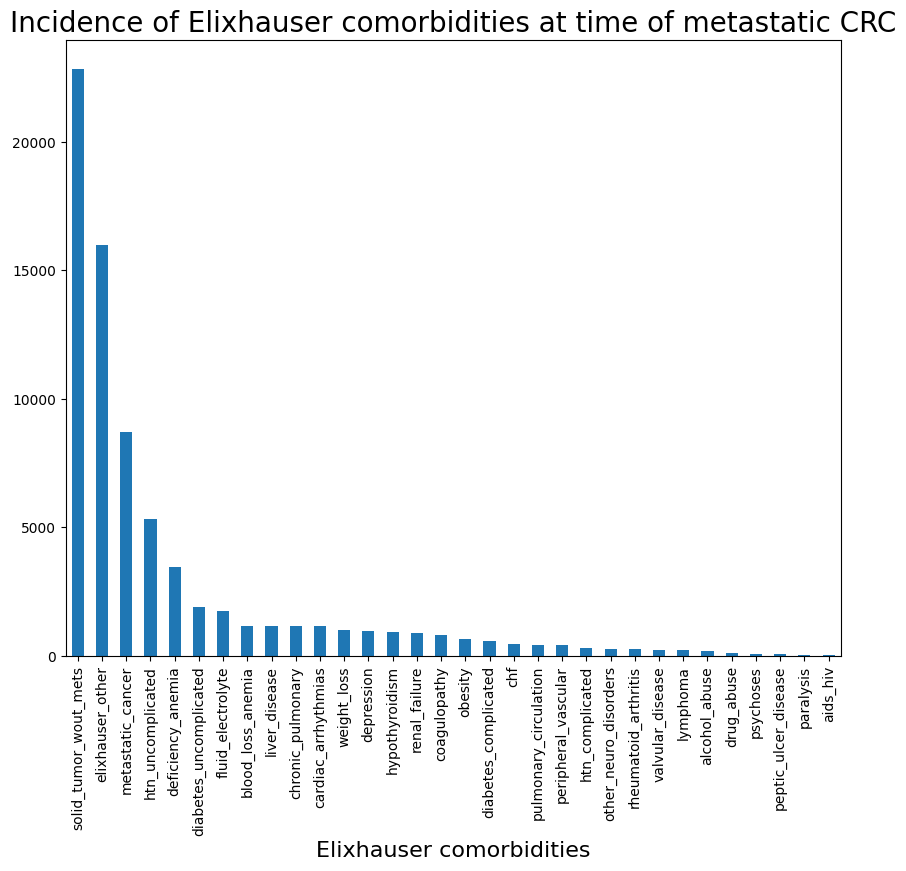

In [552]:
%matplotlib inline
diagnosis_elixhauser.iloc[:, 1:33].sum(axis = 0).sort_values(ascending = False).plot(kind = 'bar', figsize = (10,8))
plt.xlabel('Elixhauser comorbidities', fontsize = 16)
plt.title('Incidence of Elixhauser comorbidities at time of metastatic CRC', fontsize = 20)

Text(0.5, 1.0, 'Incidence of Elixhauser comorbidities at time of metastatic CRC')

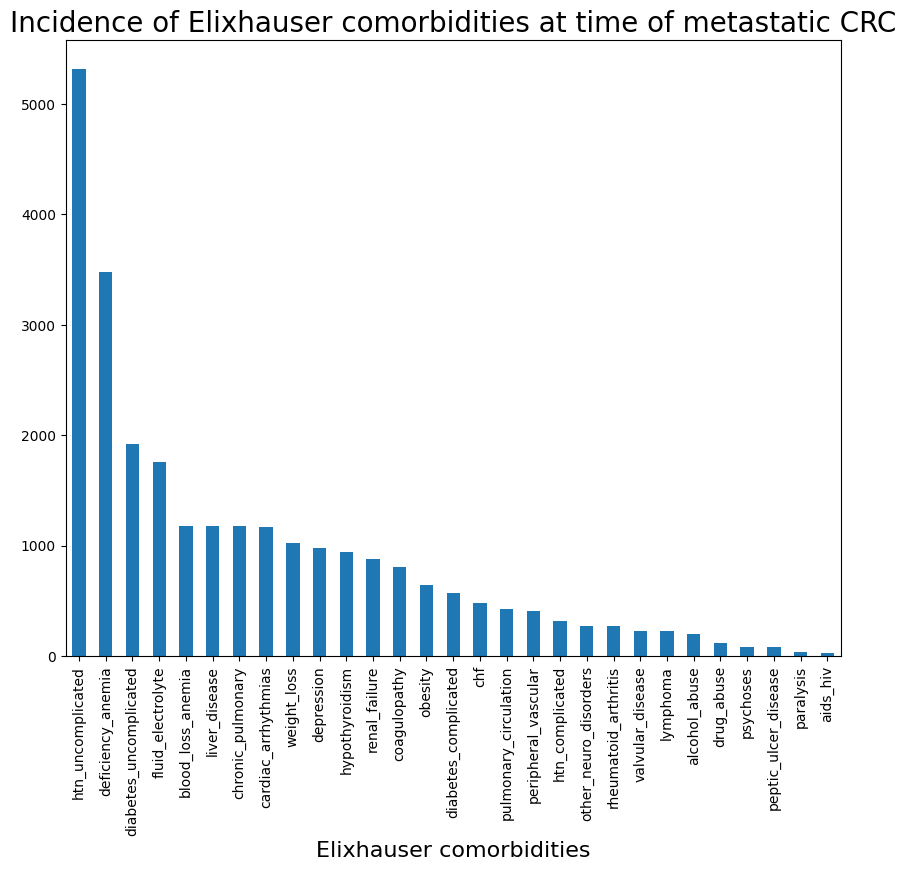

In [553]:
# Same plot as above but excluding tumor and mets.
%matplotlib inline
diagnosis_elixhauser.iloc[:, 1:33].sum(axis = 0).sort_values(ascending = False).tail(29).plot(kind = 'bar', figsize = (10,8))
plt.xlabel('Elixhauser comorbidities', fontsize = 16)
plt.title('Incidence of Elixhauser comorbidities at time of metastatic CRC', fontsize = 20)

In [554]:
# Append missing training IDs.
diagnosis_elixhauser = (
    diagnosis_elixhauser
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(diagnosis_elixhauser['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [555]:
row_ID(diagnosis_elixhauser)

(27452, 27452)

In [556]:
diagnosis_elixhauser.sample(5)

,PatientID,chf,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,htn_uncomplicated,htn_complicated,paralysis,other_neuro_disorders,...,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemia,alcohol_abuse,drug_abuse,psychoses,depression,elixhauser_other,icd_count
6135,F41F1631E546F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23557,FFE60B1FB82DF,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0
20361,FCDB1AADC722D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9628,F675B713DC253,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
22941,F38AC96CE2AFA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Colon cancer location

**Right sided colon cancer (ie., proximal to the splenic flexure) is an independent, poor prognostic factor for overall survival. Using ICD codes, we will attempt to clarify the site of the colon cancer.**

In [557]:
enhanced_met.CrcSite.value_counts(dropna = False)

Colon             20173
Rectum             6614
Colorectal NOS      665
Name: CrcSite, dtype: int64

In [558]:
diagnosis_elix_9.loc[:, 'right_colon'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('153[01456]'), 1, 0)
)

In [559]:
diagnosis_elix_9.loc[:, 'left_colon'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('153[237]'), 1, 0)
)

In [560]:
colon_location_9 = diagnosis_elix_9[['PatientID', 'right_colon', 'left_colon']].groupby('PatientID').sum()

In [561]:
diagnosis_elix_10.loc[:, 'right_colon'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C18[01234]'), 1, 0)
)

In [562]:
diagnosis_elix_10.loc[:, 'left_colon'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C18[567]'), 1, 0)
)

In [563]:
colon_location_10 = diagnosis_elix_10[['PatientID', 'right_colon', 'left_colon']].groupby('PatientID').sum()

In [564]:
colon_location = (
    pd.concat([colon_location_9, colon_location_10])
    .groupby('PatientID').sum()
    .reset_index()
)

In [565]:
colon_location = pd.merge(enhanced_met[['PatientID', 'CrcSite']], colon_location, on = 'PatientID', how = 'left')

In [566]:
colon_location[['right_colon', 'left_colon']] = colon_location[['right_colon', 'left_colon']].fillna(0)

In [567]:
row_ID(colon_location)

(27452, 27452)

In [568]:
# Create indicator variable where where 2 if positive, 1 if negative, and 0 if unknown or missing. 
conditions = [
    (colon_location['CrcSite'] == 'Colon') & (colon_location['right_colon'] >= 1),
    (colon_location['CrcSite'] == 'Colon') & (colon_location['right_colon'] == 0) & (colon_location['left_colon'] >= 1),
    (colon_location['CrcSite'] == 'Colon') & (colon_location['right_colon'] == 0) & (colon_location['left_colon'] == 0),
    (colon_location['CrcSite'] == 'Rectum'),
    (colon_location['CrcSite'] == 'Colorectal NOS')]

choices = ['colon_right', 'colon_left', 'colon_unknown', 'rectum', 'unknown']

colon_location.loc[:, 'crc_site'] = np.select(conditions, choices)

In [569]:
colon_location.crc_site.value_counts(dropna = False, normalize = True)

colon_unknown    0.299577
colon_right      0.241585
rectum           0.240930
colon_left       0.193684
unknown          0.024224
Name: crc_site, dtype: float64

In [570]:
enhanced_met = pd.merge(enhanced_met, colon_location[['PatientID', 'crc_site']], on = 'PatientID')

#### Other cancer 

##### ICD-9 Cancer codes 

In [571]:
# Select all ICD-9 cancer codes between 140-209.
# Exclude benign neoplasms: 210-229, carcinoma in site: 230-234, and neoplasms of uncertain behavior or nature: 235-239.
cancer_9 = (
    diagnosis_elix_9[diagnosis_elix_9['DiagnosisCode'].str.startswith(
        ('14','15', '16', '17', '18', '19', '20'))]
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [572]:
row_ID(cancer_9)

(12996, 8475)

**Remove the following ICD-9 codes representing colorectal cancer, metastasis, ill-defined neoplasms, and benign neoplasms of skin (BCC and SCC):**
* **153 - Malignant neoplasm of colon**
* **154 - Malignant neoplasm of rectum rectosigmoid junction and anus**
* **155 - Malignant neoplasm of liver and intrahepatic bile ducts**
* **158 - Malignant neoplasm of retroperitoneum and peritoneum**
* **159 - Malignant neoplasm of other and ill-defined sites within the digestive organs and peritoneum**
* **173 - Other and unspecified malignant neoplasm of skin**
* **195.2 - Malignant neoplasm of abdomen**
* **196 - Secondary and unspecified malignant neoplasm of lymph nodes**
* **197 - Secondary malignant neoplasm of respiratory and digestive systems**
* **198 - Secondary malignant neoplasm of other specified sites** 
* **199 - Malignant neoplasm without specification of site**

In [573]:
# Count ICD-9 neoplasm codes that represent colorectal cancer or its associated metastases.
(
    cancer_9[cancer_9['diagnosis_code'].str.match('15([34589])|'
                                                  '173|'
                                                  '19(52|[6789])')]
    .DiagnosisCode
    .value_counts(normalize = True)
    .head(10)
)

153.9    0.190338
154.1    0.146729
153.3    0.119111
197.7    0.096366
153.6    0.078752
153.4    0.053527
154.0    0.049423
197.0    0.038991
153.1    0.030868
153.2    0.028730
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-9 codes for colorectal cancer and metastasis are:** 
* **153.9 - Malignant neoplasm of colon, unspecified site**
* **154.1 - Malignant neoplast of rectun, unspecified site**
* **153.3 - Malignant neoplasm of sigmoid colon**
* **197.7 - Malignant neoplasm of liver, secondary**
* **153.6 - Malignant neoplasm of ascending colon**
* **153.4 - Malignant neoplasm of cecum**
* **154.0 - Malignant neoplasm of rectosigmoid junction**
* **197.0 - Secondary malignant neoplasm of lung**
* **153.1 - Malignant neoplasm of transverse colon**
* **153.2 - Malignant neoplasm of descending colon**

In [574]:
# Dataframe of ICD-9 neoplasm codes that exclude colorectal cancer, metastasis, or benign neoplasms.
other_cancer_9 = (
    cancer_9[~cancer_9['diagnosis_code'].str.match('15([34589])|'
                                                   '173|'
                                                   '19(52|[6789])')]
)

In [575]:
other_cancer_9.DiagnosisCode.value_counts(normalize = True).head(10)

185       0.133743
174.9     0.105304
174.4     0.045350
162.9     0.038432
204.10    0.036126
189.0     0.029977
162.3     0.026134
202.80    0.026134
174.8     0.025365
188.9     0.023059
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-9 codes at time of diagnosis that aren't colorectal cancer, metastasis, or benign neoplasm:**
* **185 - Malignant neoplasm of prostate**
* **174.9 - Malignant neoplasm of breast (female), unspecified**
* **174.4 - Malignant neoplasm of upper-outer quadrant of female breast**
* **162.9 - Malignant neoplasm of bronchus and lung, unspecified**
* **204.10 - Chronic lymphoid leukemia, without mention of having achieved remission**
* **189.0 - Malignant neoplasm of kidney, except pelvis**
* **202.80 - Other malignant lymphomas, unspecified site, extranodal and solid organ site**
* **188.9 - Malignant neoplasm of bladder, part unspecified**
* **174.8 - Malignant neoplasm of other specified sites of female breast** 
* **183.0 - Malignant neoplasm of ovary**

In [576]:
other_cancer_9.DiagnosisCode.str[0:3].value_counts(normalize = True).head(10)

174    0.233666
185    0.133743
162    0.089931
202    0.063797
172    0.044581
204    0.040738
189    0.036895
188    0.033820
209    0.031514
200    0.026134
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-9 family codes at time of diagnosis that aren't colorectal cancer, metastasis, or benign neoplasm:**
* **174 - Malignant neoplasm of female breast**
* **185 - Malignant neoplasm of prostate**
* **162 - Malignant neoplasm of trachea bronchus and lung**
* **202 - Other malignant neoplasms of lymphoid and histiocytic tissue**
* **172 - Malignant melanoma of skin**
* **204 - Lymphoid leukemia**
* **188 - Malignant neoplasm of bladder**
* **189 - Malignant neoplasm of kidney and other and unspecified urinary organs**
* **209 - Neuroendocrine tumors**
* **183 - Malignant neoplasm of ovary and other uterine adnexa**

In [577]:
other_cancer_9.loc[:,'other_cancer_9'] = 1

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [578]:
other_cancer_9 = (
    other_cancer_9
    .drop_duplicates(subset = 'PatientID', keep = 'first')
    .filter(items = ['PatientID', 'other_cancer_9'])
)

In [579]:
row_ID(other_cancer_9)

(1091, 1091)

In [580]:
other_cancer_9 = (
    other_cancer_9
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(other_cancer_9['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [581]:
row_ID(other_cancer_9)

(27452, 27452)

##### ICD-10 Cancer codes

In [582]:
# Select all ICD-10 codes between C00-D49 
# Exclude in situ neoplasms: D00-D09, benign neoplasms: D10-D36, benign neuroendocrine tumor: D3A, and neoplasms of unspecified behavior: D37 and D49
cancer_10 = (
    diagnosis_elix_10[diagnosis_elix_10['DiagnosisCode'].str.startswith(
        ('C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'D38', 'D39', 'D4'))]
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [583]:
row_ID(cancer_10)

(29767, 16338)

**Remove the following ICD-10 codes which capture lung cancer, metastasis, and benign skin neoplasms(eg., BCC and SCC).**
* **C18 - Malignant neoplasm of colon**
* **C19 - Malignant neoplasm of rectosigmoid junction**
* **C20 - Malignant neoplasm of rectum**
* **C21.8 - Malignant neoplasm of overlapping sites of rectum, anus and anal canal**
* **C22 - Malignant neoplasm of liver, not specified as primary or secondary**
* **C26 - Malignant neoplasm of other and ill-defined digestive organs**
* **C44 - Other and unspecified malignant neoplasm of skin**
* **C77 - Secondary and unspecified malignant neoplasm of lymph nodes**
* **C78 - Secondary malignant neoplasm of respiratory and digestive organs**
* **C79 - Secondary malignant neoplasm of other and unspecified sites**
* **C80 - Malignant neoplasm without specification of site**
* **D47.2 - Monoclonal gammopathy**
* **D48 - Neoplasm of uncertain behavior of other and unspecified sites**
* **D49 - Neoplasms of unspecified behavior** 

In [584]:
# Count of top 10 ICD-10 codes that represent lung cancer or metastasis. 
(
    cancer_10[cancer_10['diagnosis_code'].str.match('C1[89]|'
                                                    'C2([06]|18|29)|'
                                                    'C44|'
                                                    'C7[789]|'
                                                    'C80|'
                                                    'D4(72|[89])')]
    .DiagnosisCode
    .value_counts(normalize = True)
    .head(10)
)

C78.7    0.148778
C20      0.122949
C18.7    0.117396
C18.9    0.113241
C18.2    0.084725
C18.0    0.053629
C19      0.033639
C78.6    0.028445
C18.4    0.026689
C77.2    0.025364
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-10 codes at time of diagnosis that represent colorectal cancer, metastases, ill-defined neoplasm, or benign neoplasm:**
* **C78.7 - Secondary malignant neoplasm of liver and intrahepatic bile duct**
* **C20 - Malignant neoplasm of rectum**
* **C18.9 - Malignant neoplasm of colon, unspecified**
* **C18.7 - Malignant neoplasm of sigmoid colon**
* **C18.2 - Malignant neoplasm of ascending colon**
* **C18.0 - Malignant neoplasm of cecum**
* **C19 - Malignant neoplasm of rectosigmoid junction**
* **C78.6 - Secondary malignant neoplasm of retroperitoneum and peritoneum**
* **C18.4 - Malignant neoplasm of transverse colon**
* **C77.2 - Secondary and unspecified malignant neoplasm of intra-abdominal lymph nodes**

In [585]:
# Dataframe of ICD-10 neoplasm codes that exclude lung cancer, metastasis, or benign neoplasms.
other_cancer_10 = (
    cancer_10[~cancer_10['diagnosis_code'].str.match('C1[89]|'
                                                     'C2([06]|18|29)|'
                                                     'C44|'
                                                     'C7[789]|'
                                                     'C80|'
                                                     'D4(72|[89])')]
)

In [586]:
other_cancer_10.DiagnosisCode.value_counts(normalize = True).head(10)

C61        0.087426
D47.3      0.054506
C34.90     0.031301
C34.11     0.021587
C34.12     0.021047
D38.1      0.018349
C73        0.016730
C56.9      0.015650
C91.10     0.015650
C50.919    0.015650
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-10 codes at time of diagnosis that aren't colorectal cancer, metastasis, or benign neoplasm:**
* **C61 - Malignant neoplasm of prostate**
* **D47.3 - Essential (hemorrhagic) thrombocythemia**
* **C34.90 - Malignant neoplasm of unspecified part of bronchus or lung**
* **C34.12 - Malignant neoplasm of upper lobe, left bronchus or lung**
* **C34.11 - Malignant neoplasm of upper lobe, right bronchus or lung**
* **C91.10 - Chronic lymphocytic leukemia of B-cell type not having achieved remission**
* **C56.9 - Malignant neoplasm of unspecified ovary**
* **D38.1 - Neoplasm of uncertain behavior of trachea, bronchus and lung**
* **C34.32 - Malignant neoplasm of lower lobe, left bronchus or lung**
* **C50.912 - Malignant neoplasm of unspecified site of left female breast**

In [587]:
other_cancer_10.DiagnosisCode.str[0:3].value_counts(normalize = True).head(10)

C34    0.139234
C50    0.107933
C61    0.087426
D47    0.060443
C22    0.045332
C7A    0.038316
C17    0.034539
C67    0.028063
C64    0.027523
C25    0.025904
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-10 family codes at time of diagnosis that aren't colorectal cancer, metastasis, or benign neoplasm:**
* **C34 - Malignant neoplasm of bronchus and lung**
* **C50 - Malignant neoplasm of breast**
* **C61 - Malignant neoplasm of prostate**
* **D47 - Other neoplasms of uncertain behavior of lymphoid, hematopoietic and related tissue**
* **C22 - Malignant neoplasm of liver and intrahepatic bile ducts**
* **C7A - Malignant neuroendocrine tumors**
* **C64 - Malignant neoplasm of kidney, except renal pelvis**
* **C17 - Malignant neoplasm of small intestine**
* **C56 - Malignant neoplasm of ovary**
* **C91 - Lymphoid leukemia**

In [588]:
other_cancer_10.loc[:,'other_cancer_10'] = 1

In [589]:
# Drop duplicates.
other_cancer_10 = (
    other_cancer_10
    .drop_duplicates(subset = 'PatientID', keep = 'first')
    .filter(items = ['PatientID', 'other_cancer_10'])
)

In [590]:
row_ID(other_cancer_10)

(1465, 1465)

In [591]:
# Append missing training IDs.
other_cancer_10 = (
    other_cancer_10
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(other_cancer_10['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [592]:
row_ID(other_cancer_10)

(27452, 27452)

In [593]:
other_cancer = pd.merge(other_cancer_9, other_cancer_10, on = 'PatientID')

In [594]:
# Combine other_cancer_9 and other_cancer_19; replace values equal to 2 with 1. 
other_cancer = (
    other_cancer
    .assign(other_cancer = other_cancer['other_cancer_9'] + other_cancer['other_cancer_10'])
    .filter(items = ['PatientID', 'other_cancer'])
    .replace(2, 1)
)

In [595]:
row_ID(other_cancer)

(27452, 27452)

In [596]:
# Percentage of patients with a cancer other than colorectal or mets. 
len(other_cancer[other_cancer['other_cancer'] == 1])/len(other_cancer)

0.08789887804167273

#### Sites of metastases

##### ICD-9 sites of metastases

In [597]:
# Create dataframe contianing patients with ICD-9 codes within -90 to +30 days from advanced diagnosis and remove duplicate codes.(
diagnosis_mets_9 = (
    diagnosis
    .query('diagnosis_date_diff >= -90 and diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = ['PatientID', 'DiagnosisCode'], keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

**Sites of metastasis will be grouped into the following categories according to ICD-9 codes:**
* **Thorax - 197.0, 197.1, 197.2, and 197.3**
* **Peritoneum - 197.6**
* **Liver - 197.7**
* **Other GI - 197.4 and 197.8**
* **CNS - 198.3 and 198.4**
* **Bone - 198.5**
* **Other - 198.0, 198.1, 198.2, 198.6, 198.7, 198.8, and 196**

In [598]:
diagnosis_mets_9['thorax_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('197[0123]'), 1, 0)

In [599]:
diagnosis_mets_9['peritoneum_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('1976'), 1, 0)

In [600]:
diagnosis_mets_9['liver_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('1977'), 1, 0)

In [601]:
diagnosis_mets_9['other_gi_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('197[48]'), 1, 0)

In [602]:
diagnosis_mets_9['cns_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('198[34]'), 1, 0)

In [603]:
diagnosis_mets_9['bone_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('1985'), 1, 0)

In [604]:
diagnosis_mets_9['other_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('198[012678]|'
                                                                                      '196'), 1, 0)

In [605]:
# Collapse columns and sum.
diagnosis_mets_9 = (
    diagnosis_mets_9
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

##### ICD-10 sites of metastases

In [606]:
# Create dataframe contianing patients with ICD-10 codes within -90 to +30 days from advanced diagnosis and remove duplicate codes.
diagnosis_mets_10 = (
    diagnosis
    .query('diagnosis_date_diff >= -90 and diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = ['PatientID', 'DiagnosisCode'], keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

**Sites of metastasis will be grouped into the following categories according to ICD-10 codes:**
* **Thorax - C78.0, C78.1, C78.2, and C78.3**
* **Peritoneum - C78.6**
* **Liver - C78.7**
* **Other GI - C78.4 and C78.8**
* **CNS - C79.3 and C79.4**
* **Bone - C79.5**
* **Other - C77, C79.0, C79.1, C79.2, C79.6, C79.7, C79.8, and C79.9**

In [607]:
diagnosis_mets_10['thorax_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C78[0123]'), 1, 0)

In [608]:
diagnosis_mets_10['peritoneum_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C786'), 1, 0)

In [609]:
diagnosis_mets_10['liver_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C787'), 1, 0)

In [610]:
diagnosis_mets_10['other_gi_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C78[48]'), 1, 0)

In [611]:
diagnosis_mets_10['cns_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C79[34]'), 1, 0)

In [612]:
diagnosis_mets_10['bone_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C795'), 1, 0)

In [613]:
diagnosis_mets_10['other_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C77|'
                                                                                        'C79[0126789]'), 1, 0)

In [614]:
# Collapse columns and sum. 
diagnosis_mets_10 = (
    diagnosis_mets_10
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

In [615]:
# Merge ICD-9 and ICD-10 mets tables; collapse and sum. 
diagnosis_mets = (
    pd.concat([diagnosis_mets_9, diagnosis_mets_10])
    .groupby('PatientID').sum()
)

In [616]:
# All values >1 replaced by 1. 
diagnosis_mets = (
    diagnosis_mets.mask(diagnosis_mets > 1, 1)
    .reset_index()
)

In [617]:
# Append missing training IDs.
diagnosis_mets = (
    diagnosis_mets.append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(diagnosis_mets['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [618]:
row_ID(diagnosis_mets)

(27452, 27452)

In [619]:
# Percentage with mets by site of location at time of metastatic diagnosis
(diagnosis_mets.iloc[:, 1:].sum()/len(diagnosis_mets)).sort_values(ascending = False)

liver_met         0.186252
thorax_met        0.066953
other_met         0.060251
peritoneum_met    0.034096
bone_met          0.018031
cns_met           0.005318
other_gi_met      0.004881
dtype: float64

In [620]:
# Percentage of patiens with ICD code denoting mets at time of metastatic diagnosis. 
len(diagnosis_mets[diagnosis_mets.eq(1).any(1)])/len(diagnosis_mets)

0.2881028704648113

In [621]:
diagnosis_mets.sample(5)

,PatientID,thorax_met,peritoneum_met,liver_met,other_gi_met,cns_met,bone_met,other_met
9212,F784B6ED52756,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19217,FFDAAEC1A994F,0.0,0.0,0.0,0.0,0.0,0.0,0.0
706,FCE5B8B5B6762,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14552,FC02C836981B2,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19275,FFE60B1FB82DF,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Merge

In [622]:
diagnosis_wide = pd.merge(diagnosis_elixhauser, other_cancer, on = 'PatientID')

In [623]:
diagnosis_wide = pd.merge(diagnosis_wide, diagnosis_mets, on = 'PatientID')

In [624]:
row_ID(diagnosis_wide)

(27452, 27452)

In [625]:
list(diagnosis_wide.columns)

['PatientID',
 'chf',
 'cardiac_arrhythmias',
 'valvular_disease',
 'pulmonary_circulation',
 'peripheral_vascular',
 'htn_uncomplicated',
 'htn_complicated',
 'paralysis',
 'other_neuro_disorders',
 'chronic_pulmonary',
 'diabetes_uncomplicated',
 'diabetes_complicated',
 'hypothyroidism',
 'renal_failure',
 'liver_disease',
 'peptic_ulcer_disease',
 'aids_hiv',
 'lymphoma',
 'metastatic_cancer',
 'solid_tumor_wout_mets',
 'rheumatoid_arthritis',
 'coagulopathy',
 'obesity',
 'weight_loss',
 'fluid_electrolyte',
 'blood_loss_anemia',
 'deficiency_anemia',
 'alcohol_abuse',
 'drug_abuse',
 'psychoses',
 'depression',
 'elixhauser_other',
 'icd_count',
 'other_cancer',
 'thorax_met',
 'peritoneum_met',
 'liver_met',
 'other_gi_met',
 'cns_met',
 'bone_met',
 'other_met']

In [626]:
%whos DataFrame

Variable                 Type         Data/Info
-----------------------------------------------
biomarker_wide           DataFrame               PatientID     <...>n[27452 rows x 5 columns]
cancer_10                DataFrame                PatientID Dia<...>n[29767 rows x 3 columns]
cancer_9                 DataFrame                PatientID Dia<...>n[12996 rows x 3 columns]
colon_location           DataFrame               PatientID CrcS<...>n[27452 rows x 5 columns]
colon_location_10        DataFrame                   right_colo<...>n[17487 rows x 2 columns]
colon_location_9         DataFrame                   right_colo<...>n[10045 rows x 2 columns]
demographics             DataFrame               PatientID gend<...>n[27452 rows x 7 columns]
diagnosis                DataFrame                PatientID    <...>[869819 rows x 9 columns]
diagnosis_elix_10        DataFrame                PatientID Dia<...>126655 rows x 37 columns]
diagnosis_elix_10_wide   DataFrame               PatientID

In [627]:
# Keep biomarker_wide, demographics, diagnosis_wide, ecog_diagnosis_wide, enhanced_met, insurance_wide, 
# lab_wide, med_admin_wide, mortality, and weight_wide
del cancer_10
del cancer_9
del colon_location
del colon_location_10
del colon_location_9
del diagnosis
del diagnosis_elix_10
del diagnosis_elix_10_wide
del diagnosis_elix_9
del diagnosis_elix_9_wide
del diagnosis_elixhauser
del diagnosis_mets
del diagnosis_mets_10
del diagnosis_mets_9
del other_cancer
del other_cancer_10
del other_cancer_9

### SocialDeterminantsOfHealth

In [628]:
sdoh = pd.read_csv('SocialDeterminantsOfHealth.csv')

In [629]:
sdoh = sdoh[sdoh['PatientID'].isin(train_IDs)]

In [630]:
row_ID(sdoh)

(23660, 23660)

In [631]:
sdoh.sample(5)

,PatientID,PracticeID,SESIndex2015_2019
15883,F39F3FCC9F541,S23ADEA449811,5 - Highest SES
8267,F5F110F2E2F44,S91046AE44DF5,2
25523,F8FC9E470B2B7,S291CF564BD92,2
17846,F67E11C6F9F30,S98D0ED5E3A94,3
6423,FA858A04BE4E2,S02B5DAC9B9B2,4


**Measures the area-level socioeconomic status (SES) of a patient between 2015 and 2019 based on their most recent address.**

In [632]:
conditions = [
    (sdoh['SESIndex2015_2019'] == '5 - Highest SES'),
    (sdoh['SESIndex2015_2019'] == '1 - Lowest SES')]    

choices = ['5', '1']
    
sdoh.loc[:, 'ses'] = np.select(conditions, choices, default = sdoh['SESIndex2015_2019'])

In [633]:
sdoh = sdoh.drop(columns = ['PracticeID', 'SESIndex2015_2019'])

In [634]:
sdoh_wide = (
    sdoh
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(sdoh['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [635]:
row_ID(sdoh_wide)

(27452, 27452)

In [636]:
sdoh_wide.ses.value_counts(dropna = False, normalize = True)

NaN    0.243152
2      0.158750
4      0.158240
1      0.154743
3      0.153541
5      0.131575
Name: ses, dtype: float64

In [637]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID     <...>n[27452 rows x 5 columns]
demographics          DataFrame               PatientID gend<...>n[27452 rows x 7 columns]
diagnosis_wide        DataFrame               PatientID  chf<...>[27452 rows x 42 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[27452 rows x 2 columns]
enhanced_met          DataFrame               PatientID diag<...>n[27452 rows x 9 columns]
insurance_wide        DataFrame               PatientID  med<...>n[27452 rows x 9 columns]
lab_wide              DataFrame               PatientID  alb<...>27452 rows x 137 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[27452 rows x 15 columns]
mortality             DataFrame               PatientID  dea<...>n[27452 rows x 3 columns]
sdoh                  DataFrame               PatientID  ses<...>n[23660 rows x 2 columns]


In [638]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_met, mortality, 
# lab_wide, sdoh_wide, and weight wide
del sdoh

## Part 3: File merge

In [639]:
enhanced_met = enhanced_met.drop(columns = ['diagnosis_date', 'met_date', 'met_year_cat', 'CrcSite'])

In [640]:
train_full = pd.merge(demographics, enhanced_met, on = 'PatientID')

In [641]:
train_full = pd.merge(train_full, mortality, on = 'PatientID')

In [642]:
train_full = pd.merge(train_full, med_admin_wide, on = 'PatientID')

In [643]:
train_full = pd.merge(train_full, biomarker_wide, on = 'PatientID')

In [644]:
train_full = pd.merge(train_full, insurance_wide, on = 'PatientID')

In [645]:
train_full = pd.merge(train_full, ecog_diagnosis_wide, on = 'PatientID')

In [646]:
train_full = pd.merge(train_full, weight_wide, on = 'PatientID')

In [647]:
train_full = pd.merge(train_full, lab_wide, on = 'PatientID')

In [648]:
train_full = pd.merge(train_full, diagnosis_wide, on = 'PatientID')

In [649]:
train_full = pd.merge(train_full, sdoh_wide, on = 'PatientID')

In [650]:
row_ID(train_full)

(27452, 27452)

In [651]:
len(train_full.columns)

224

In [652]:
list(train_full.columns)

['PatientID',
 'gender',
 'race',
 'ethnicity',
 'age',
 'p_type',
 'region',
 'stage',
 'met_year',
 'delta_met_diagnosis',
 'crc_site',
 'death_status',
 'timerisk_activity',
 'steroid_diag',
 'opioid_PO_diag',
 'nonopioid_PO_diag',
 'pain_IV_diag',
 'ac_diag',
 'antiinfective_IV_diag',
 'antiinfective_diag',
 'antihyperglycemic_diag',
 'ppi_diag',
 'antidepressant_diag',
 'bta_diag',
 'thyroid_diag',
 'is_diag',
 'adjuv',
 'KRAS',
 'dMMR_MSIh',
 'NRAS',
 'BRAF',
 'medicare',
 'medicaid',
 'medicare_medicaid',
 'commercial',
 'patient_assistance',
 'other_govt',
 'self_pay',
 'other',
 'ecog_diagnosis',
 'weight_diag',
 'bmi_diag',
 'bmi_diag_na',
 'weight_pct_change',
 'weight_pct_na',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'cea_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_di

In [653]:
train_full.to_csv('train_full.csv', index = False, header = True)